In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from google.colab import drive
drive.mount('/content/drive')

input_path = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/Dataset"
output_path_plot = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlot"
if not os.path.exists(output_path_plot):
    os.makedirs(output_path_plot)
output_path_beam = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/RecordBeam"
if not os.path.exists(output_path_beam):
    os.makedirs(output_path_beam)
output_path_plot_beam = "/content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3"
if not os.path.exists(output_path_plot_beam):
    os.makedirs(output_path_plot_beam)

# Ottenere tutti i file nella directory che corrispondono al pattern richiesto
if not os.path.exists(input_path):
    print(f"Errore: La directory specificata non esiste: {input_path}")
    # Puoi aggiungere qui del codice per montare Google Drive se non è già montato
    # from google.colab import drive
    # drive.mount('/content/drive')
else:
    # Ottenere tutti i file nella directory che corrispondono al pattern richiesto
    files = os.listdir(input_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###plot pictures

In [30]:
## CODE EXTRACTED FROM Function_prepare_Final

# Controlla se la directory di output esiste, altrimenti creala
if not os.path.exists(output_path_plot):
    os.makedirs(output_path_plot)
    print(f"Creata directory di output: {output_path_plot}")

# Filtrare i file per tx0rx0 e tx1rx1
tx0rx0_files = sorted([f for f in files if "tx0rx0" in f])
tx1rx1_files = sorted([f for f in files if "tx1rx1" in f])

# Altezza delle finestre (125 righe per 5 secondi, nel caso fisiologico)
height = 125

# Decidere se usare una o due antenne:
use_single = 0  # 0 significa usare 2 antenne

# il bin di distanza oltre cui tagliare
cut_distance = 40

# Iterare sui file corrispondenti
for tx0_file, tx1_file in zip(tx0rx0_files, tx1rx1_files):
    # Caricare i dati dai file numpy
    data = np.load(os.path.join(input_path, tx0_file))
    data1 = np.load(os.path.join(input_path, tx1_file))

    # Convertire le matrici complesse in magnitudini (norme)
    data_float = np.abs(data)[:,0:cut_distance]
    data1_float = np.abs(data1)[:,0:cut_distance]

    # Step 1: Dividere le matrici in sottomatrici di altezza = 125 righe (5 secondi per fisio)
    n_rows = data_float.shape[0]
    n_parts = n_rows // height  # Numero di sottomatrici con altezza 125

    # Se ci sono righe rimanenti, aggiungere una parte aggiuntiva
    if n_rows % height != 0:
        n_parts += 1

    # Creare le sottomatrici dividendo entrambe le matrici
    parts_data = [data_float[i * height:(i + 1) * height, :] for i in range(n_parts)]
    parts_data1 = [data1_float[i * height:(i + 1) * height, :] for i in range(n_parts)]

    # Step 2: Affiancare le parti corrispondenti e salvarle come figure
    for i, (part_data, part_data1) in enumerate(zip(parts_data, parts_data1)):
        if use_single:
            merged_part = part_data
        else:
            # Affiancare (orizzontalmente) le due parti
            merged_part = np.hstack((part_data, part_data1))  # Combinarle fianco a fianco

        # Creare una nuova figura per ogni parte affiancata
        plt.figure(figsize=(merged_part.shape[1] / 100, merged_part.shape[0] / 100), dpi=100)
        plt.imshow(merged_part, cmap='gray', aspect='auto')
        plt.axis('off')  # Rimuovere gli assi per una vista più pulita

        # Rimuovere "Utente1fisio_" e sostituire il primo "_" con "." prima di "POLI"
        # Essenziale per Edge Impulse in modo tale che le classi siano importate in modo automatico
        #output_file_base = tx0_file.replace("Utente1_Generica ", "").replace("_POLI", ".POLI").replace("_tx0rx0.npy", "")
        #output_file = os.path.join(output_path, f"{output_file_base}_part{i+1}.png")
        output_file =  os.path.join(output_path_plot, f"tx0_file")
        if os.path.exists(output_file):
            print(f"Errore: Il file di output esiste già: {output_file}")
        else:
            # Salvare la figura affiancata
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Regolare il layout per evitare spazi bianchi
            plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
            plt.close()  # Chiudere la figura per evitare visualizzazione e risparmiare memoria

print("Elaboration completed!")

Elaboration completed!


###beam plot

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import re

def compute_bf_weights(angle_range, delta, k, nv, offset_angle):
    bf = np.zeros((angle_range.size, nv), dtype=complex)
    for ai in range(angle_range.size):
        adjusted_angle = angle_range[ai] - offset_angle
        for rx_i in range(nv):
            bf[ai, rx_i] = np.exp(-1j * k * delta * rx_i * np.sin(adjusted_angle))
    return bf

def beamforming(dataCube, bf_weights, angleDataCube):
    nv, st, ft = dataCube.shape
    na = bf_weights.shape[0]
    for i in range(st):
        for j in range(ft):
            vec = dataCube[:, i, j]
            for a in range(na):
                angleDataCube[i, j, a] = np.dot(vec, bf_weights[a])

def extract_time(string):
  match = re.search(r'-(\d+)_', string)
  if match:
    return match.group(1)
  return None

def extract_data_from_name(filename):

  match = re.search(r'\([^)]*\)', filename)
  if match:
    first_paren_content = match.group(0)
    string_after_first_paren = filename.replace(first_paren_content, '', 1)

    match_second = re.search(r'\(([^)]*)\)', string_after_first_paren)
    if match_second:
      content_second_paren = match_second.group(1)
      values = content_second_paren.split(',')
      if len(values) > 1:
        try:
          return float(values[0].strip()), float(values[1].strip())
        except ValueError:
          return None
  return None

def divide_files_by_time(files):
    files_by_time = []
    for filename in files:
        time = extract_time(filename)
        if time:
            if time not in [extract_time(f) for f in files_by_time]:
                files_by_time.append(filename)
    return files_by_time

def beam_plot_all(files):
    # Process files in groups of 4 with the same time
    one_file_per_time = divide_files_by_time(files)
    for record in one_file_per_time:
        beam_plot(record)

def beam_plot(name_file):
    # TROVA I FILE (assumendo siano nella stessa cartella dello script)
    #    Modifica path_dir se i file sono altrove.
    path_dir = input_path
    # Nome di uno dei file, preso da quello che hai già caricato:
    file0 = name_file
    prefix = file0.rsplit('_tx', 1)[0]

    distance, offset_angle = extract_data_from_name(file0)
    offset_angle = np.deg2rad(offset_angle)
    time = extract_time(file0)
    # Genera la lista completa delle 4 combinazioni tx/rx
    file_list = []
    for tx in [0,1]:
        for rx in [0,1]:
            name = f"{prefix}_tx{tx}rx{rx}.npy"
            file_list.append(os.path.join(path_dir, name))

    channels = [ np.load(fn) for fn in file_list ]
    dataCube = np.stack(channels, axis=0).astype(complex)

    #to split the resulting data in N slise, to have more for training on the slow_time axis, the time
    N = 120 # 0.5 seconds
    dataCubeSplit = np.array_split(dataCube, N, axis=1)

    # for i, part in enumerate(dataCubeSplit, 1):
    #   beam_plot_t(part, distance, offset_angle, time, part.shape[1], i)

    random_parts = random.sample(dataCubeSplit, 5)

    ##
    for i, part in enumerate(random_parts, 1):
        beam_plot_t(part, distance, offset_angle, time, part.shape[1], i)

def beam_plot_t(dataCube, distance, offset_angle, time, new_slow_time, i):

    # 4) PREPARA l'array di output
    angleDataCube = np.zeros(
        (new_slow_time, fast_time, beam_steering_angles.size),
        dtype=complex
    )

    # 6) CALCOLA e SALVA
    bf_weights = compute_bf_weights(beam_steering_angles, d, k_const, num_virtual_rx, offset_angle)
    beamforming(dataCube, bf_weights, angleDataCube)

    output_file = os.path.join(output_path_beam, 'beamformed_output_of_' + str(distance) + ',' + str(np.rad2deg(offset_angle)) + '_' + str(time) + '_part' + str(i) + '.npy')
    # np.save(output_file, angleDataCube)

    # Media sullo slow time per ottenere il grafico più pulito
    beamformed_image = np.abs(angleDataCube).mean(axis=0)

    beamformed_image -= beamformed_image.min()
    beamformed_image /= (beamformed_image.max() + 1e-8)

    target_size = 160
    dpi = 100
    fig_inches = target_size / dpi
    #
    plt.figure(figsize=(4,4), dpi=100)
    plt.imshow(beamformed_image, cmap='gray', aspect='auto', origin='lower')
    plt.axis('off')

    # SAVE
    plot_filename = f"beam_{distance:.0f}cm_{np.rad2deg(offset_angle):.1f}deg_{time}split{i}.png"
    plot_path = os.path.join(output_path_plot_beam, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"Grayscale image saved: {plot_path}")

    B = 2.15e9  # Larghezza di banda del radar in Hz
    range_bin_size = c / (2 * B)
    ranges_in_meters = np.arange(fast_time) * range_bin_size

    # Modifica il plot includendo range in metri:
    plt.figure(figsize=(8, 6))
    extent = [
        np.rad2deg(beam_steering_angles[0]),
        np.rad2deg(beam_steering_angles[-1]),
        ranges_in_meters[0],
        ranges_in_meters[-1]
    ]
    plt.imshow(beamformed_image, extent=extent, aspect='auto', cmap='viridis', origin='lower')
    plt.xlabel('Angles [°]')
    plt.ylabel('Range [m]')
    plt.colorbar(label='Amplitude')
    plt.title('Beamforming Output of ' + str(distance/100) + 'm' + ' ' + str(np.rad2deg(offset_angle)) + '° time: ' + str(time) + ' part: ' + str(i))
    plt.show()

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141912split1.png


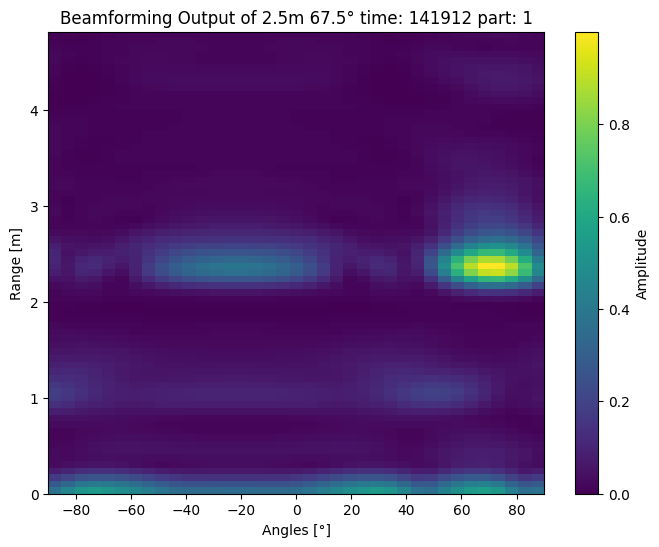

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141912split2.png


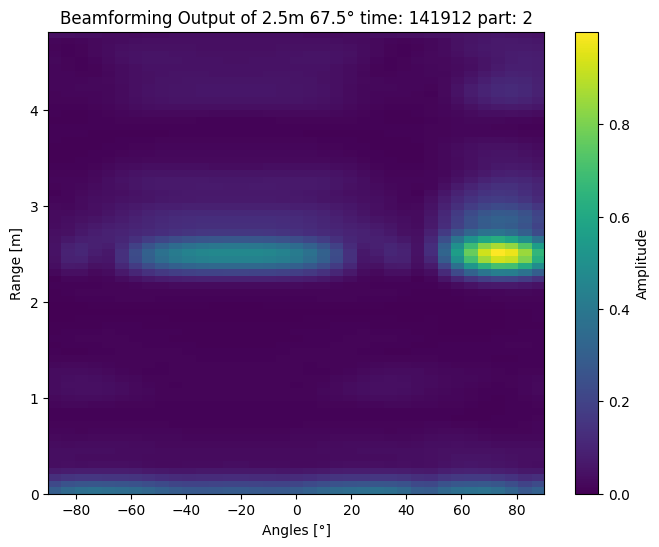

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141912split3.png


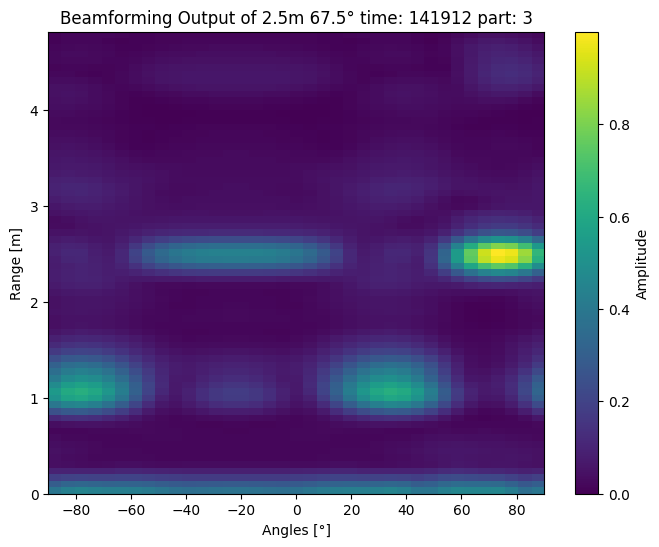

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141912split4.png


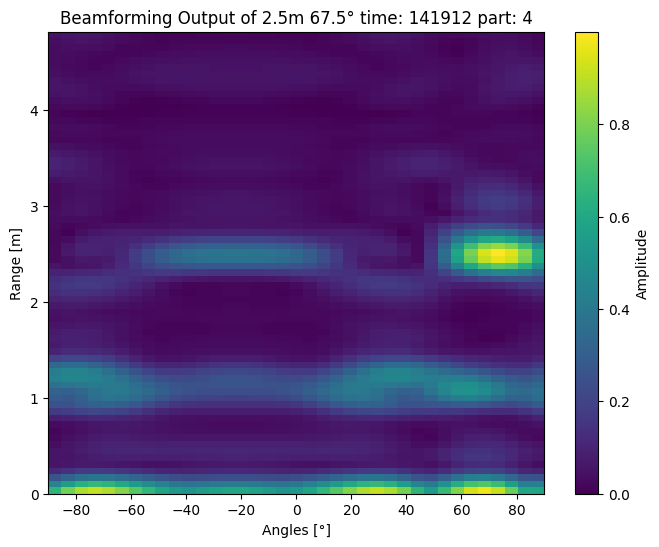

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141912split5.png


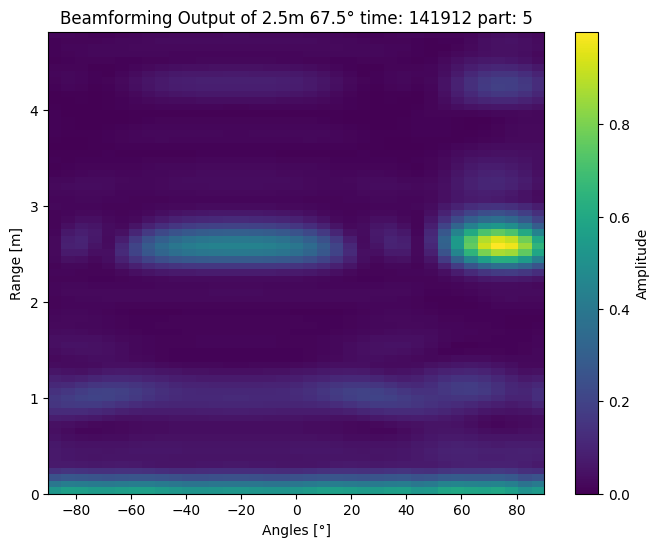

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142020split1.png


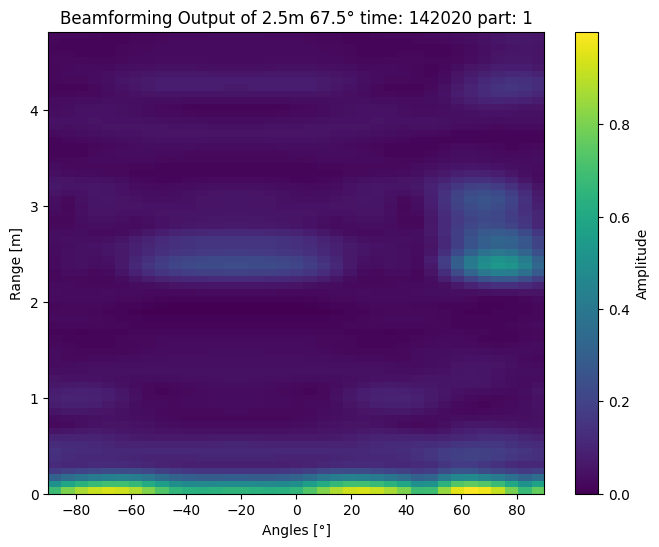

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142020split2.png


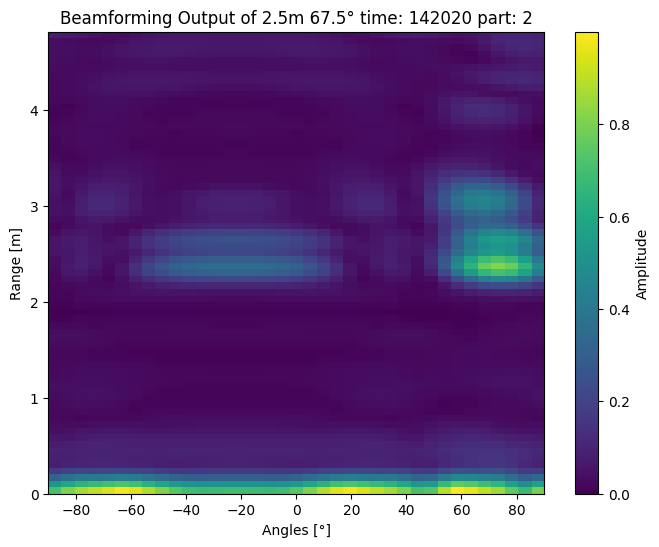

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142020split3.png


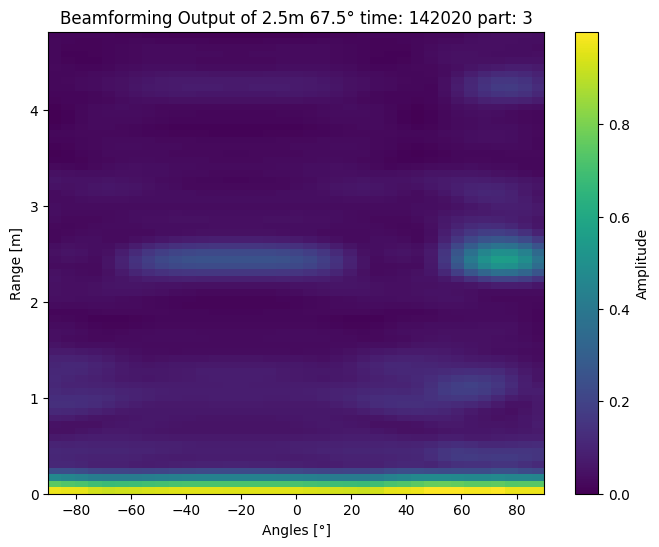

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142020split4.png


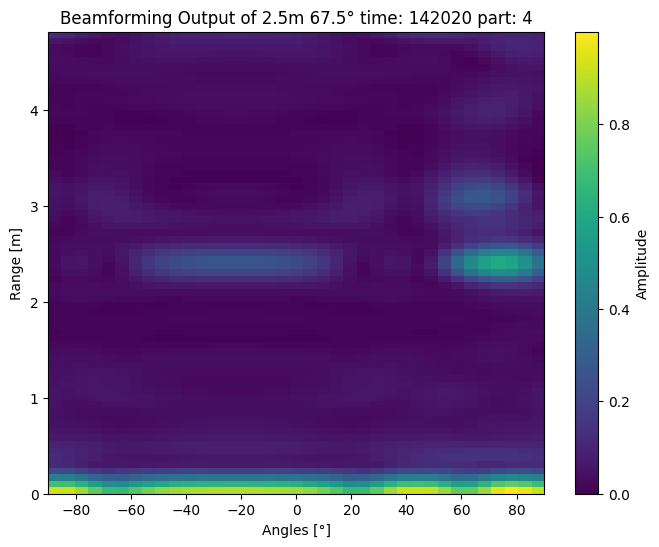

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142020split5.png


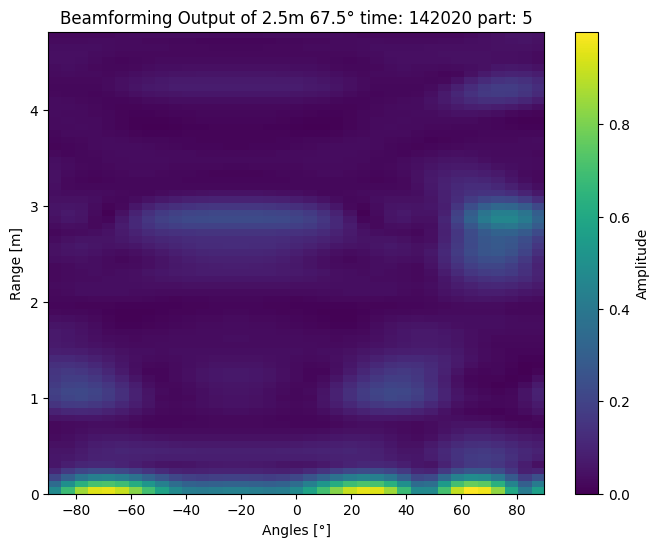

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141544split1.png


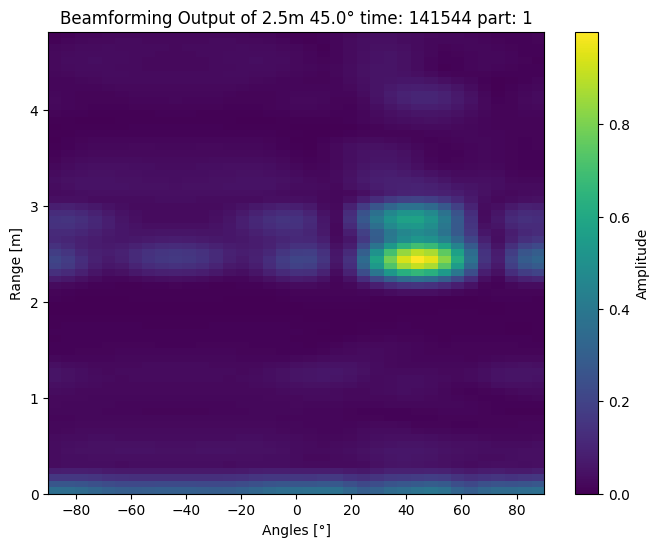

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141544split2.png


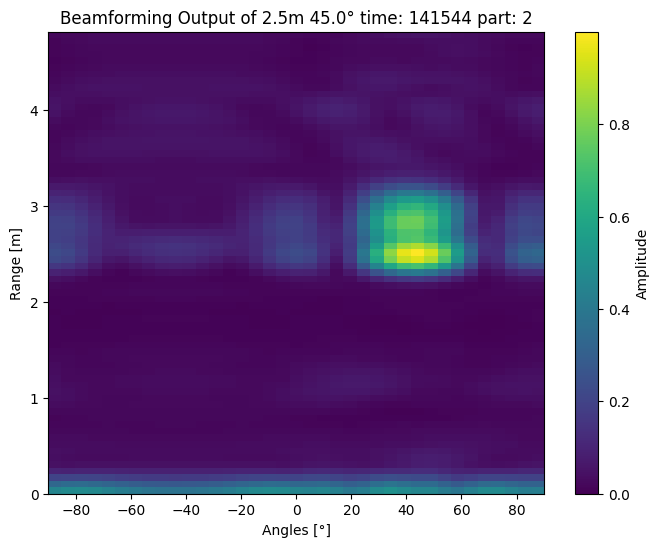

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141544split3.png


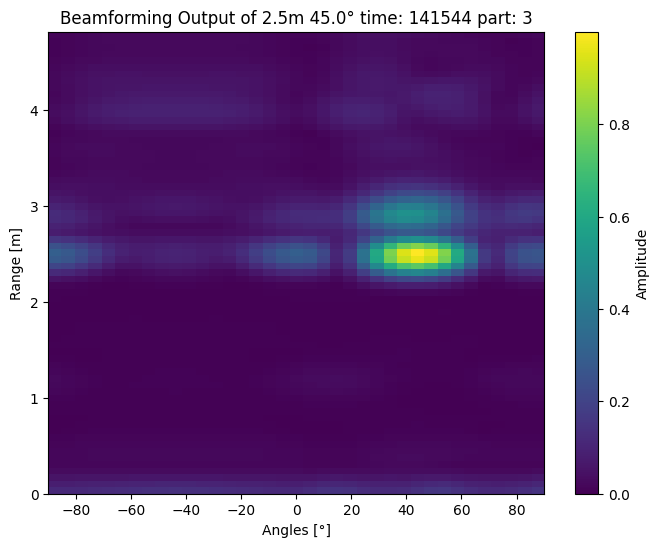

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141544split4.png


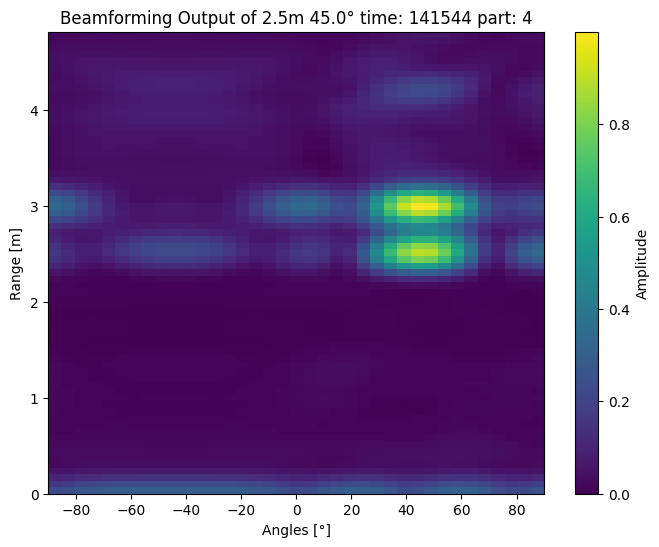

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141544split5.png


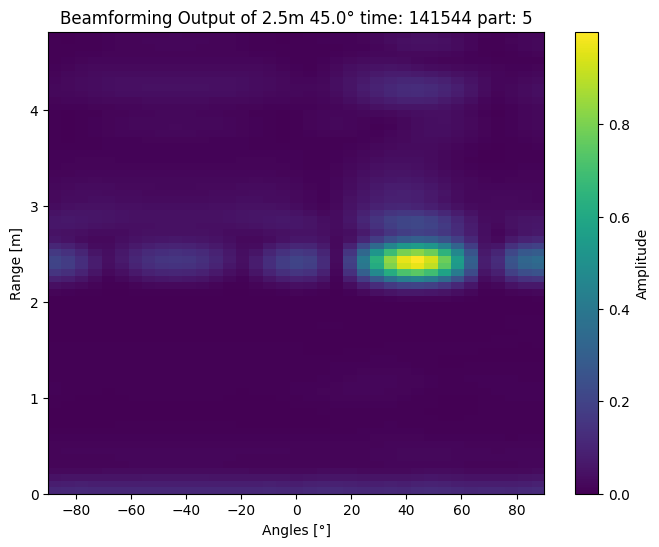

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141658split1.png


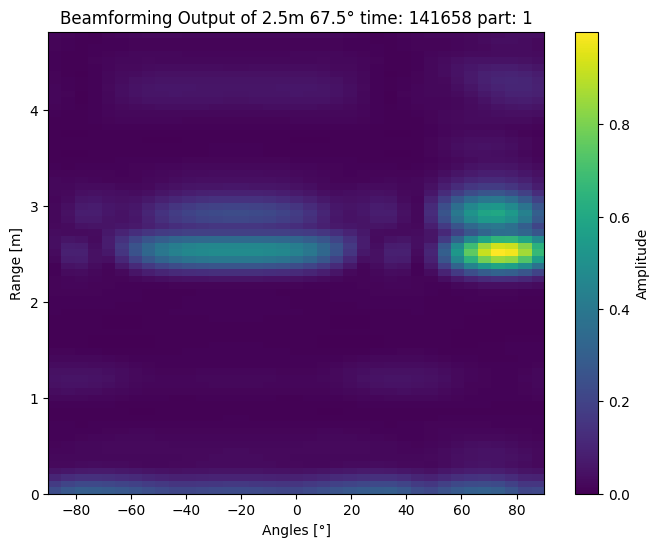

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141658split2.png


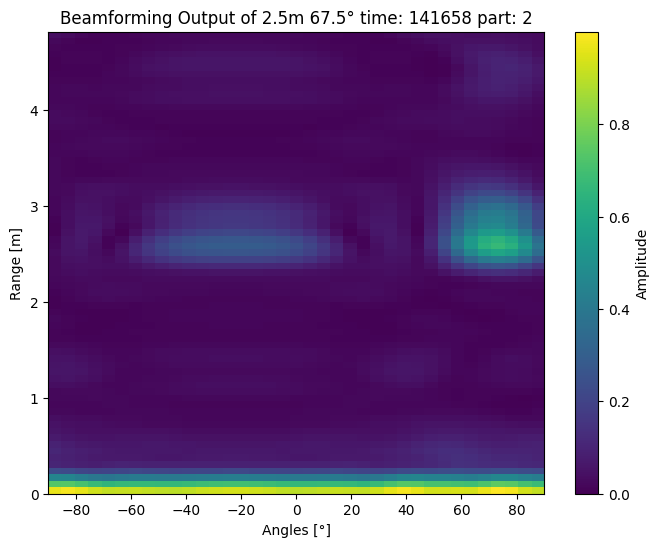

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141658split3.png


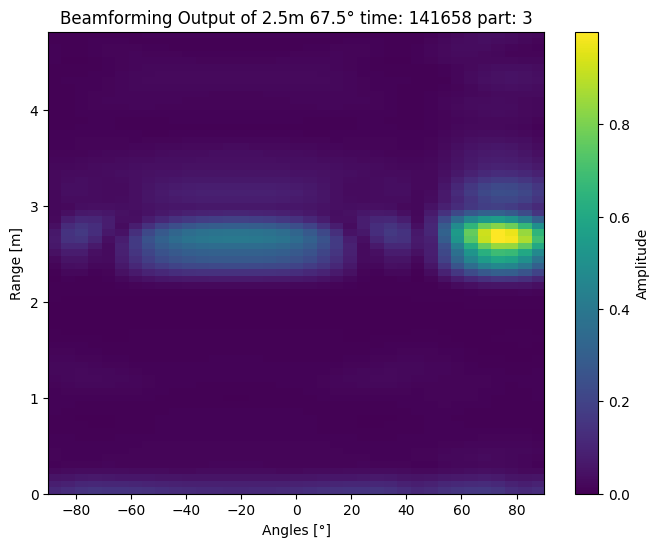

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141658split4.png


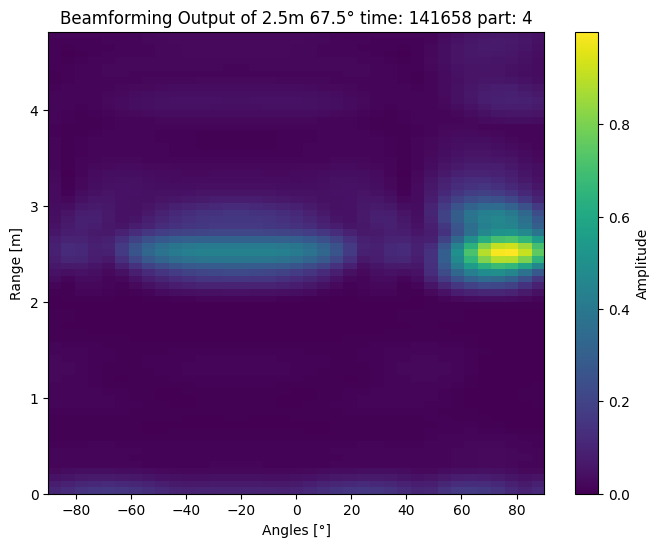

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141658split5.png


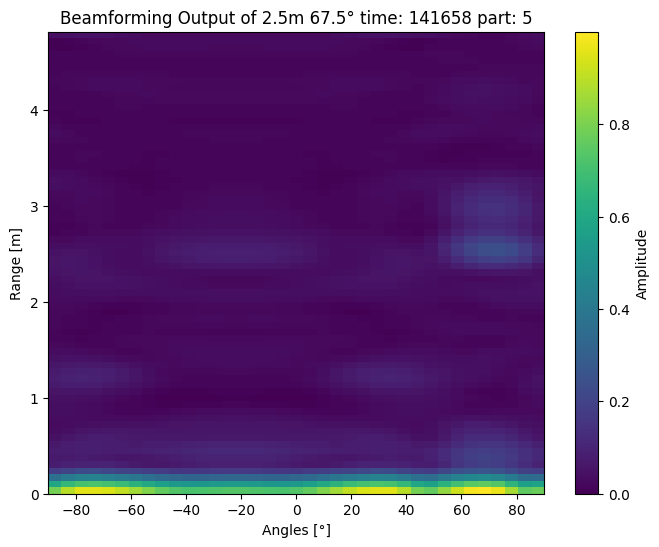

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141326split1.png


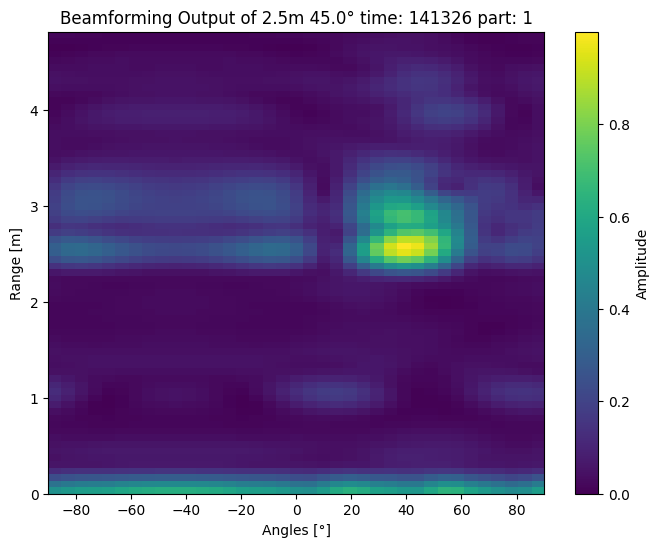

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141326split2.png


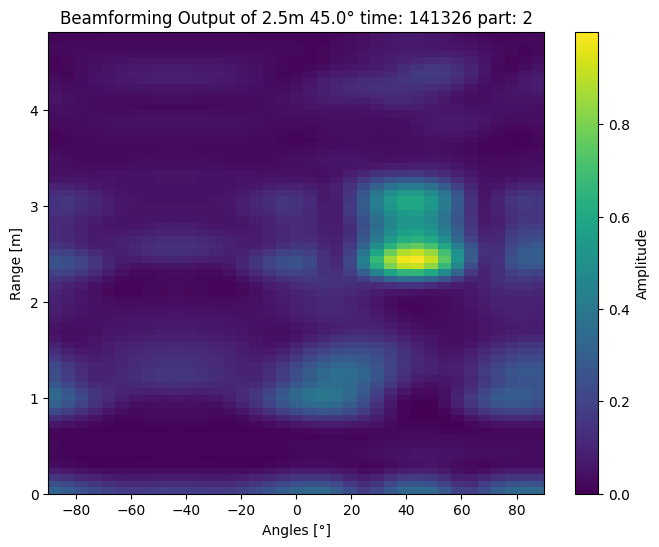

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141326split3.png


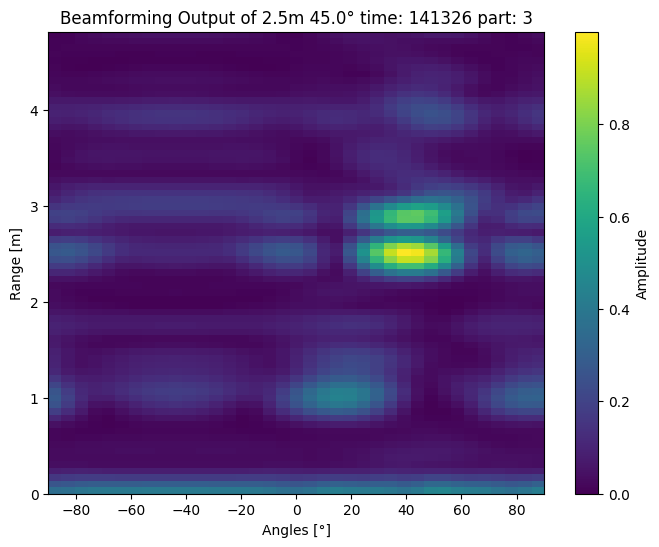

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141326split4.png


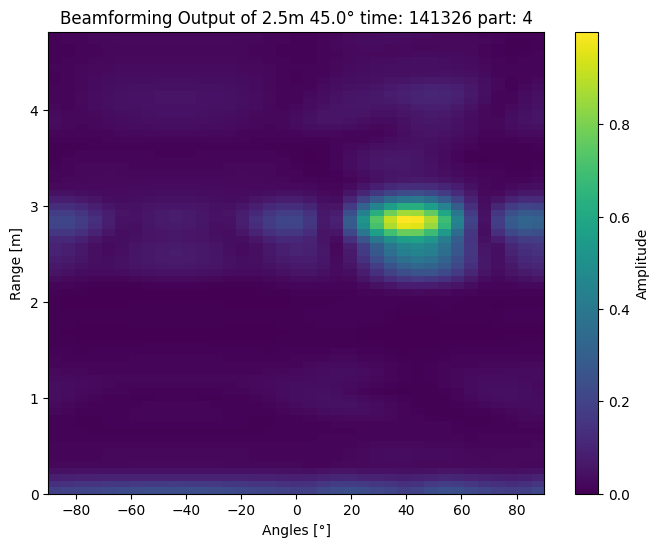

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141326split5.png


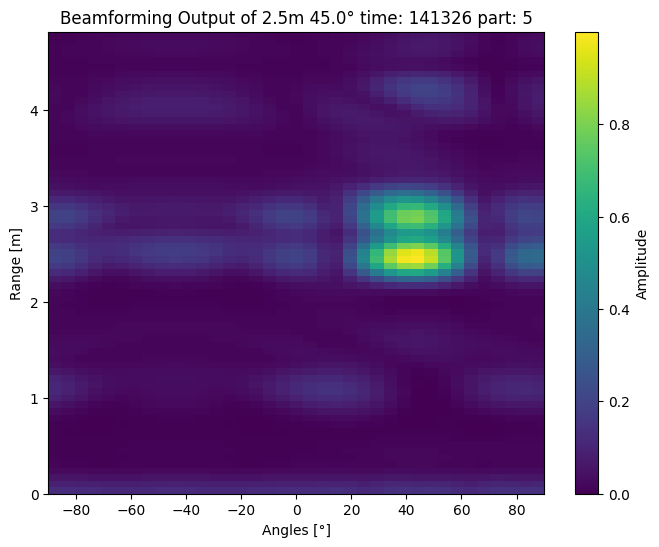

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141805split1.png


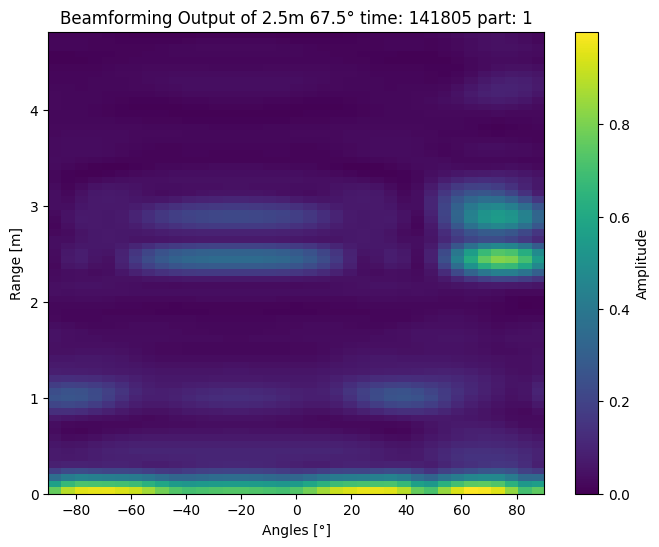

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141805split2.png


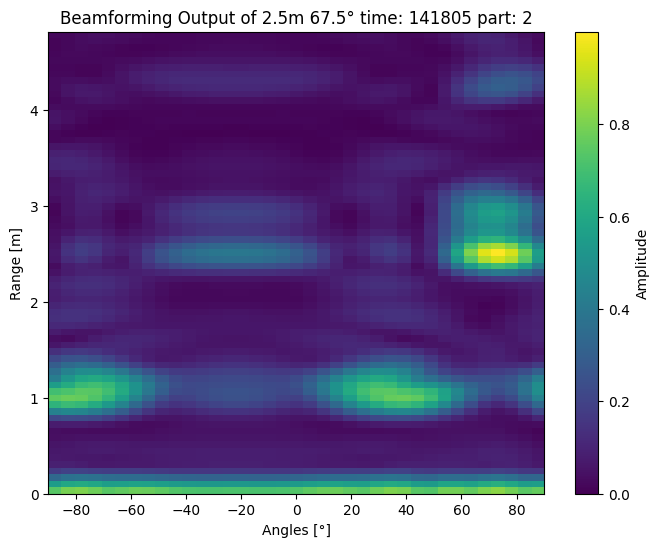

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141805split3.png


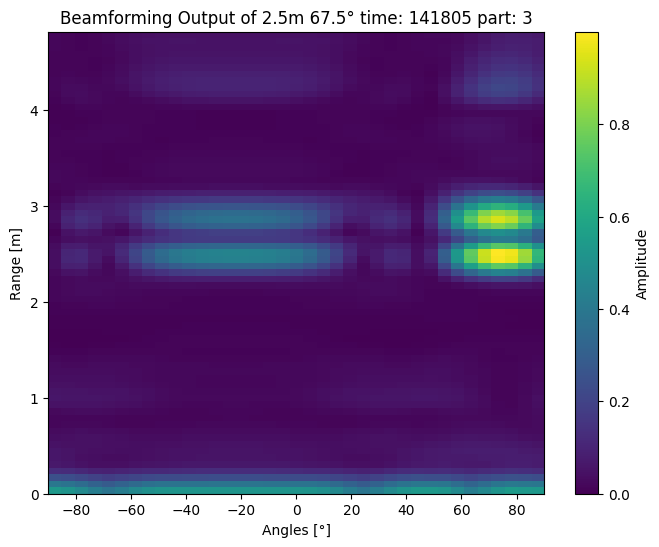

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141805split4.png


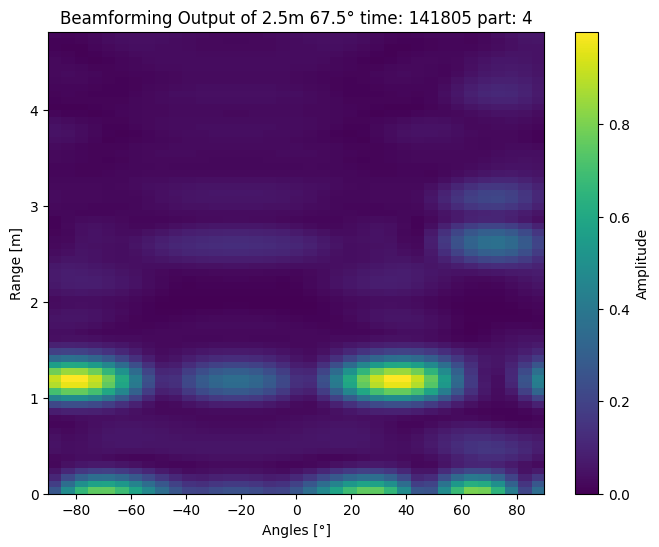

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_141805split5.png


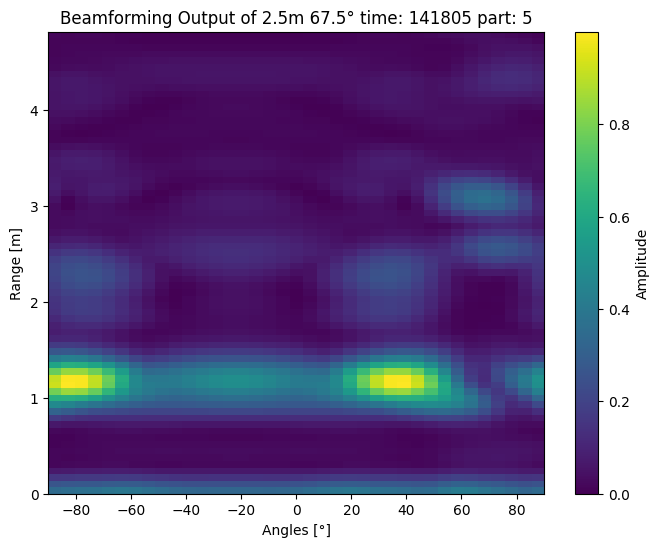

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142129split1.png


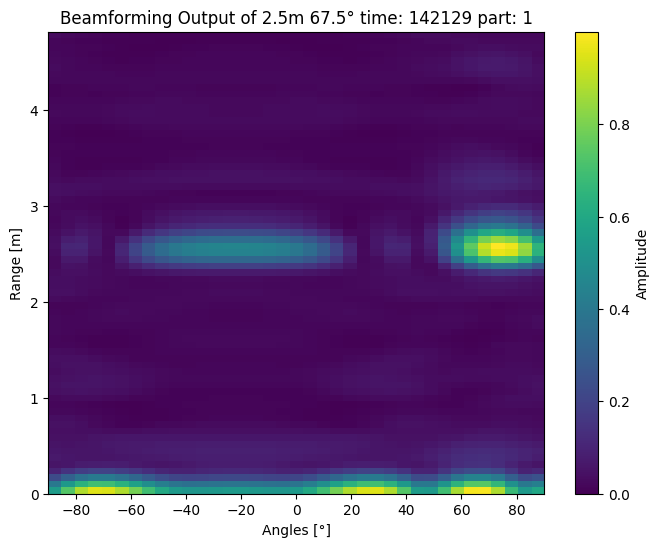

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142129split2.png


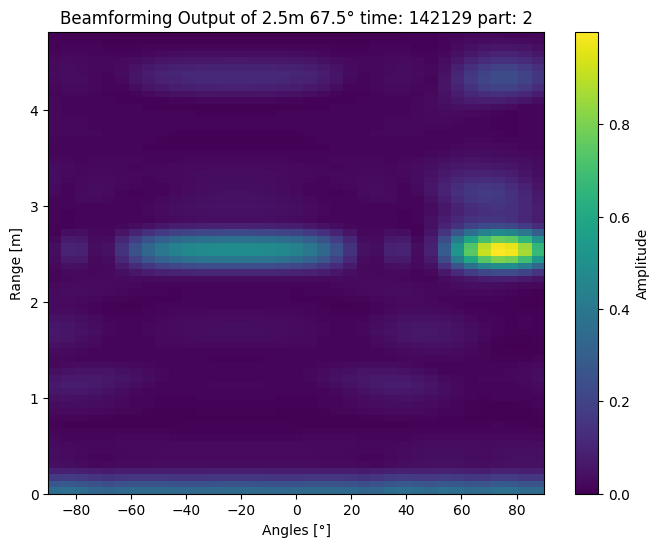

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142129split3.png


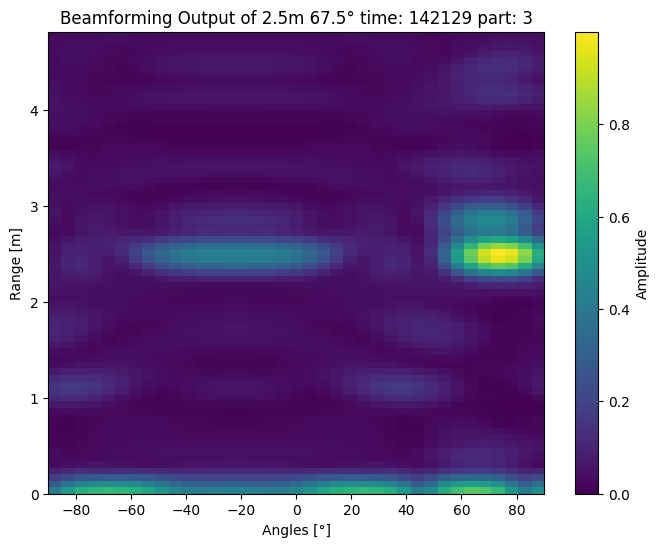

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142129split4.png


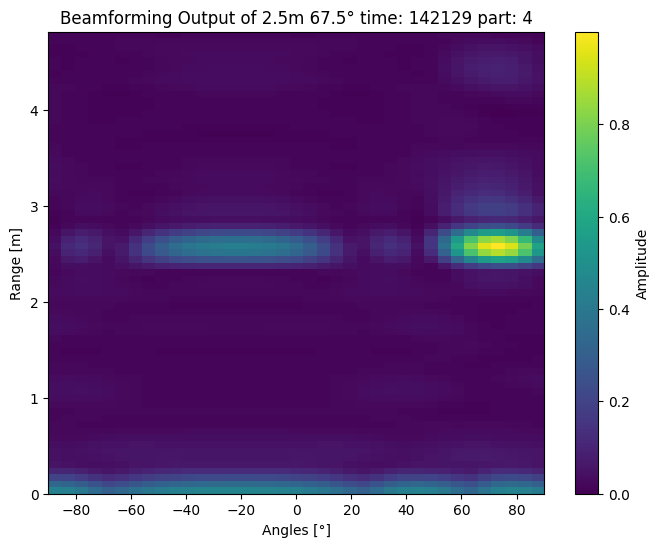

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_67.5deg_142129split5.png


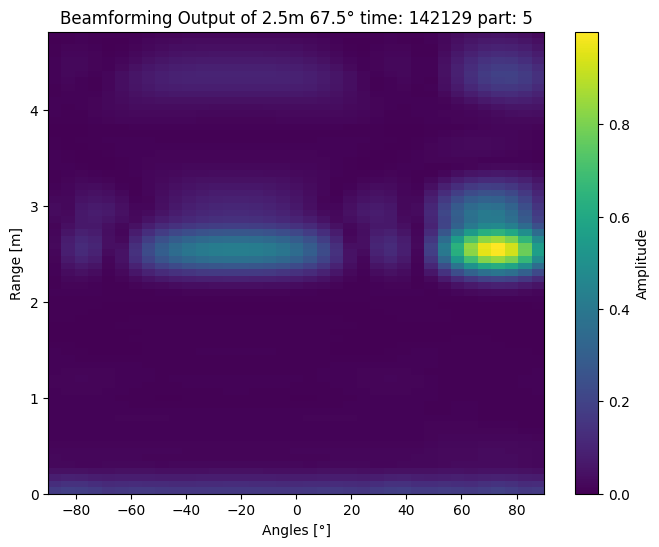

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141436split1.png


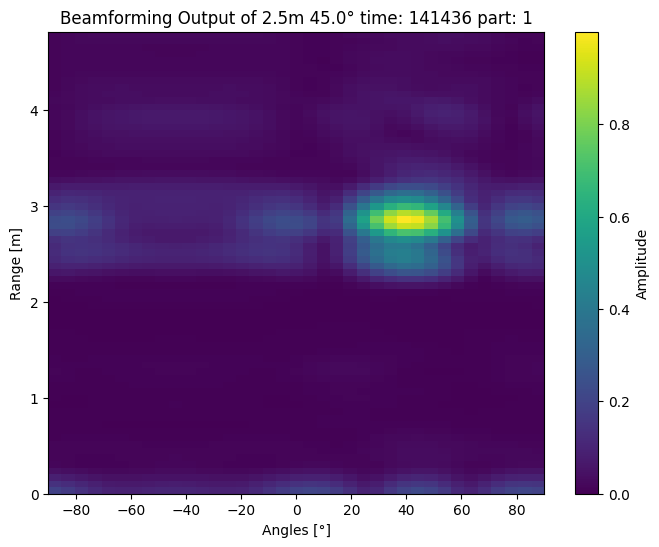

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141436split2.png


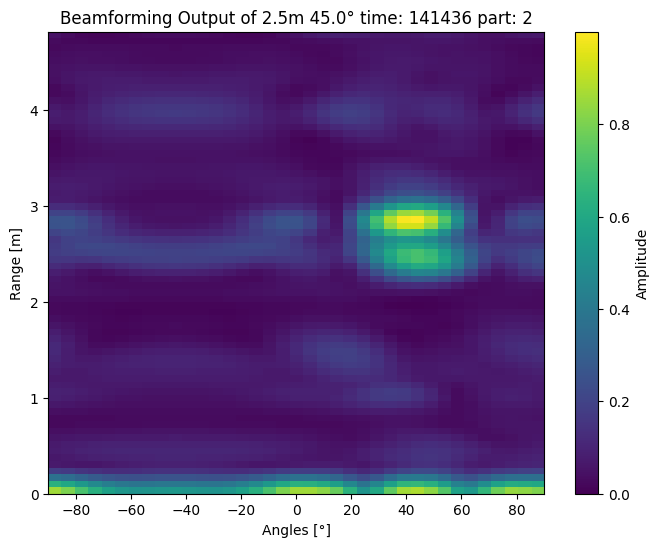

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141436split3.png


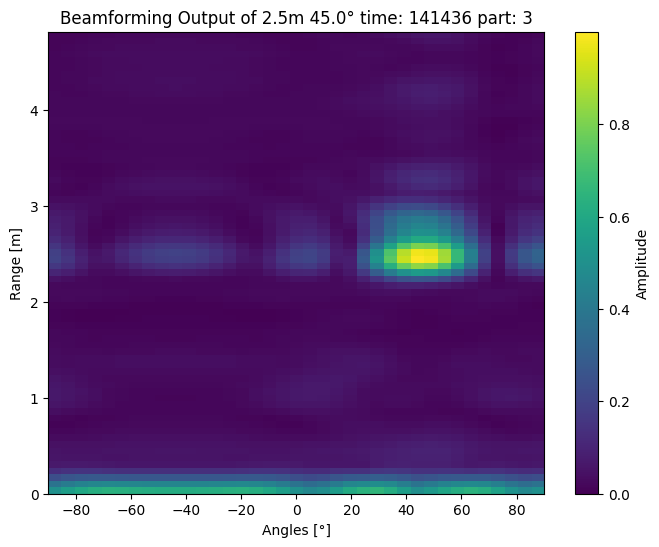

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141436split4.png


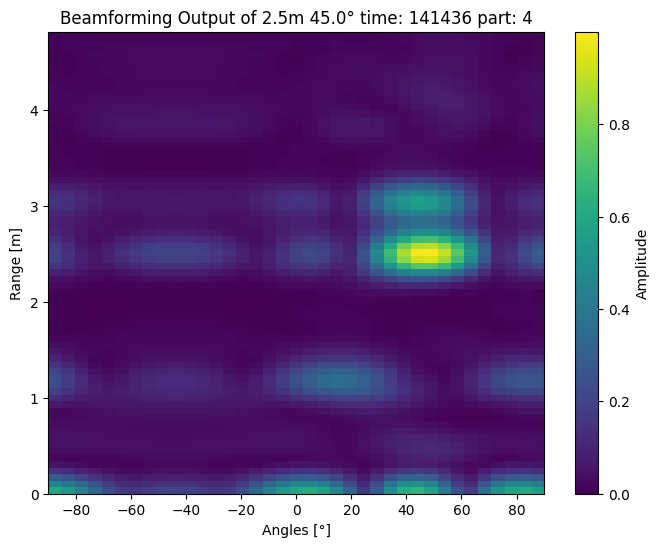

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141436split5.png


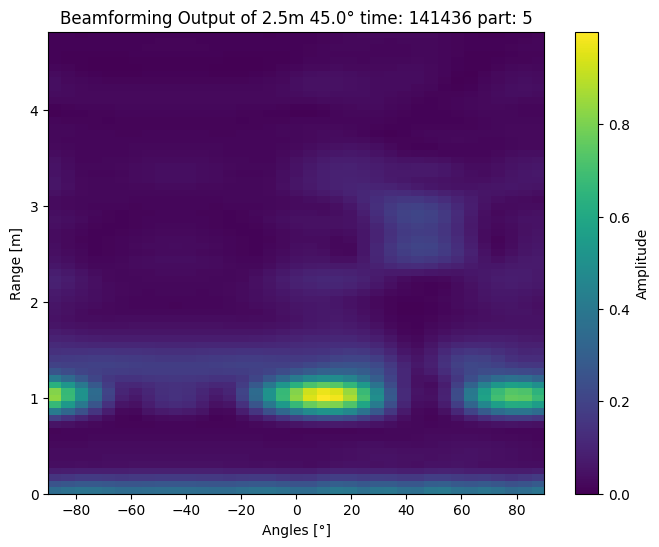

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141217split1.png


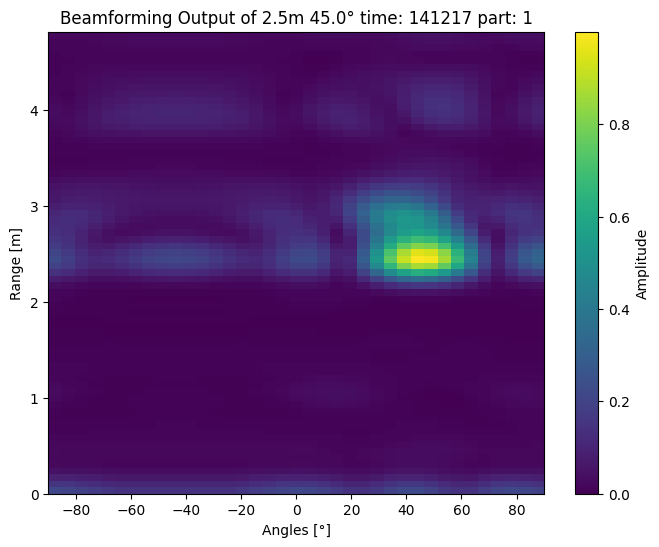

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141217split2.png


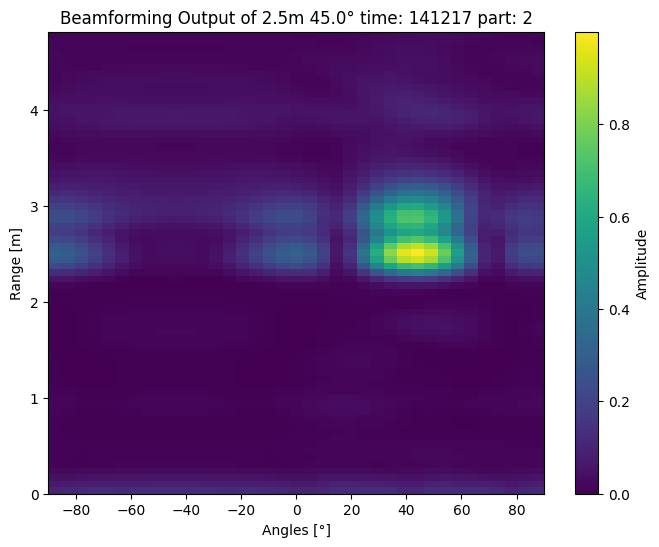

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141217split3.png


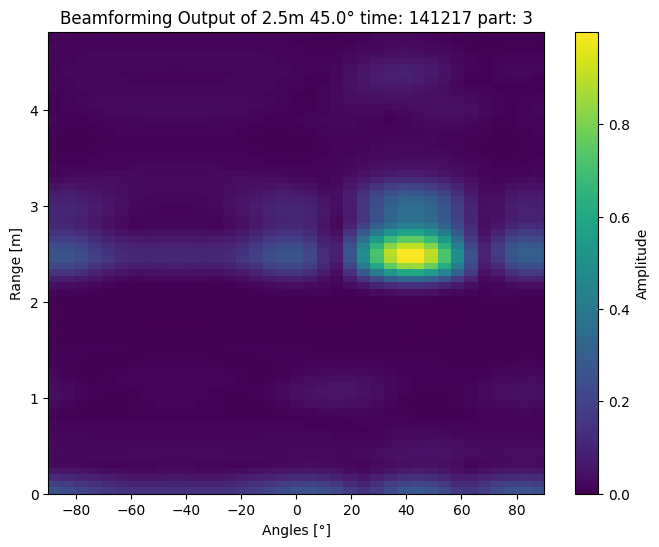

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141217split4.png


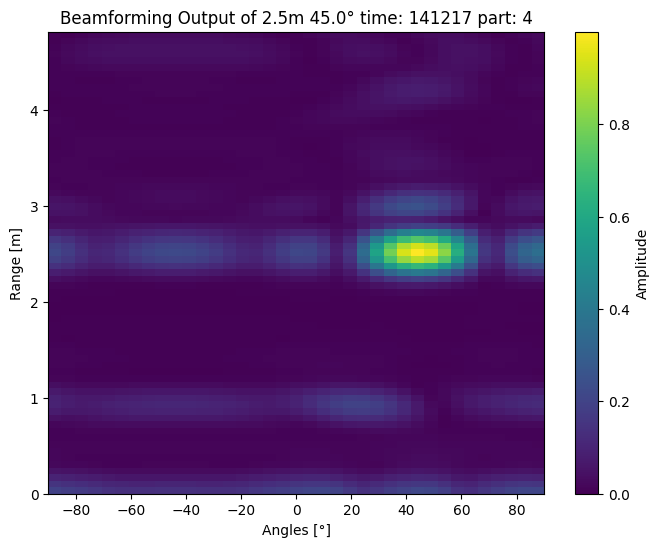

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141217split5.png


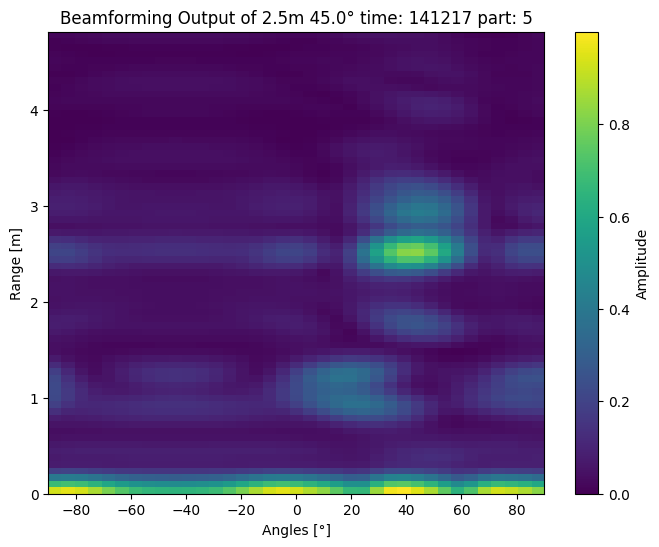

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140031split1.png


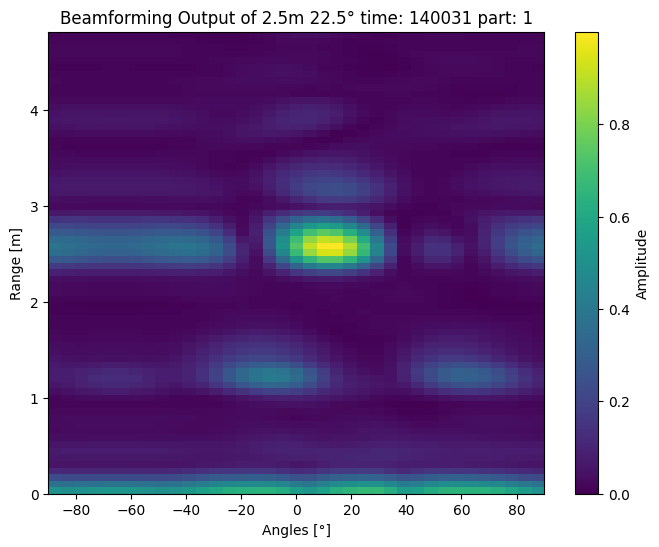

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140031split2.png


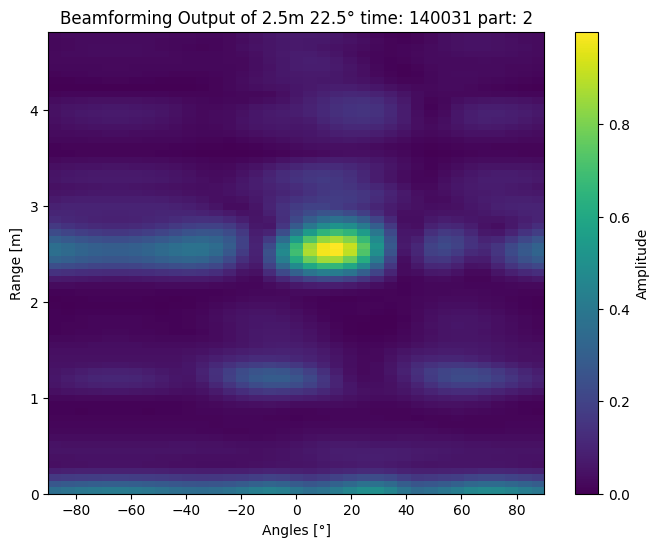

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140031split3.png


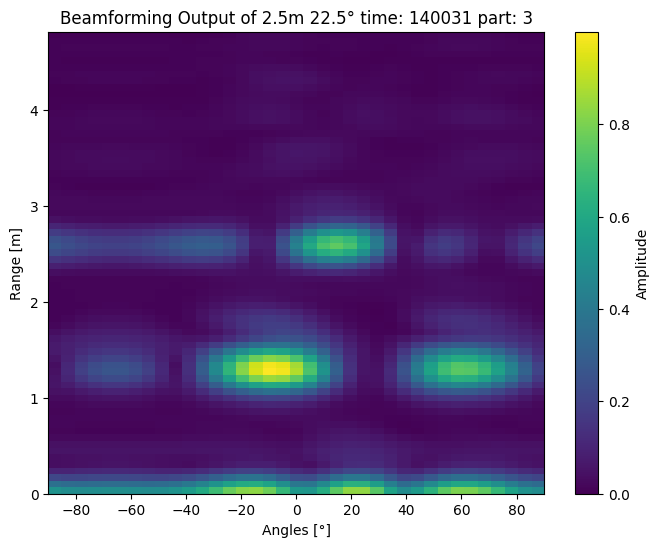

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140031split4.png


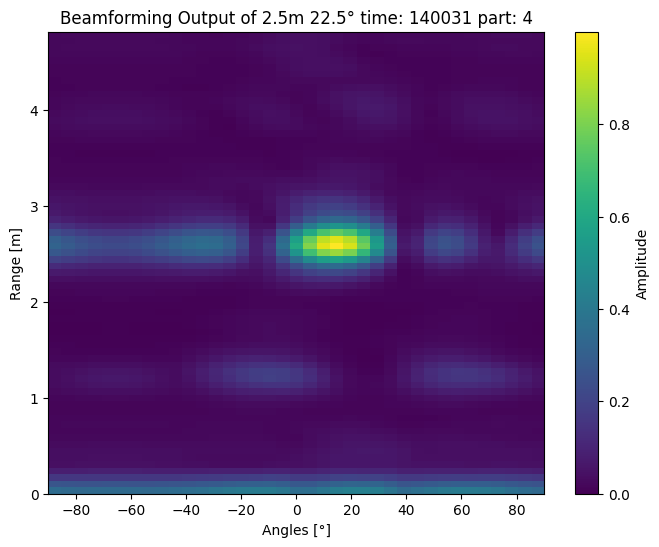

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140031split5.png


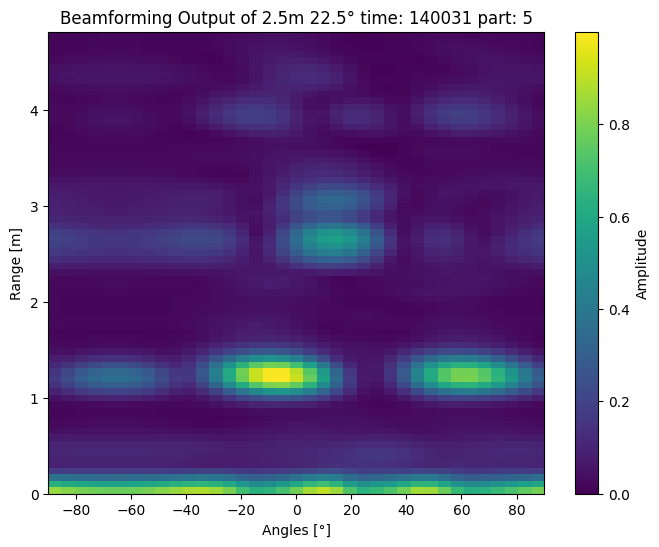

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140535split1.png


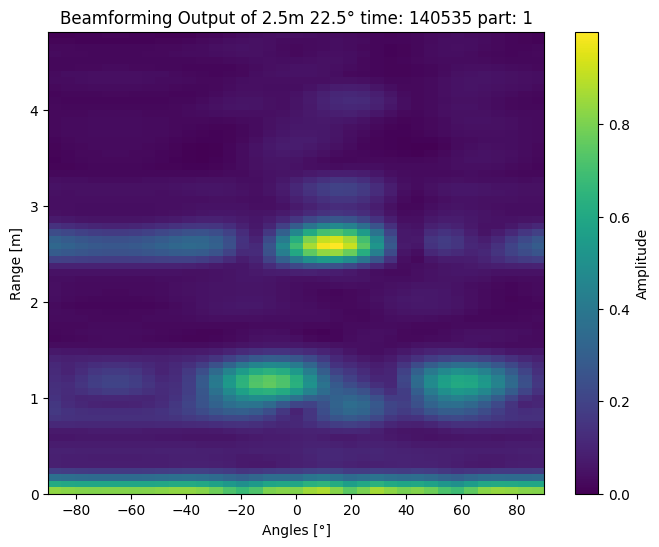

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140535split2.png


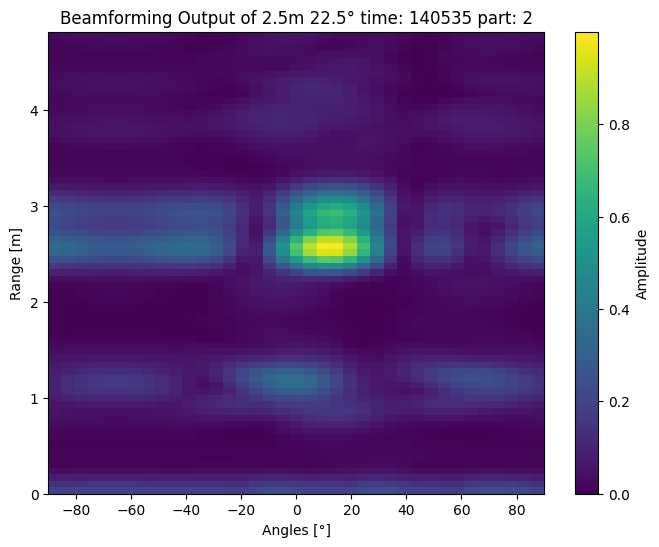

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140535split3.png


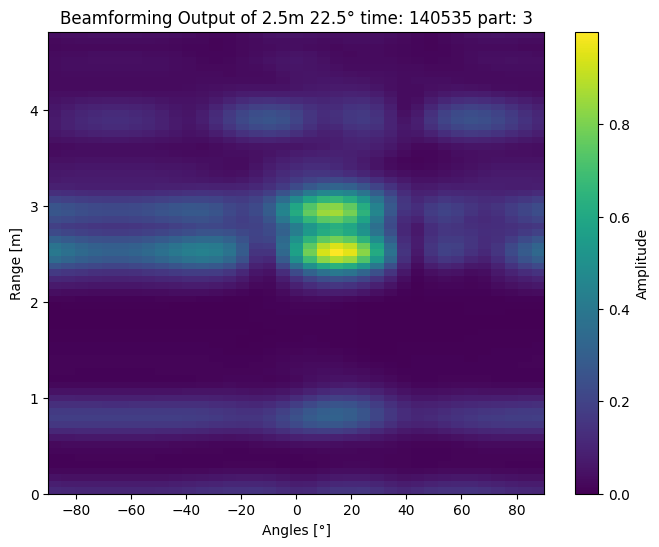

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140535split4.png


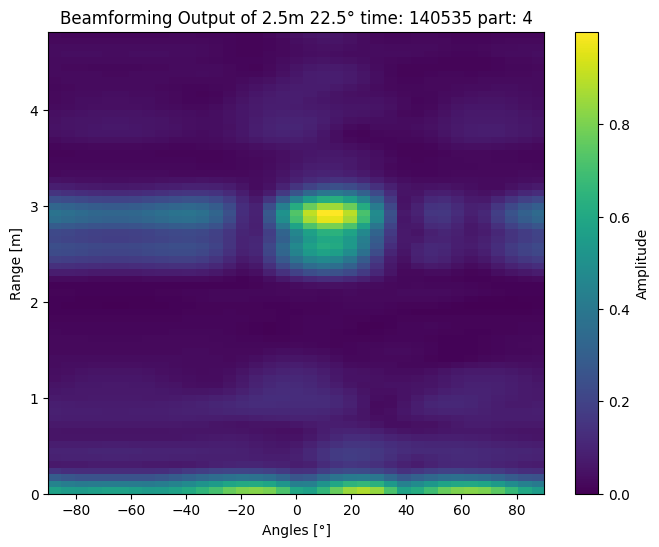

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140535split5.png


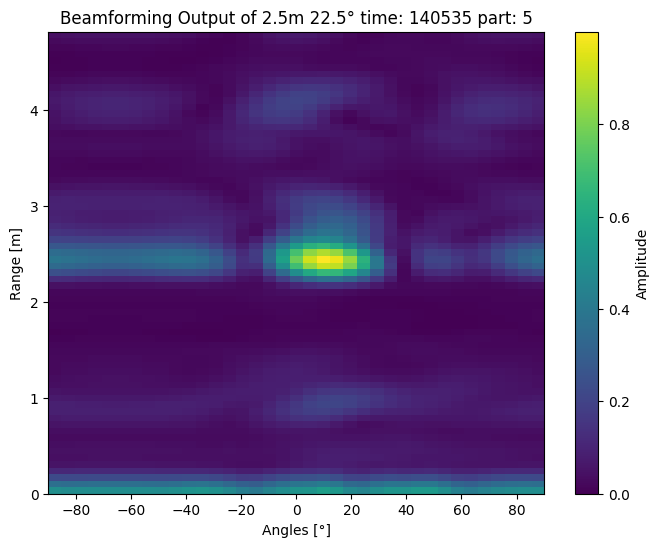

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141000split1.png


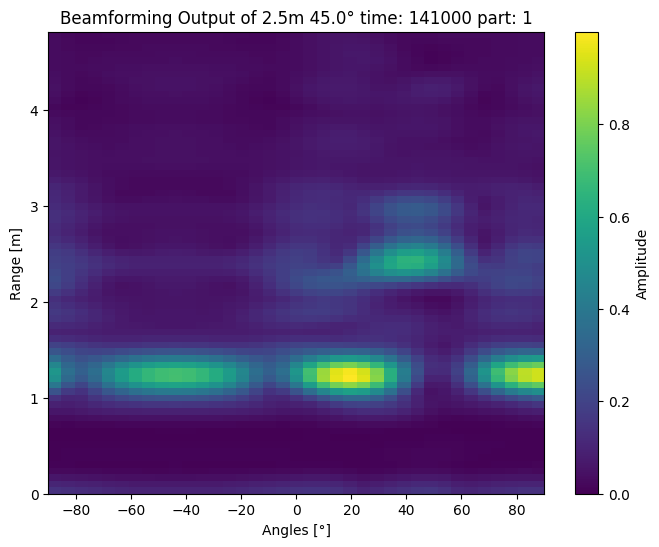

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141000split2.png


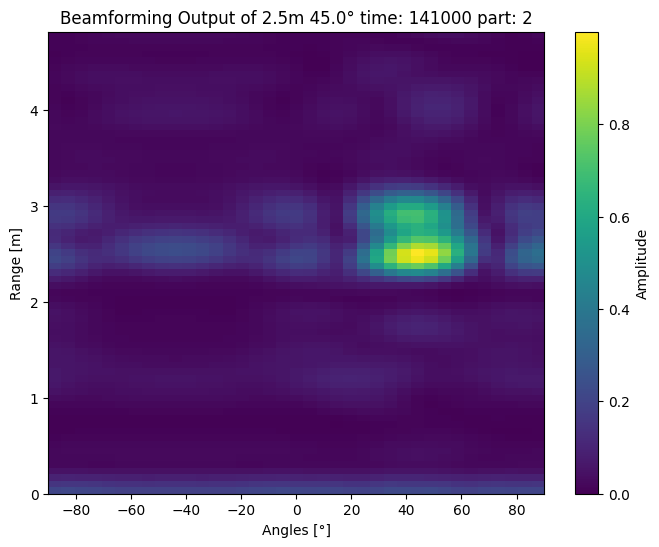

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141000split3.png


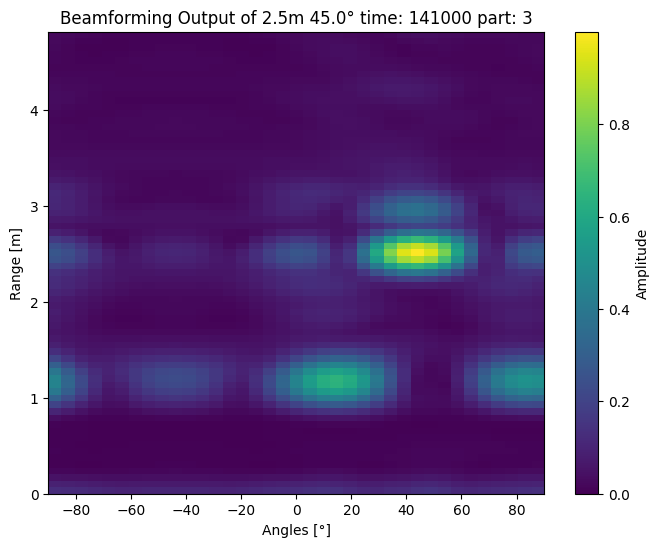

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141000split4.png


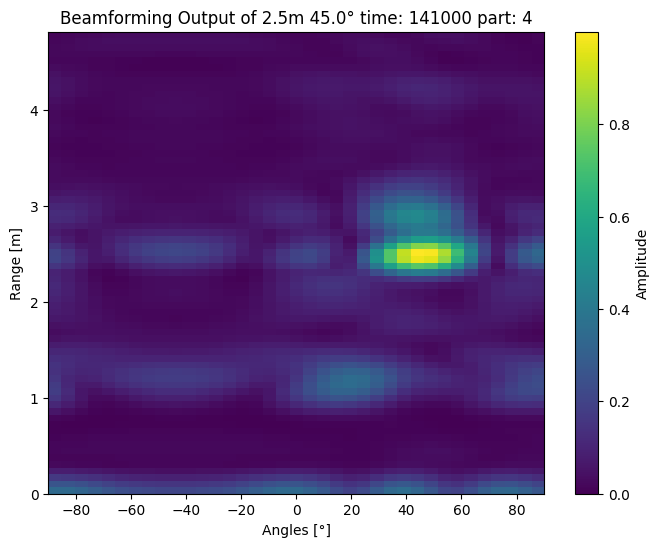

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141000split5.png


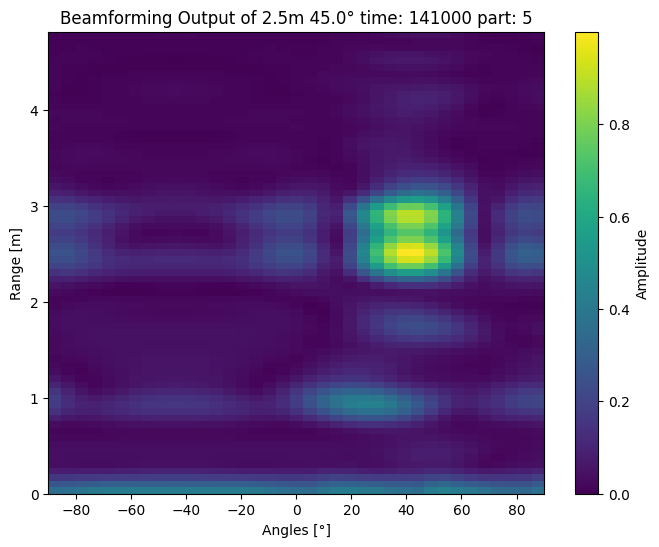

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140358split1.png


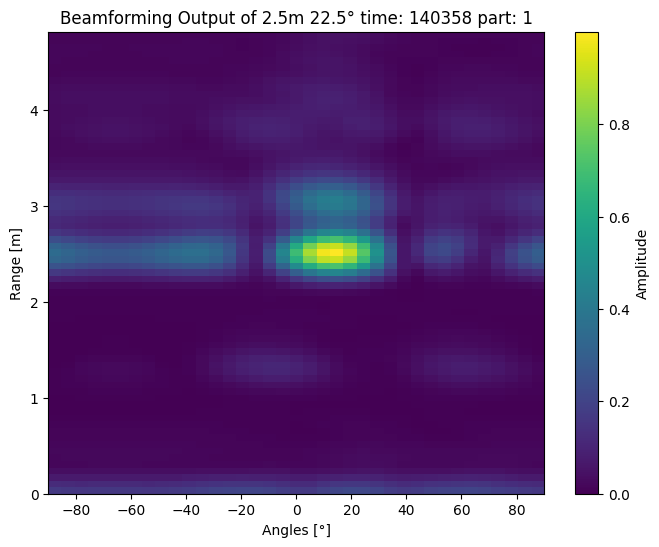

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140358split2.png


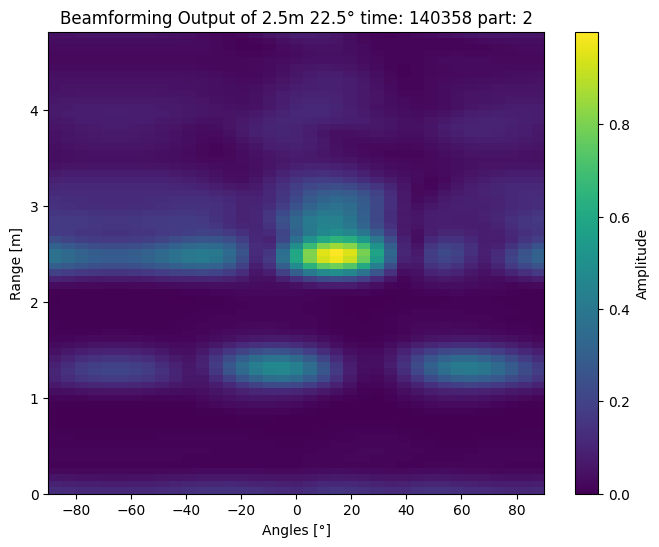

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140358split3.png


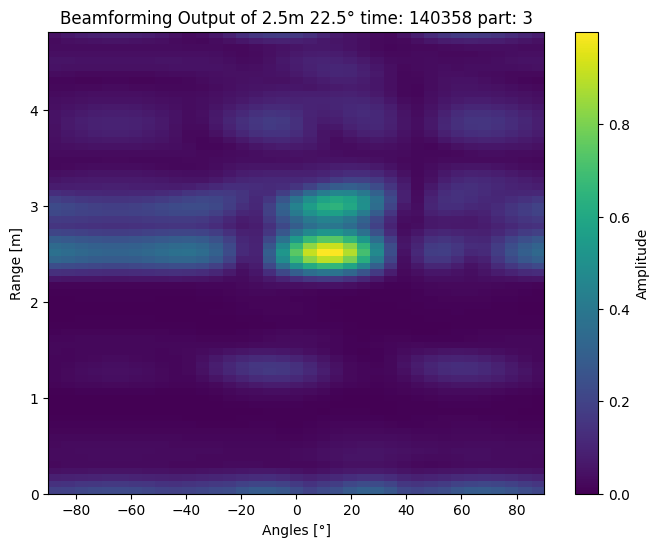

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140358split4.png


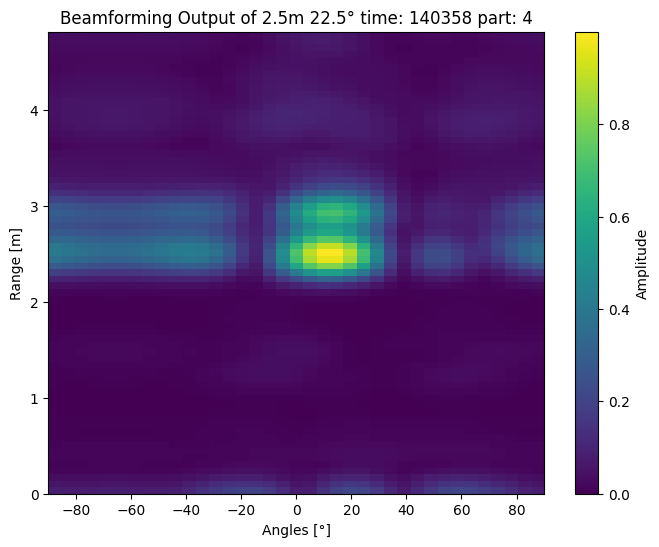

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140358split5.png


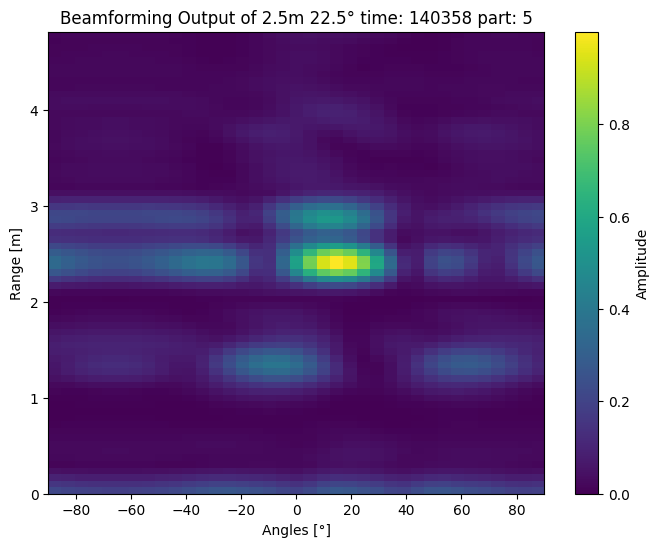

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141109split1.png


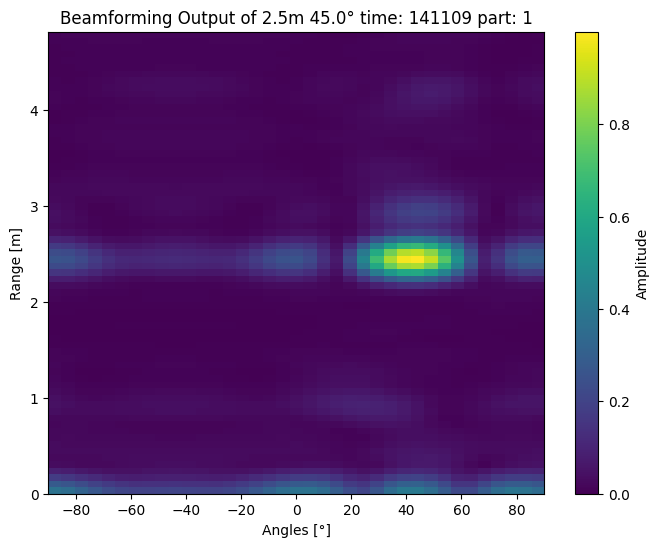

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141109split2.png


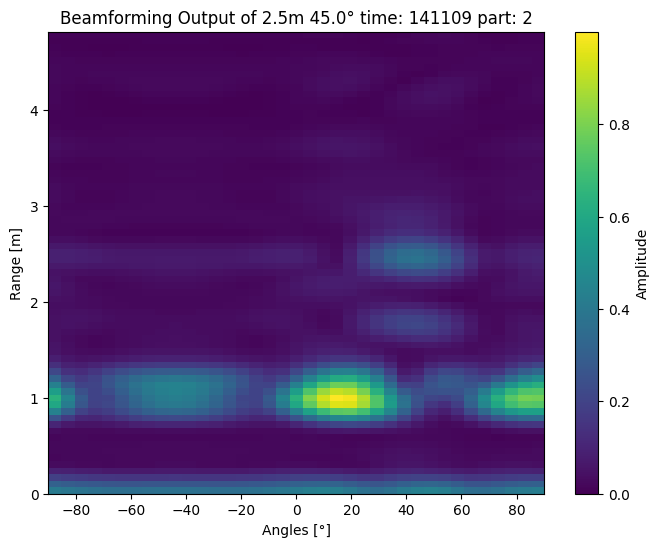

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141109split3.png


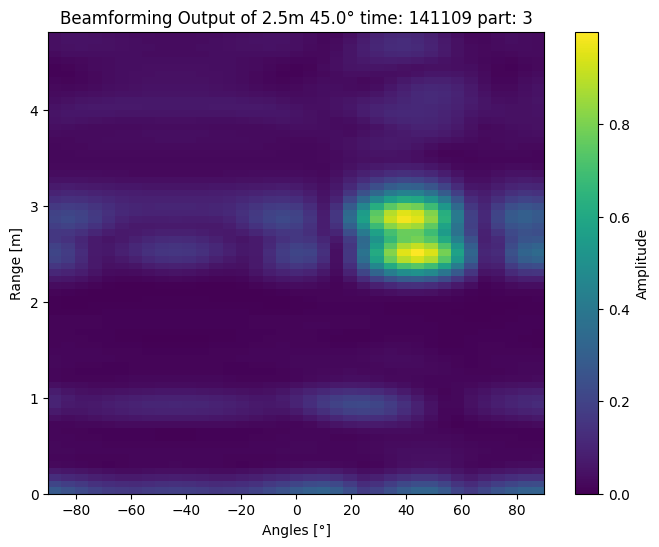

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141109split4.png


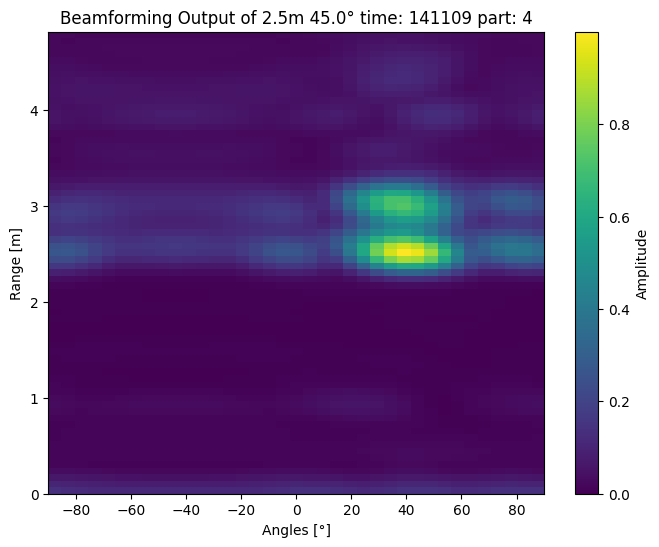

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_45.0deg_141109split5.png


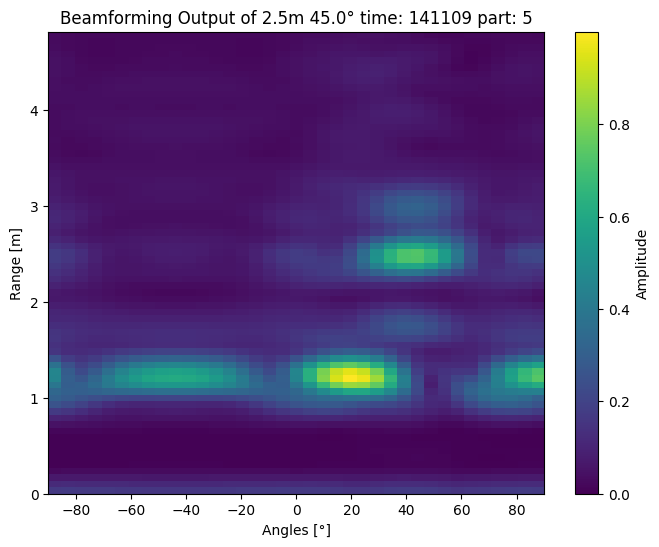

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140249split1.png


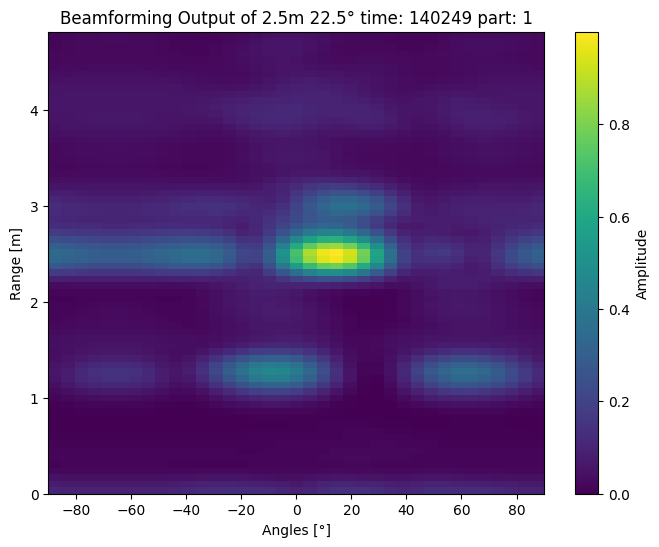

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140249split2.png


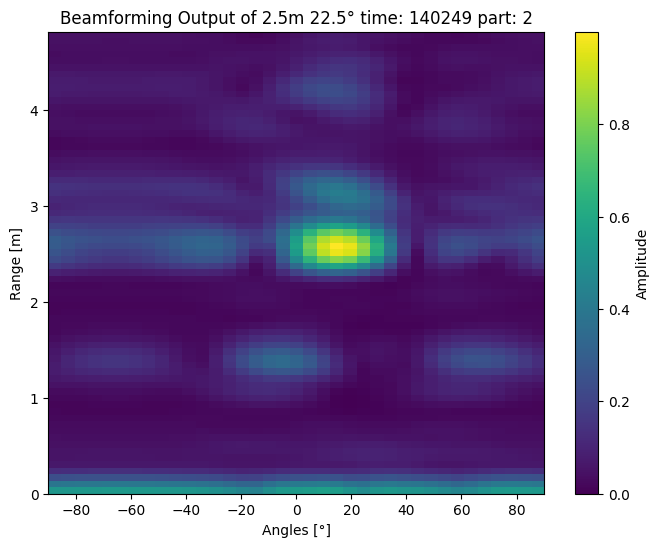

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140249split3.png


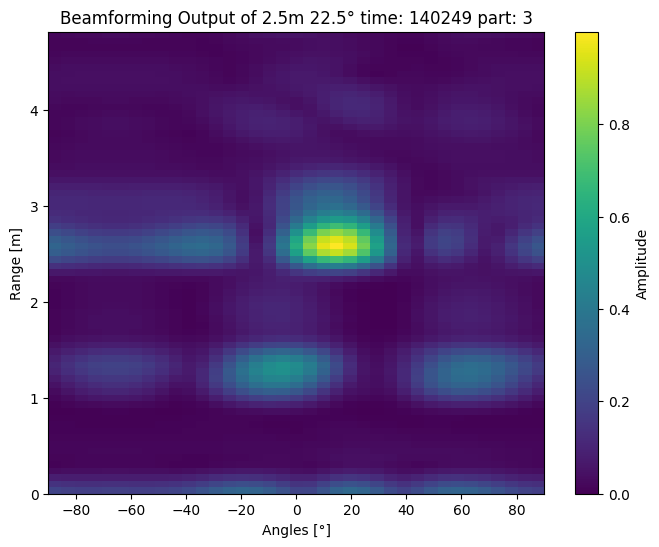

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140249split4.png


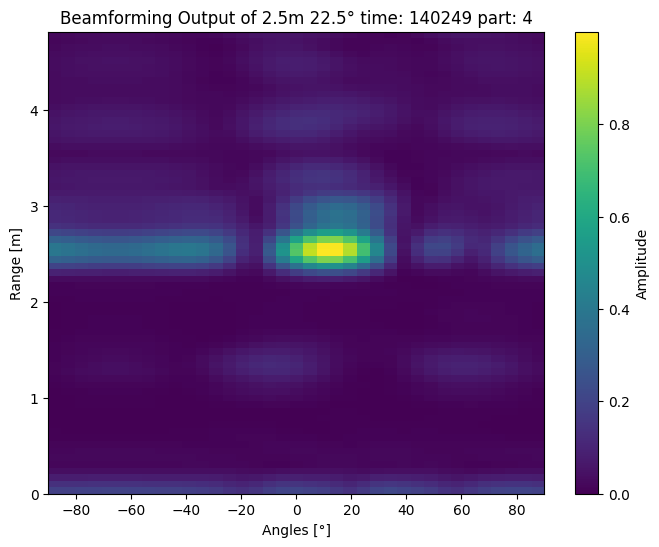

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140249split5.png


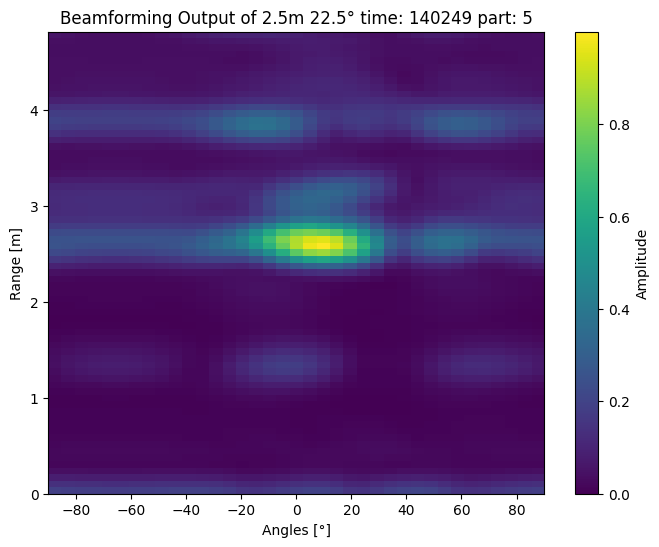

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140140split1.png


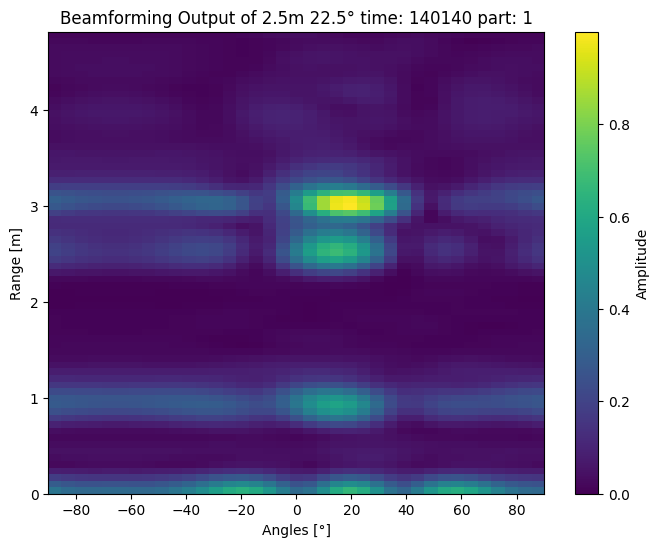

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140140split2.png


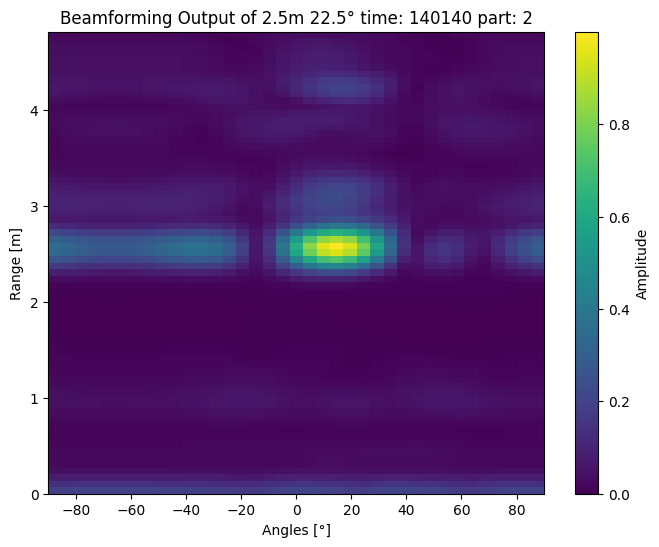

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140140split3.png


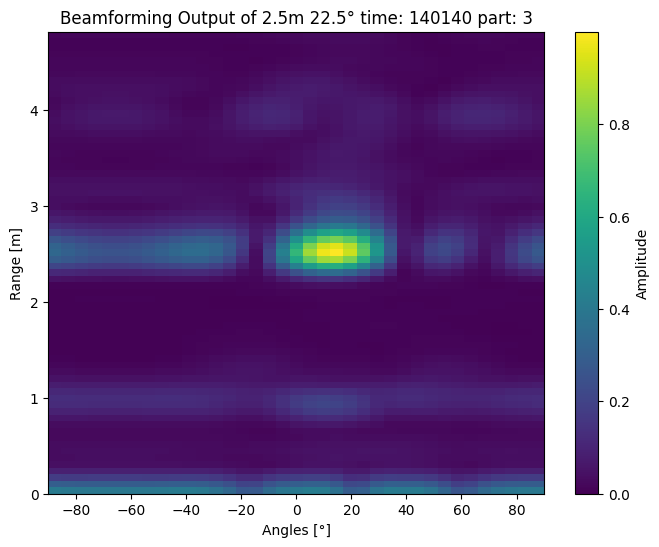

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140140split4.png


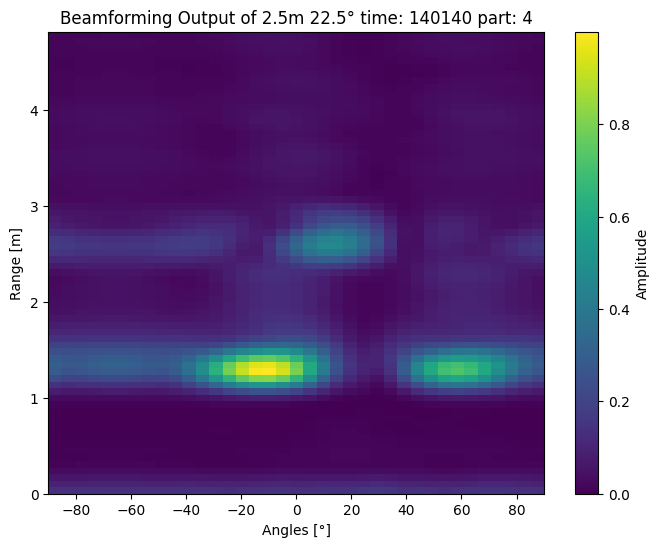

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_250cm_22.5deg_140140split5.png


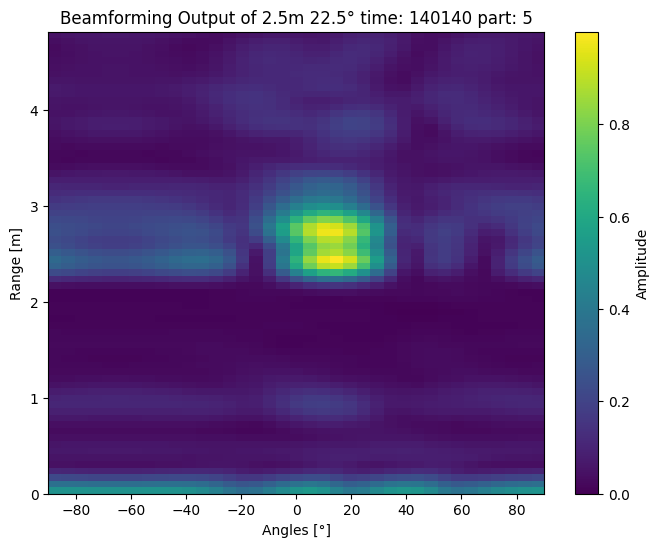

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135625split1.png


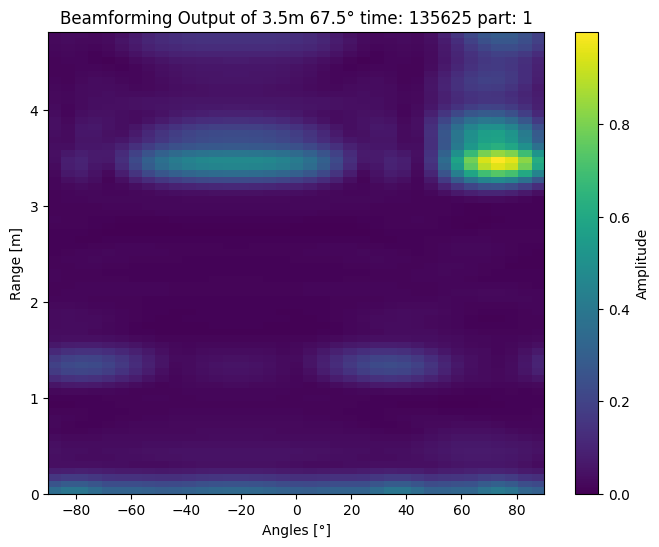

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135625split2.png


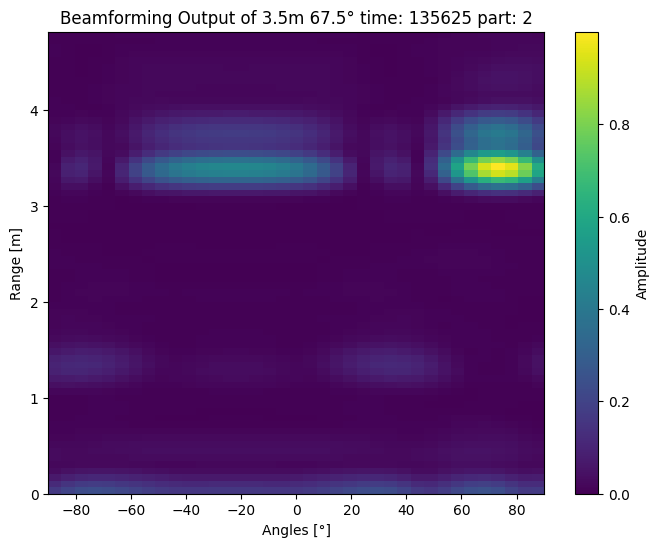

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135625split3.png


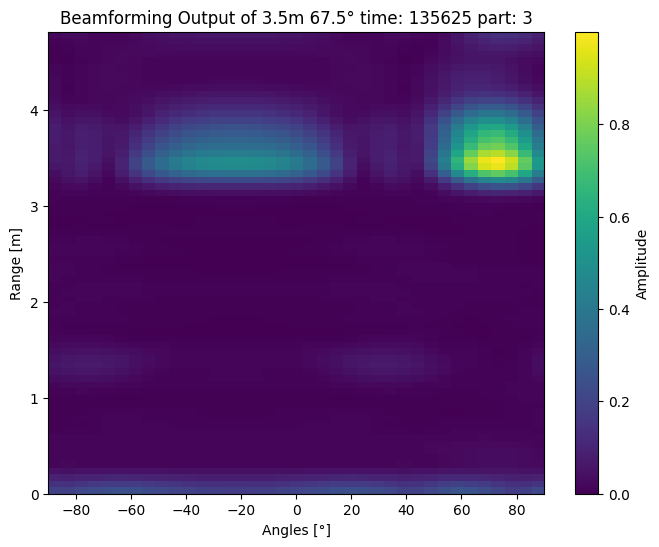

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135625split4.png


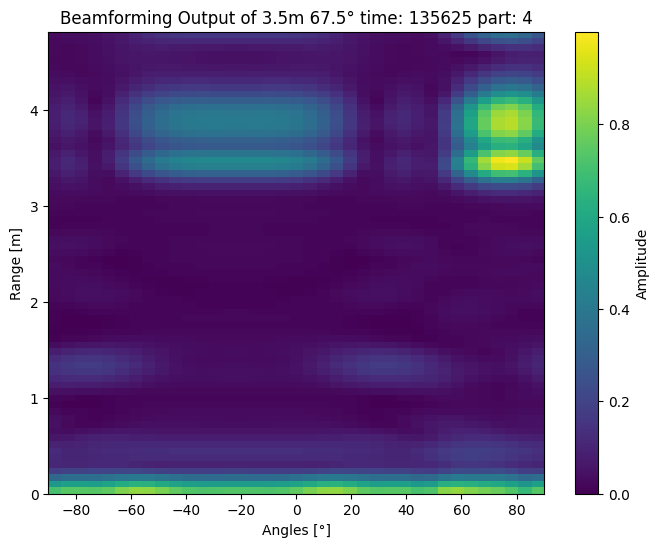

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135625split5.png


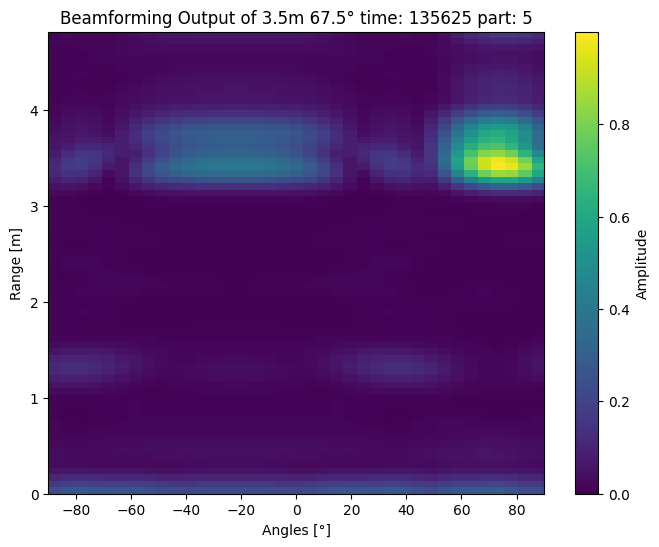

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135518split1.png


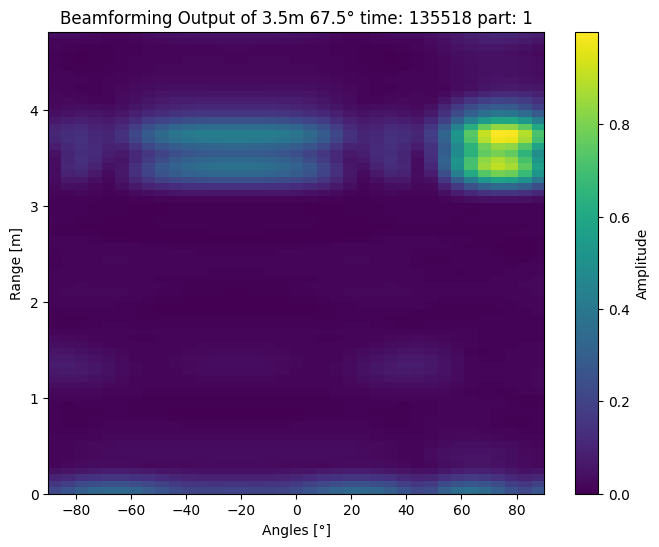

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135518split2.png


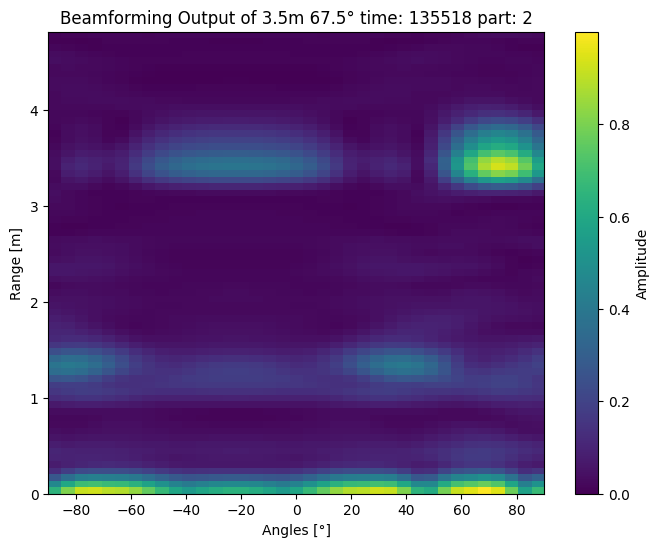

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135518split3.png


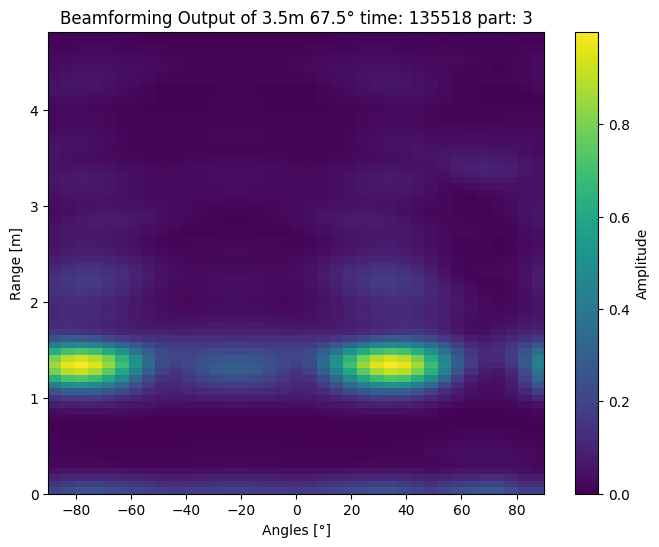

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135518split4.png


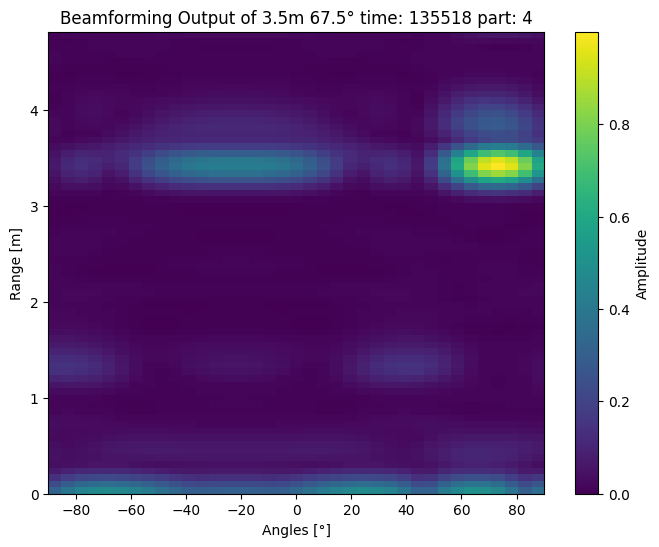

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135518split5.png


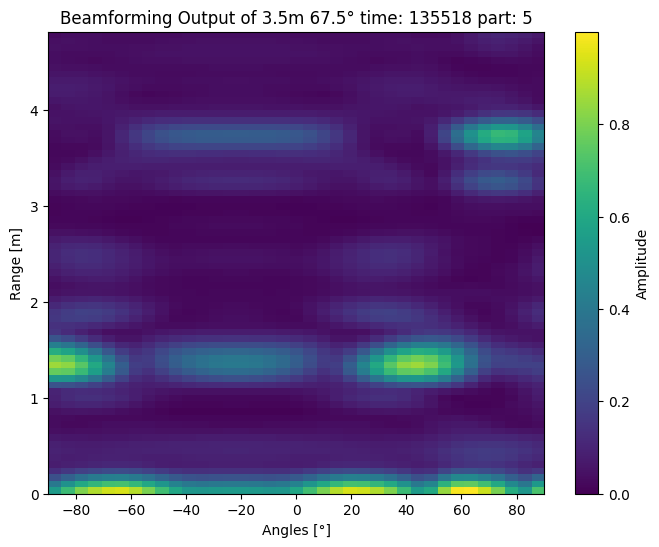

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135249split1.png


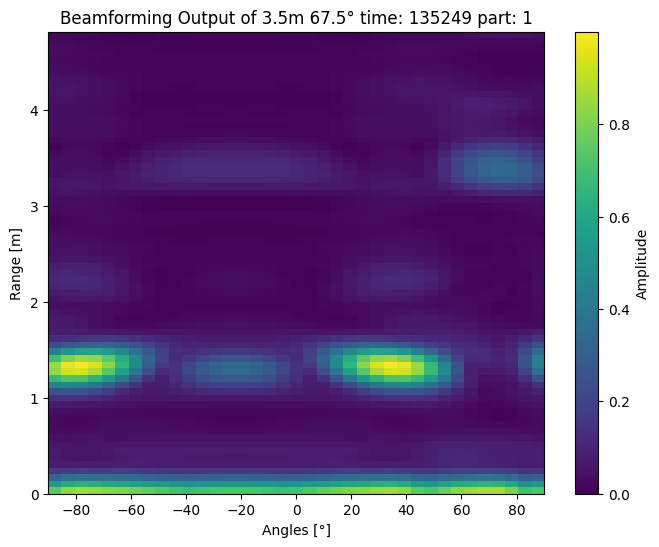

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135249split2.png


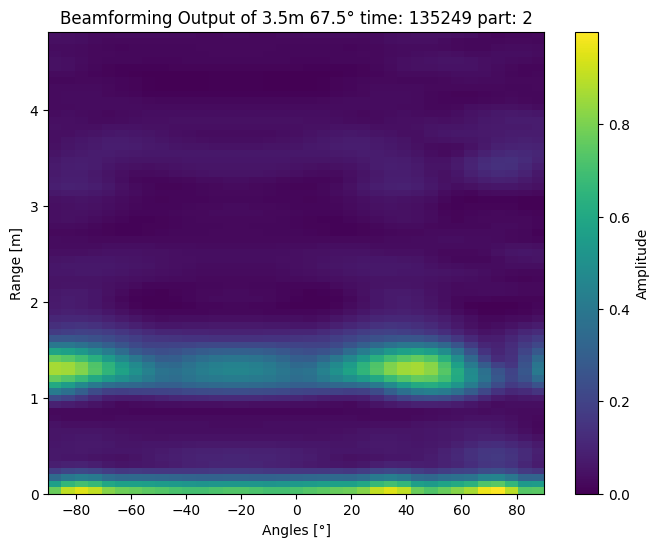

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135249split3.png


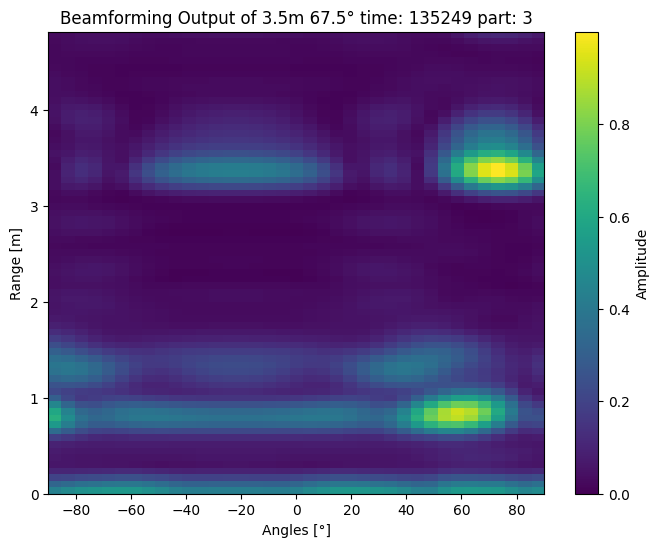

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135249split4.png


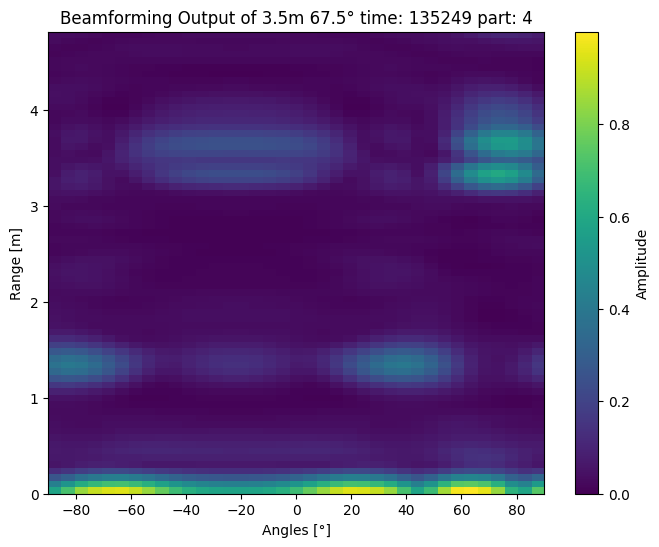

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135249split5.png


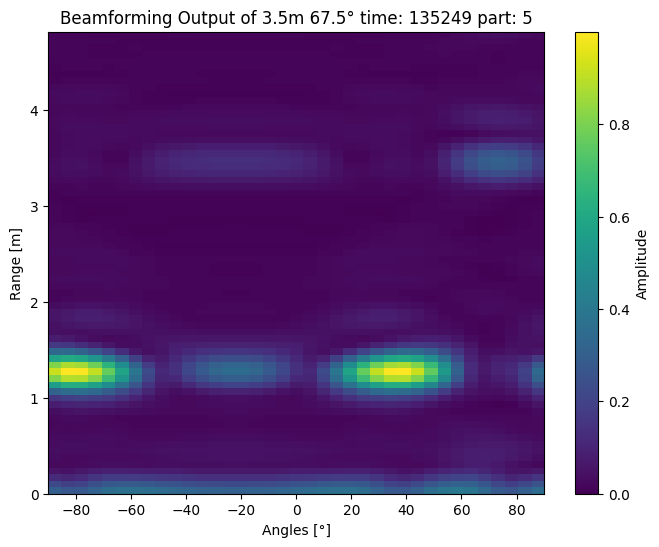

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135411split1.png


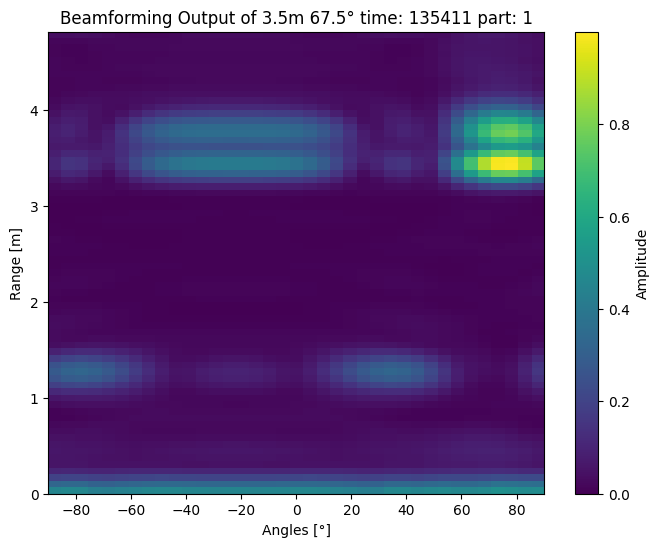

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135411split2.png


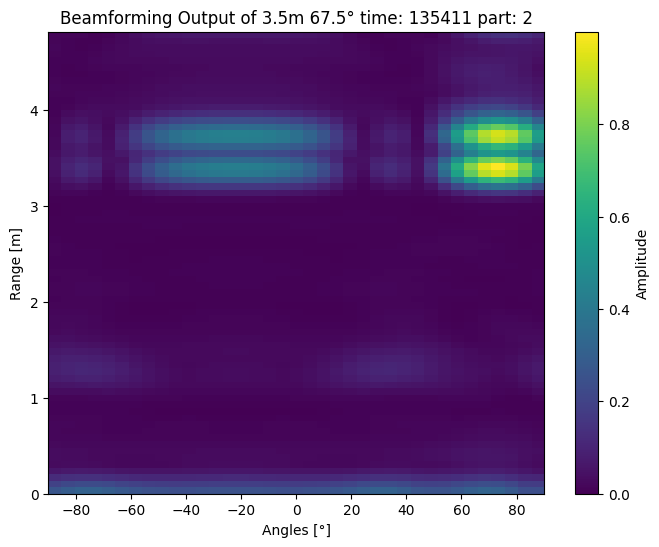

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135411split3.png


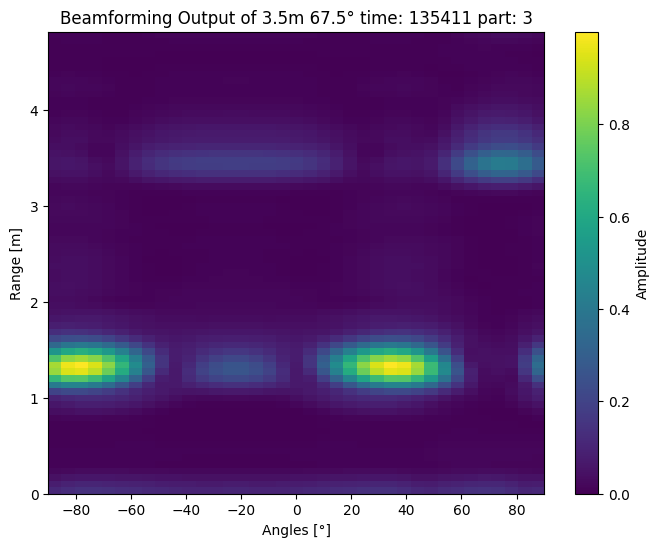

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135411split4.png


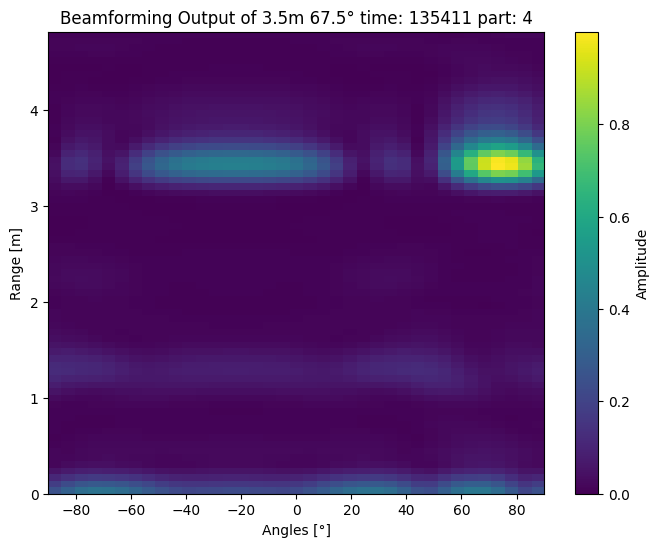

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135411split5.png


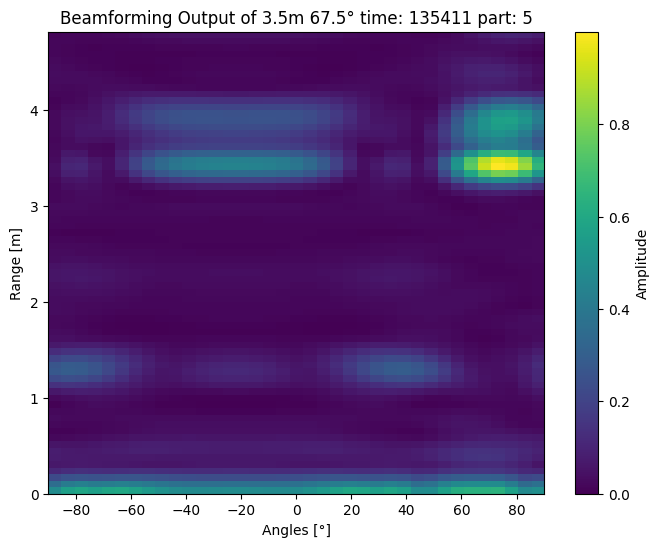

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_135031split1.png


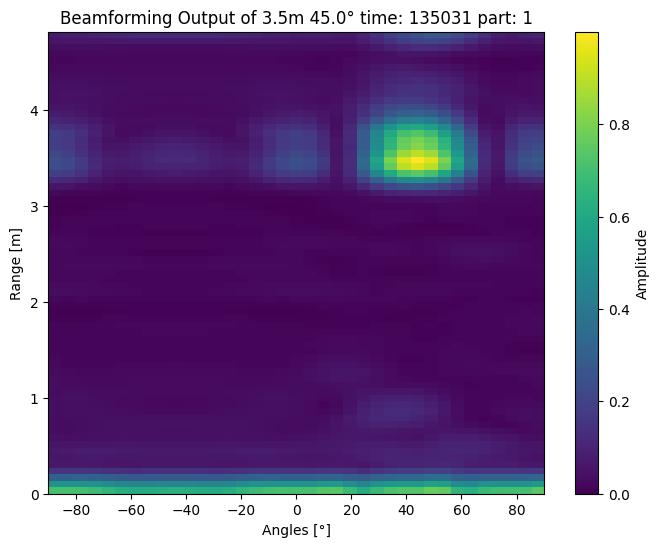

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_135031split2.png


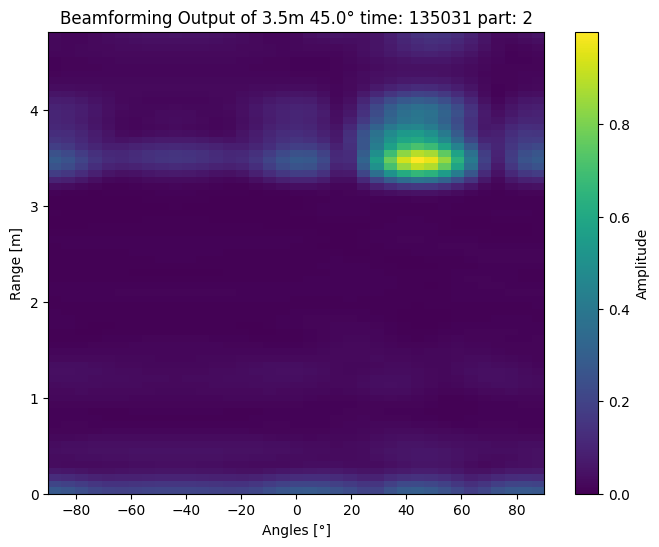

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_135031split3.png


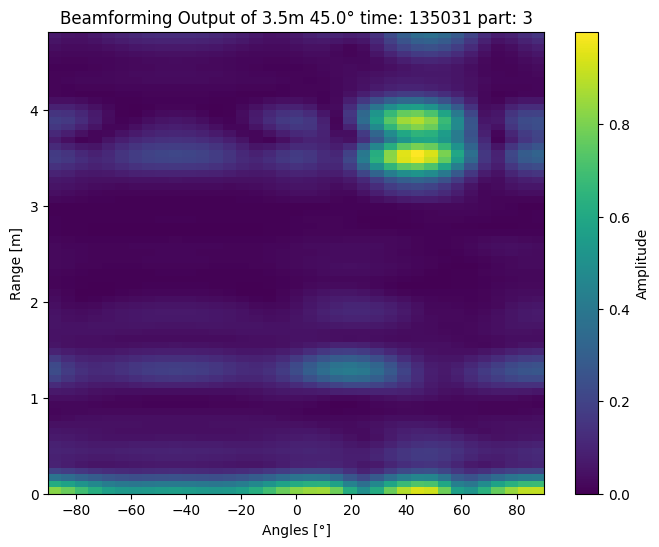

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_135031split4.png


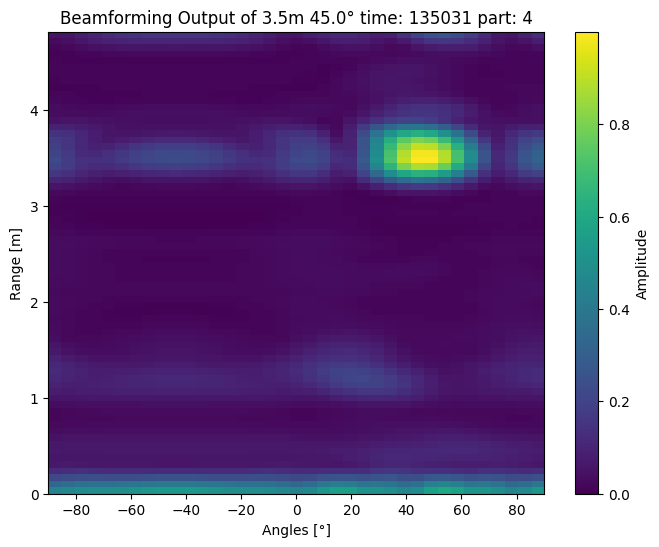

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_135031split5.png


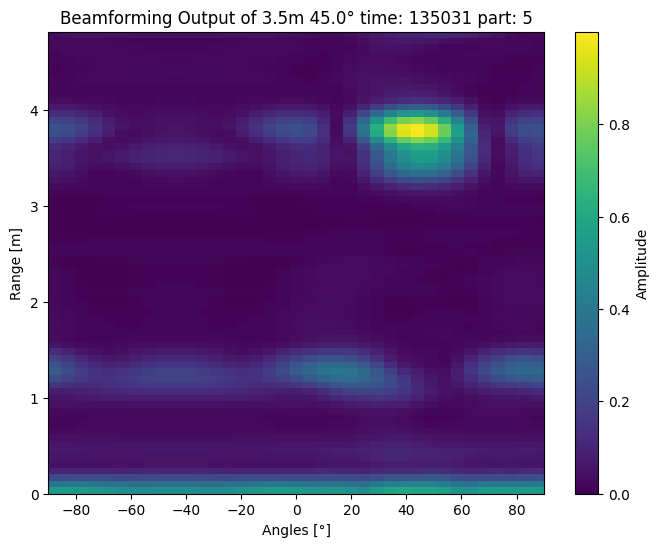

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135142split1.png


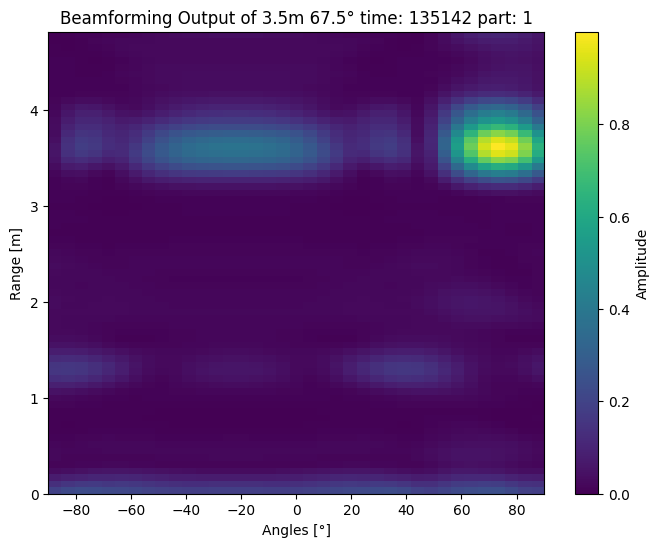

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135142split2.png


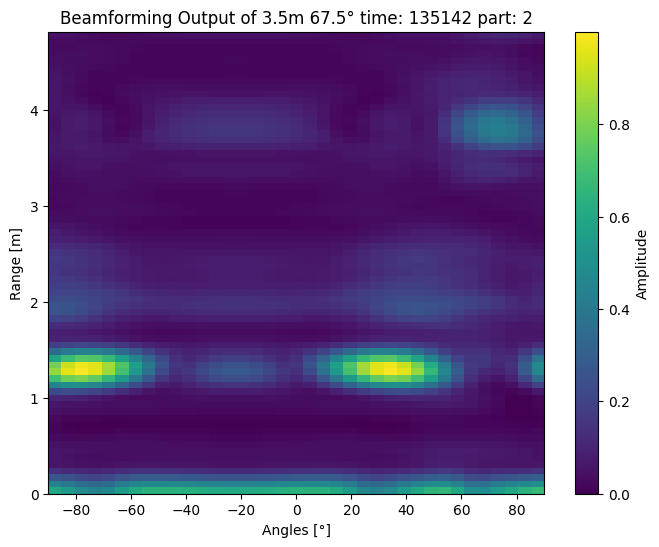

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135142split3.png


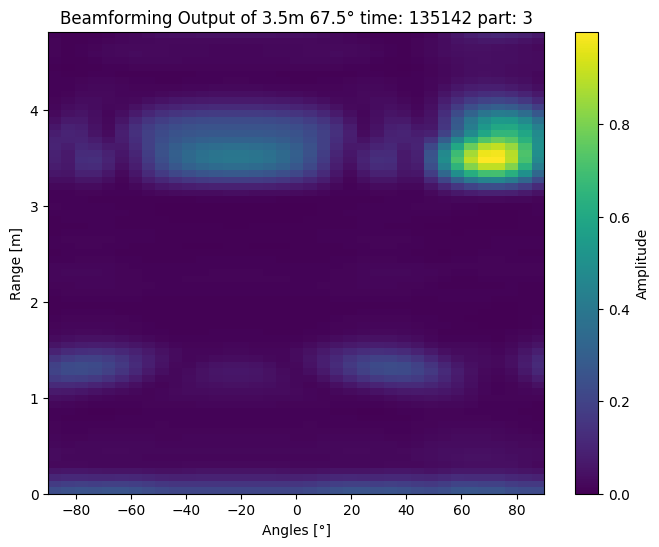

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135142split4.png


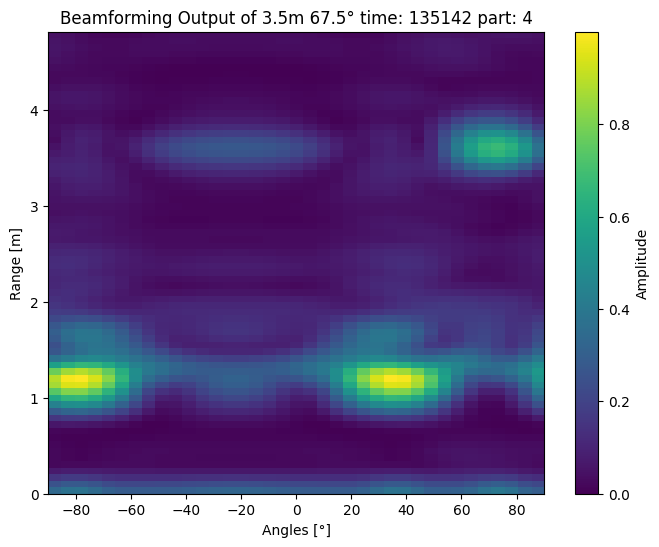

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_67.5deg_135142split5.png


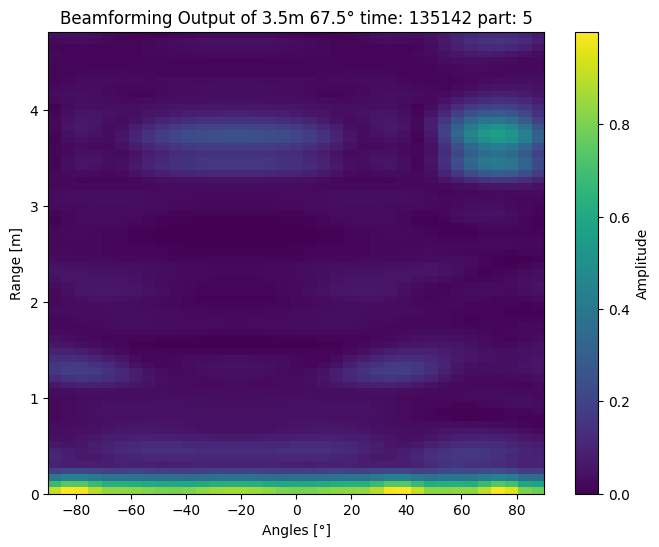

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134722split1.png


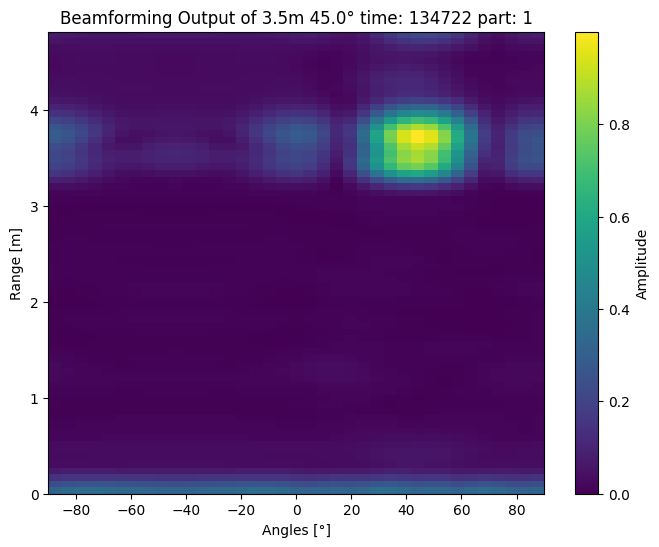

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134722split2.png


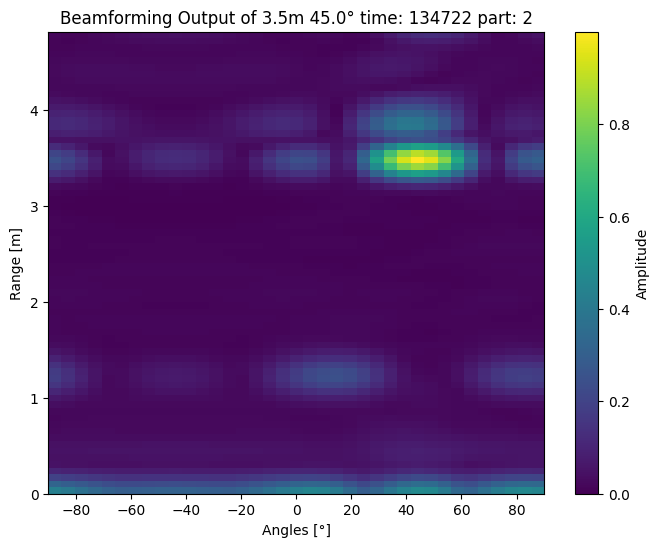

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134722split3.png


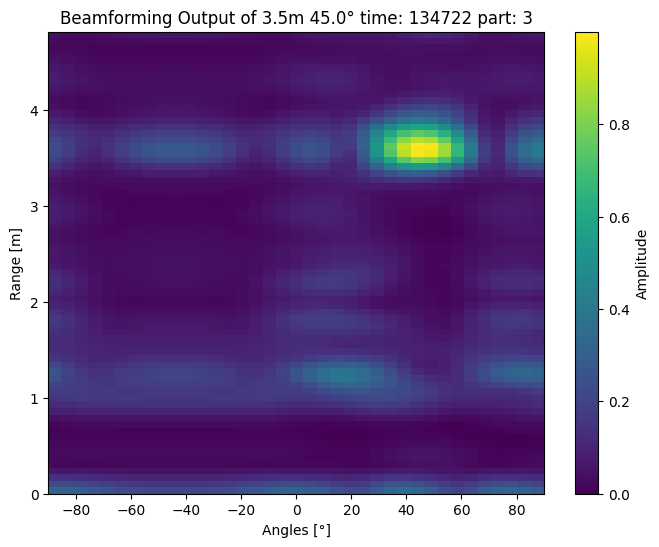

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134722split4.png


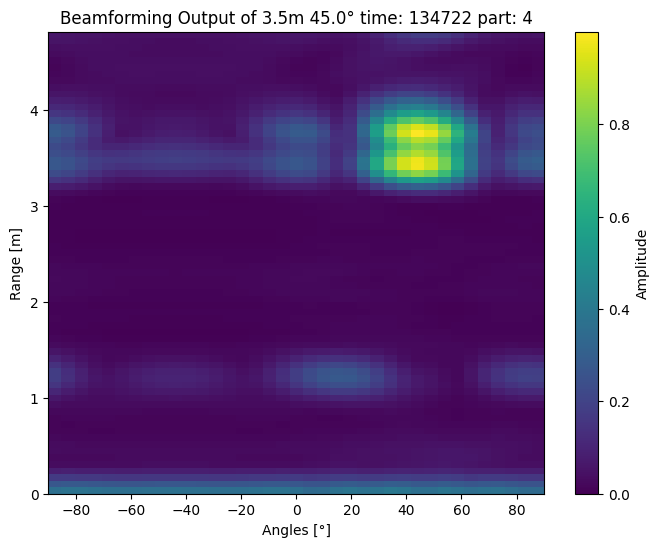

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134722split5.png


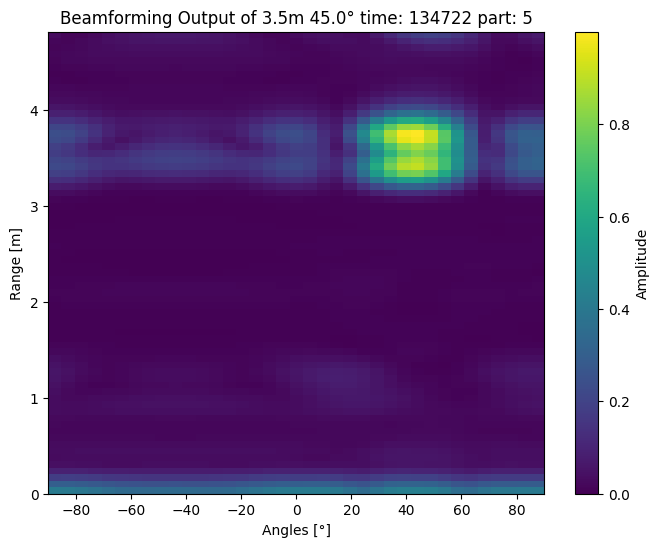

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134610split1.png


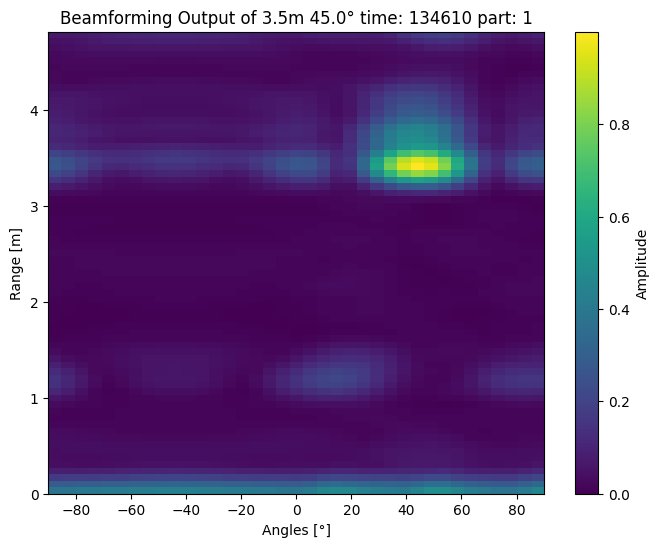

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134610split2.png


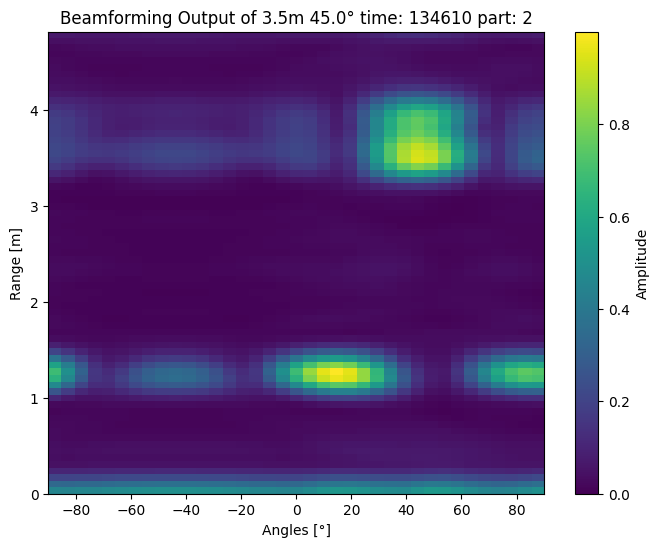

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134610split3.png


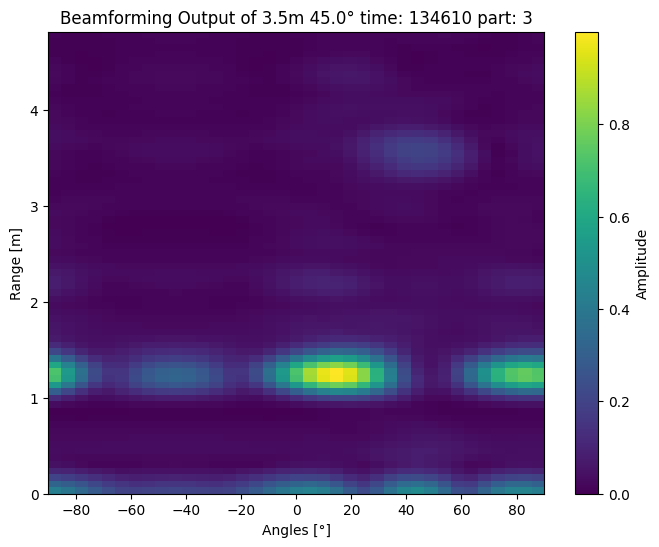

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134610split4.png


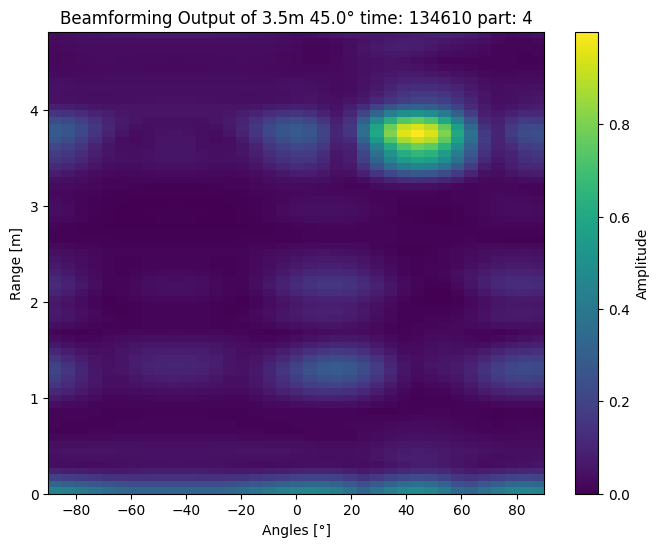

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134610split5.png


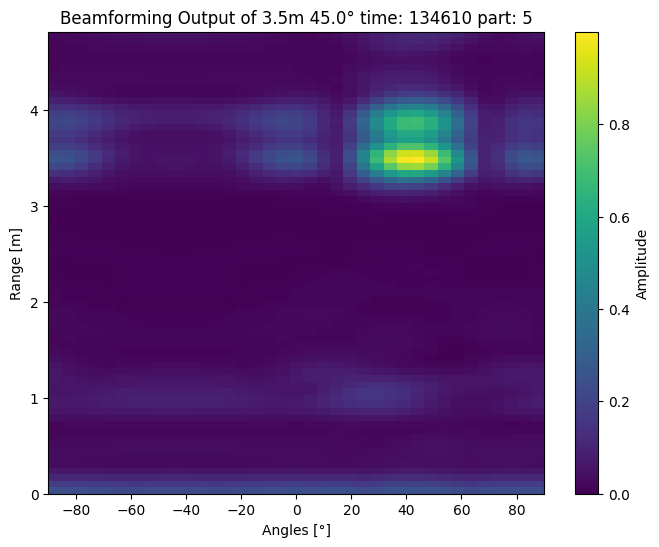

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134350split1.png


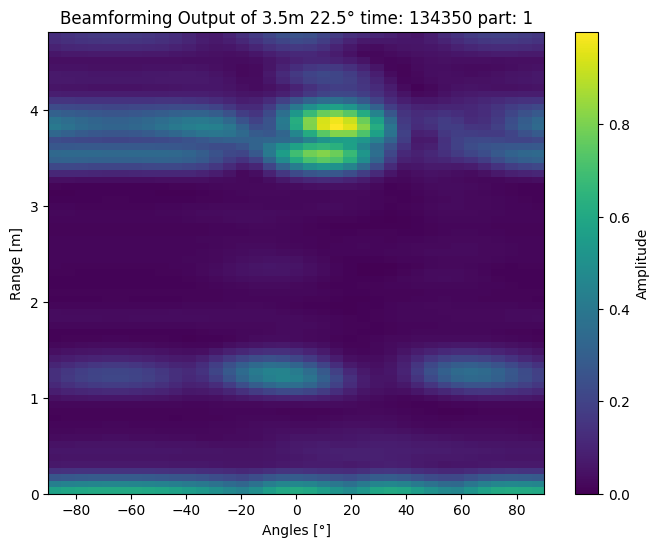

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134350split2.png


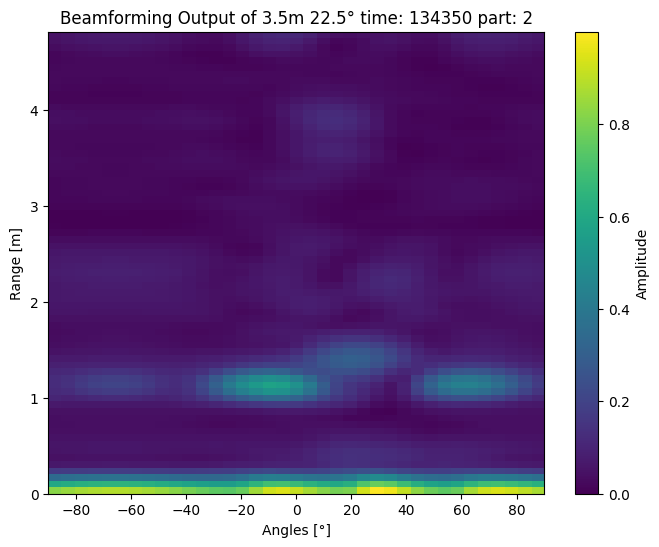

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134350split3.png


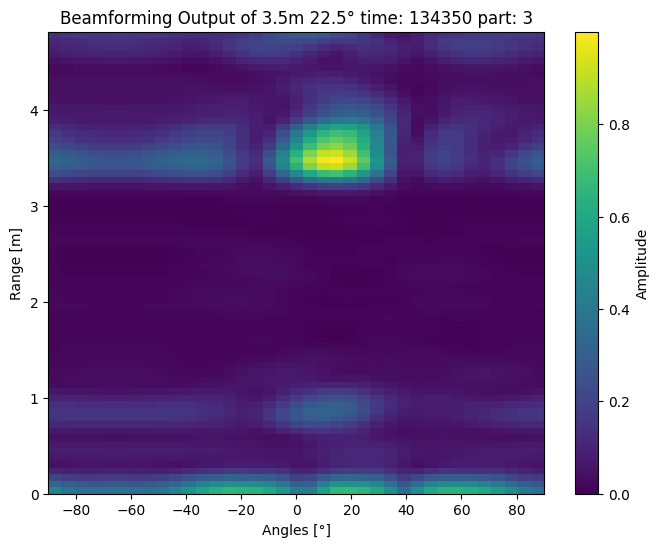

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134350split4.png


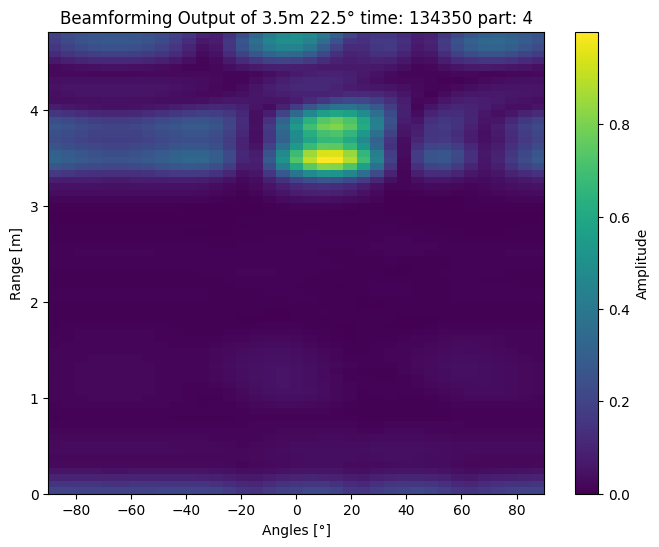

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134350split5.png


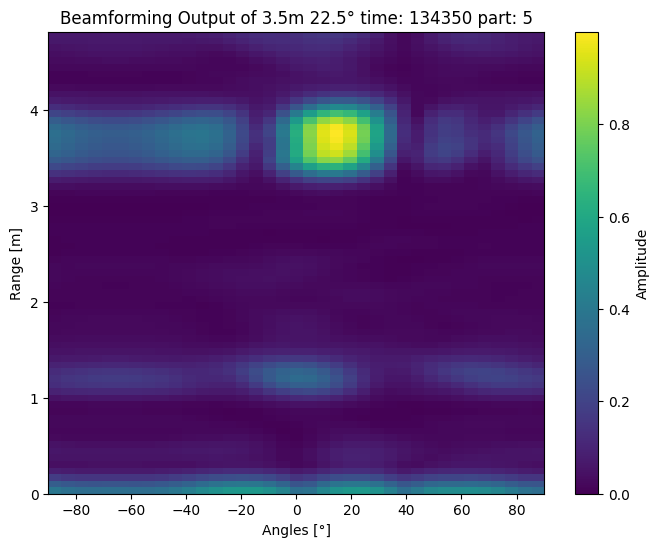

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134905split1.png


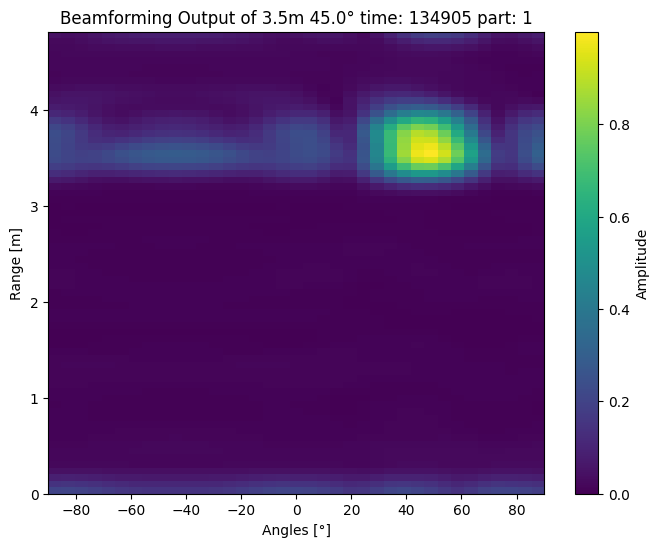

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134905split2.png


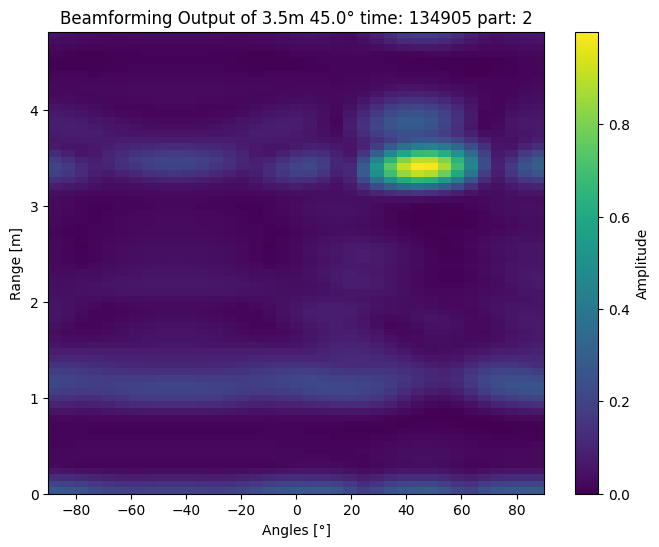

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134905split3.png


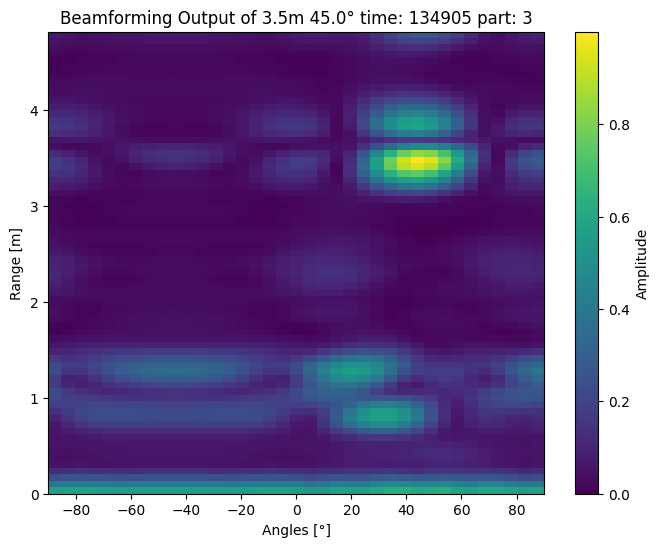

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134905split4.png


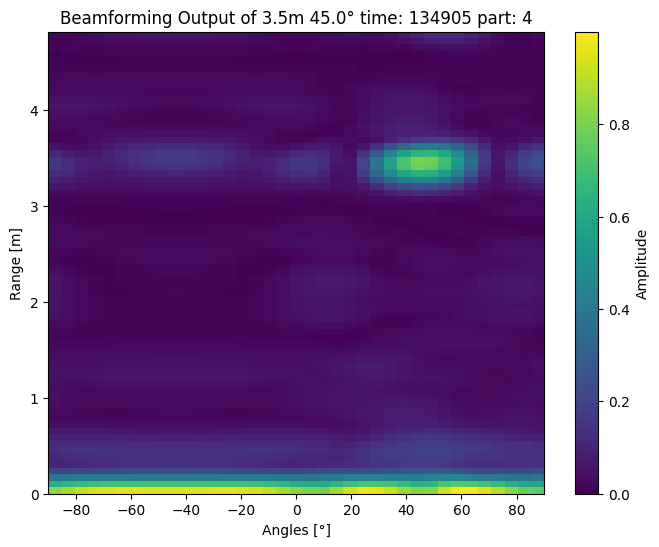

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134905split5.png


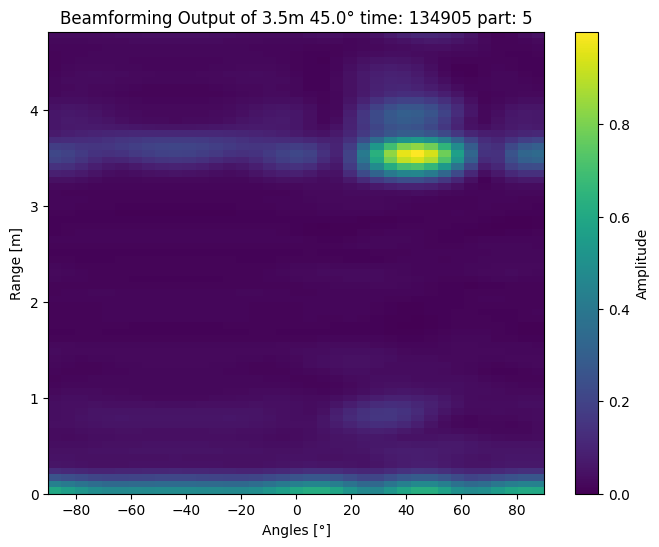

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134107split1.png


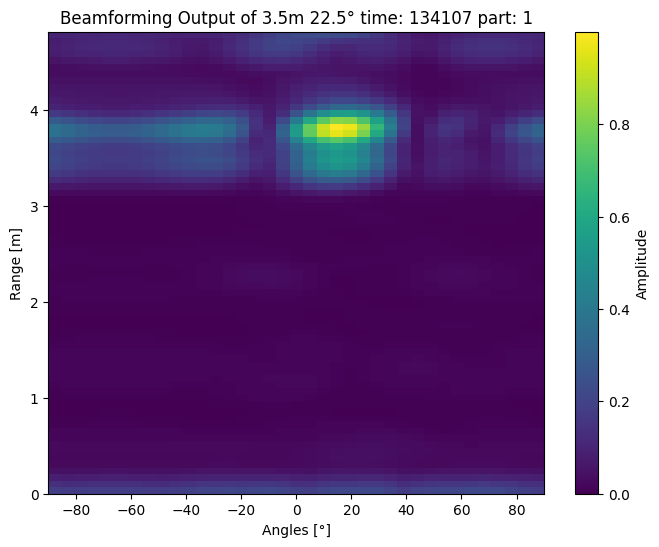

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134107split2.png


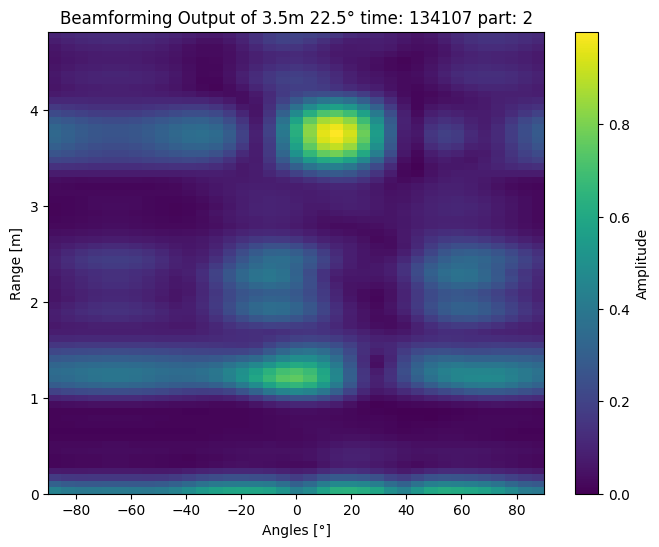

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134107split3.png


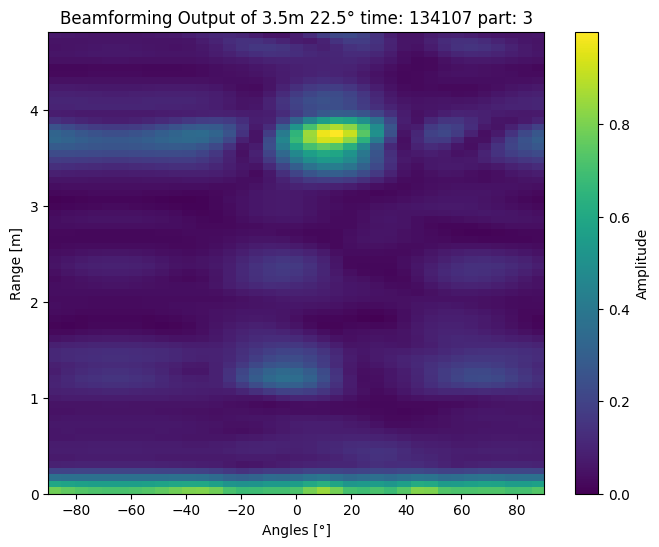

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134107split4.png


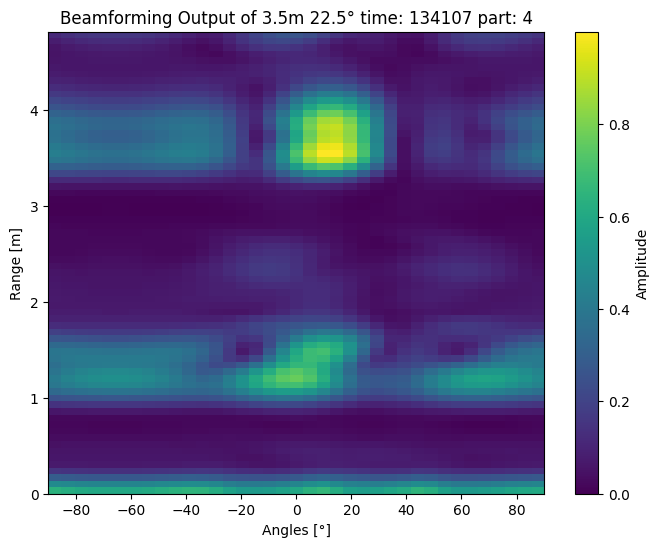

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134107split5.png


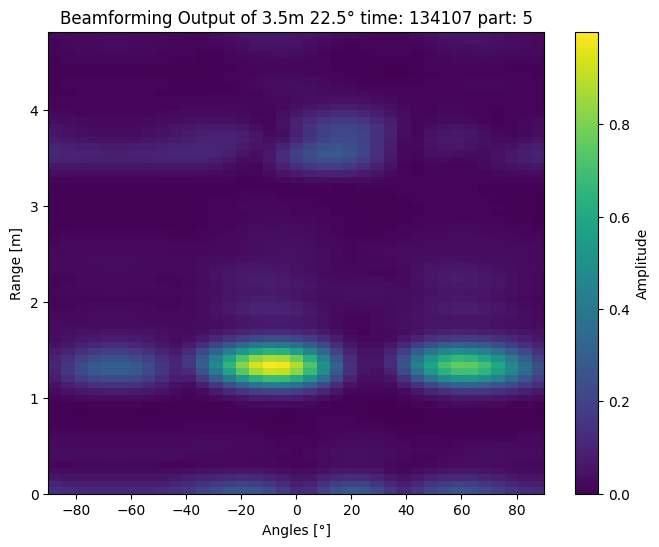

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134501split1.png


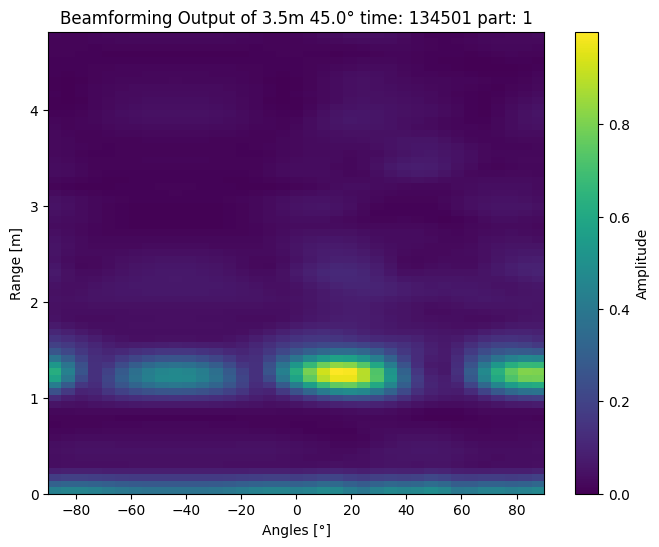

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134501split2.png


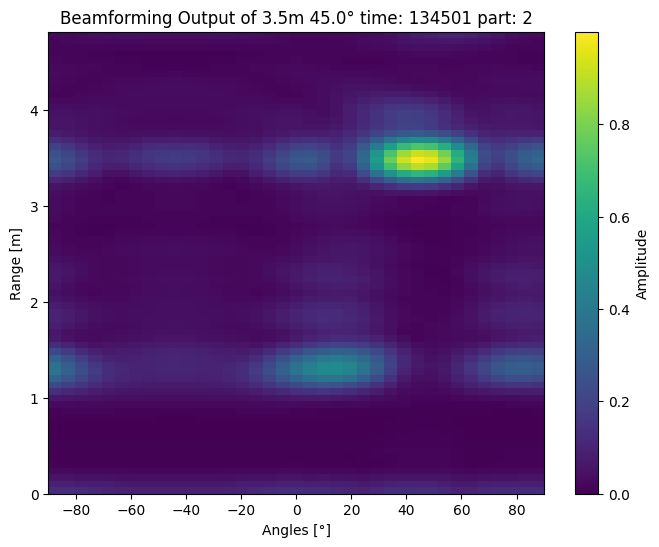

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134501split3.png


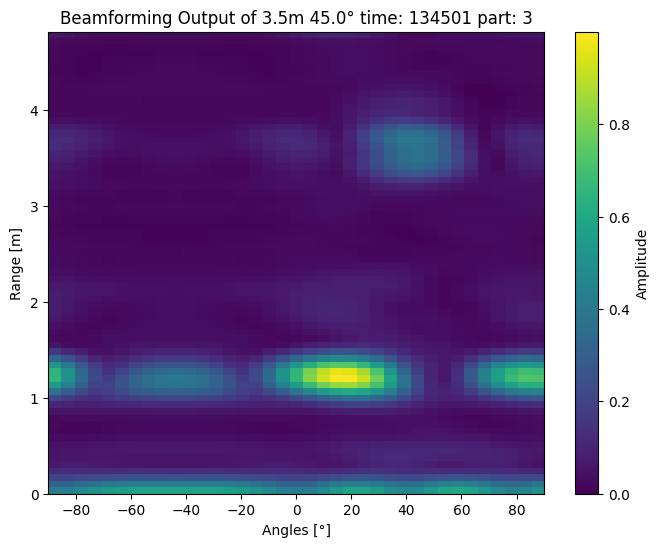

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134501split4.png


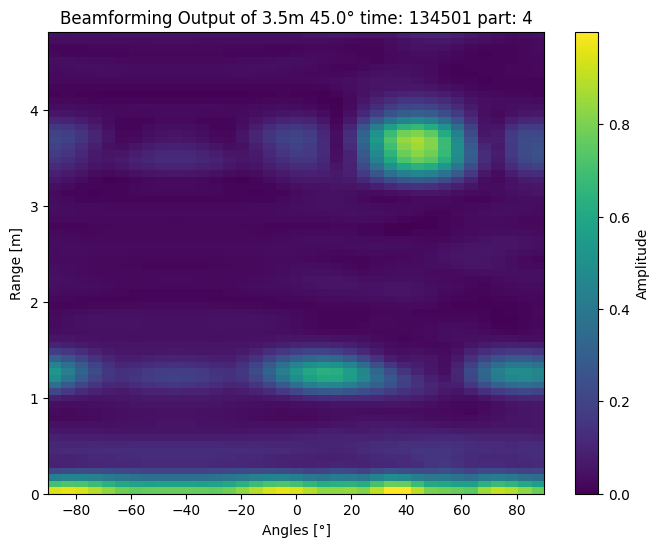

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_45.0deg_134501split5.png


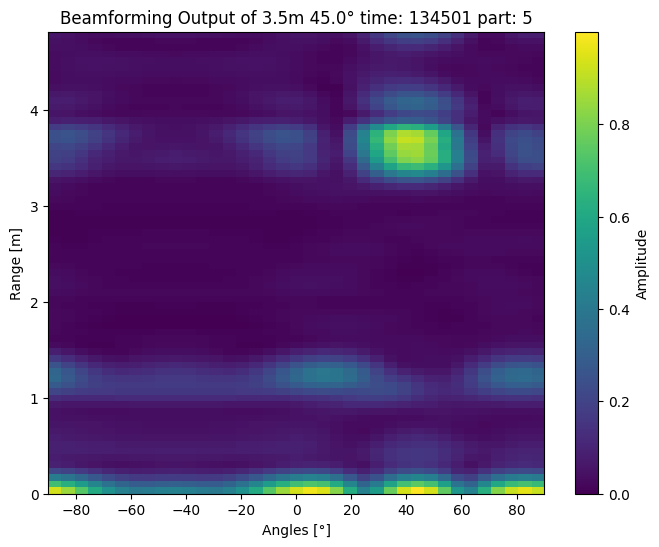

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134221split1.png


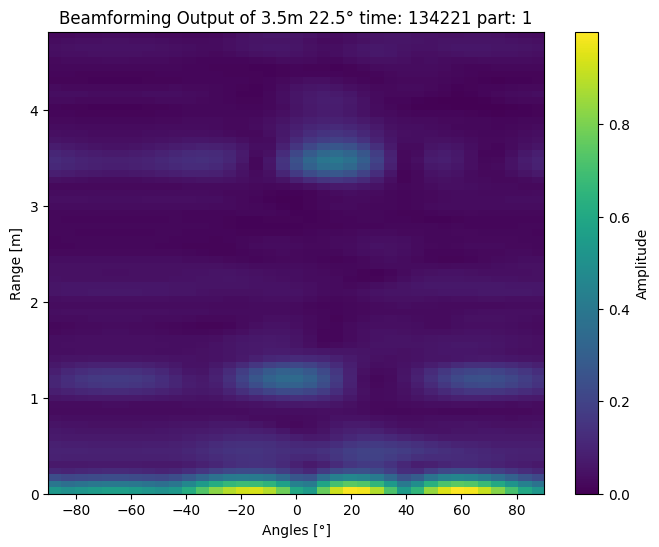

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134221split2.png


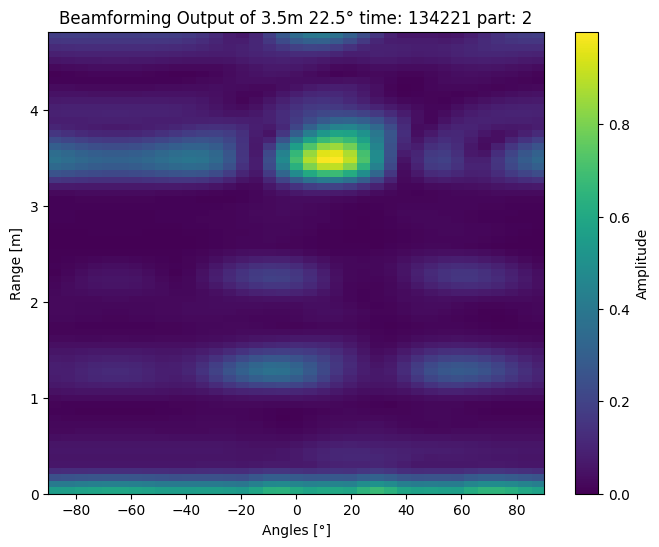

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134221split3.png


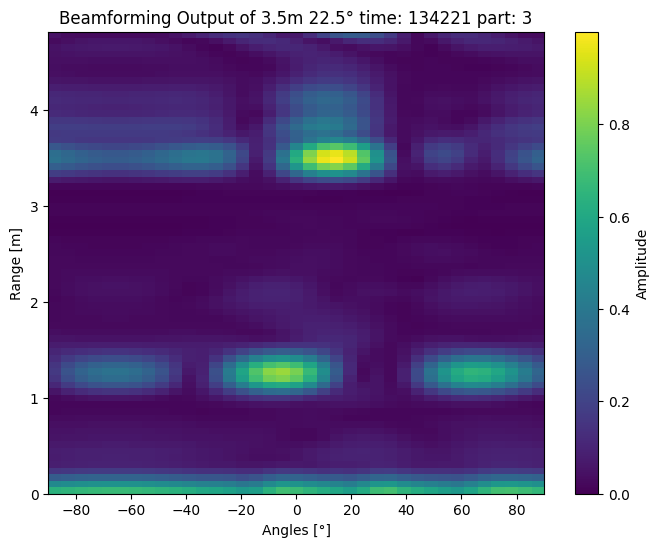

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134221split4.png


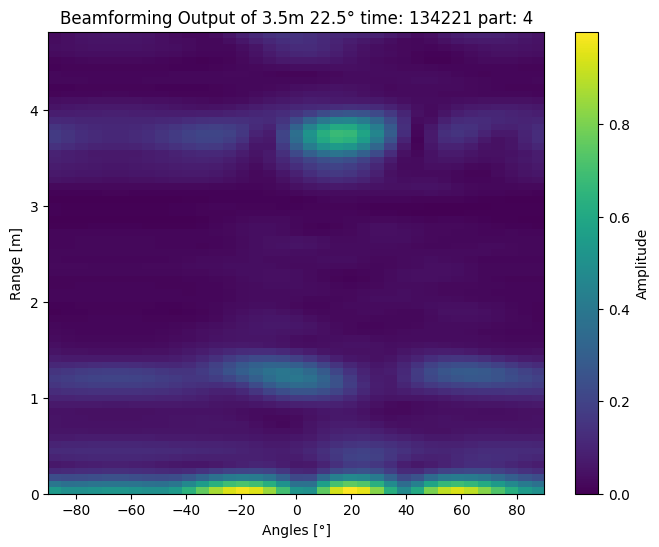

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_134221split5.png


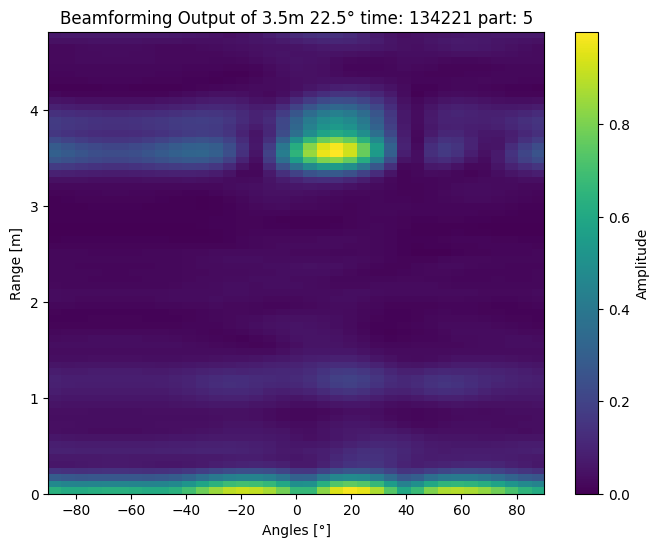

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133958split1.png


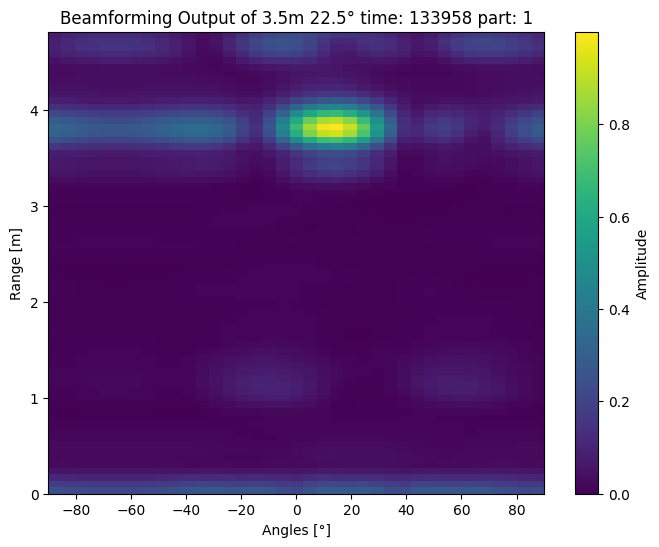

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133958split2.png


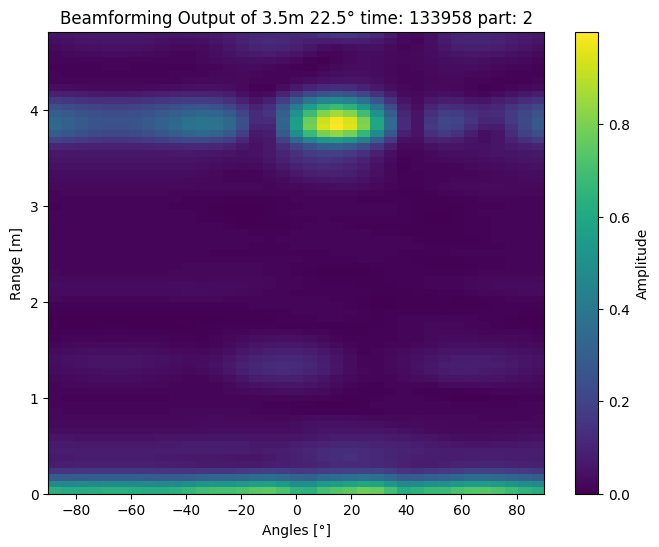

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133958split3.png


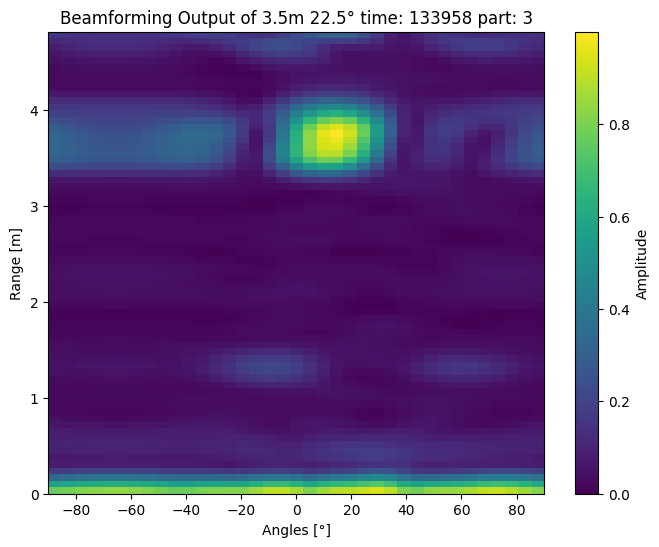

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133958split4.png


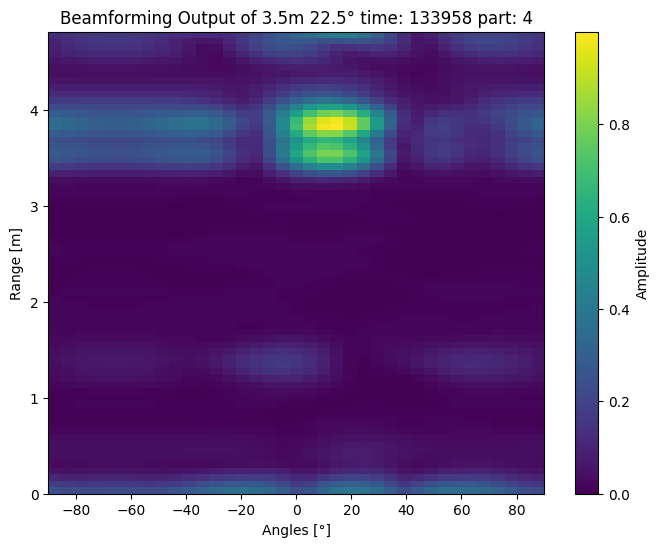

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133958split5.png


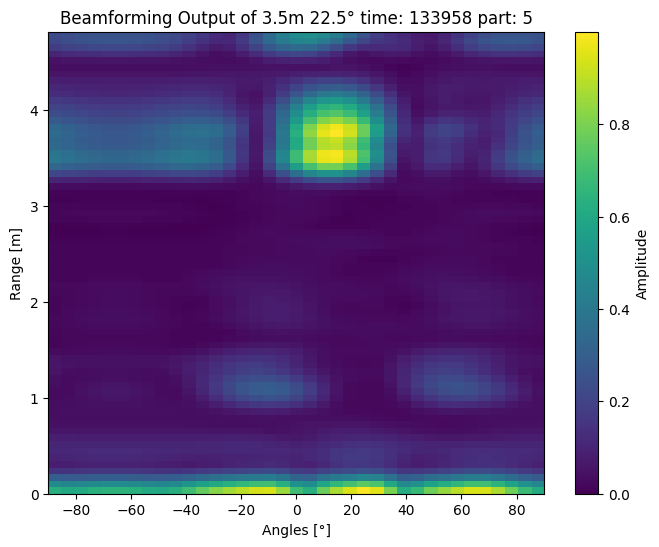

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133849split1.png


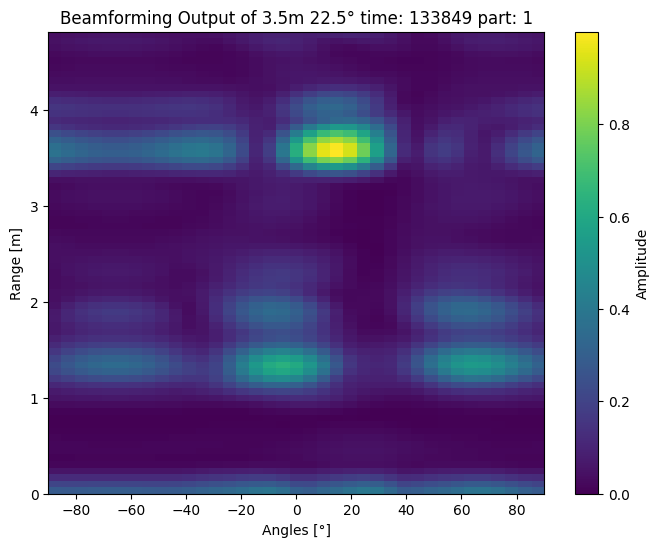

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133849split2.png


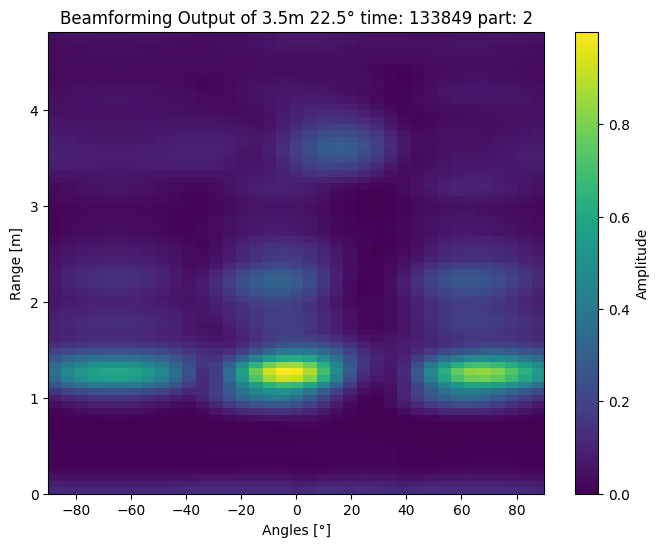

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133849split3.png


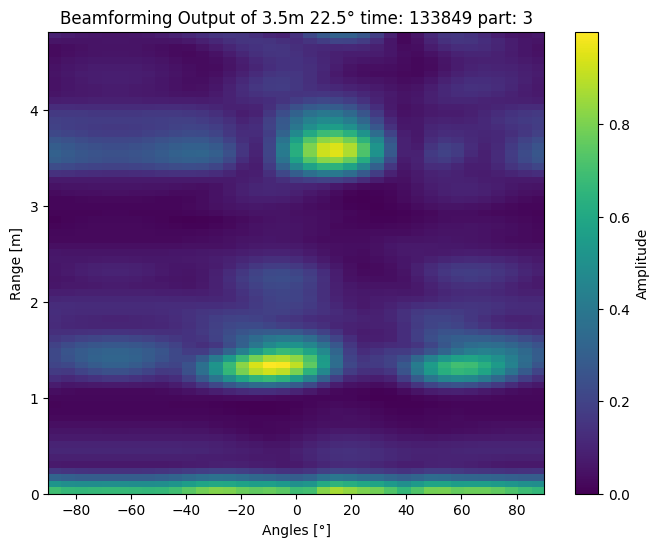

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133849split4.png


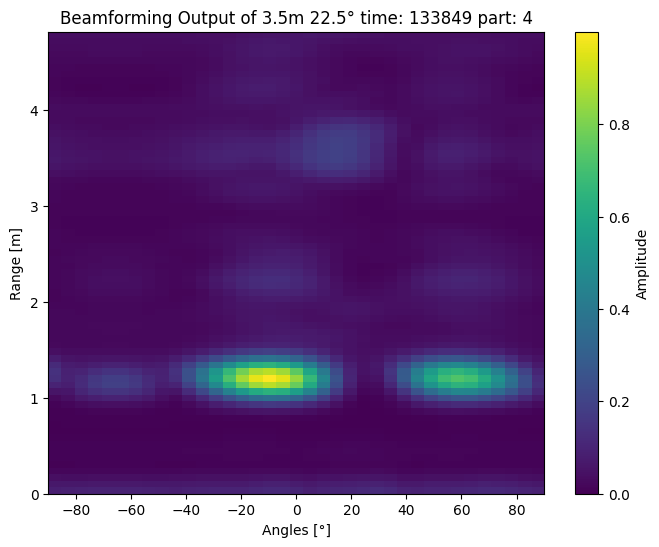

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_350cm_22.5deg_133849split5.png


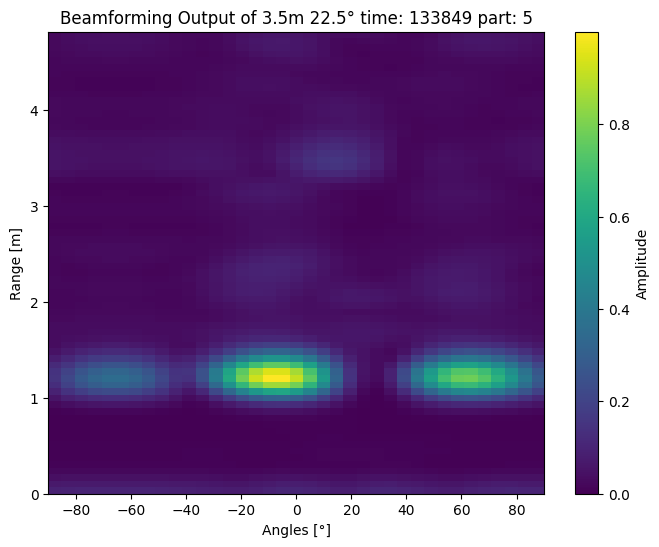

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133537split1.png


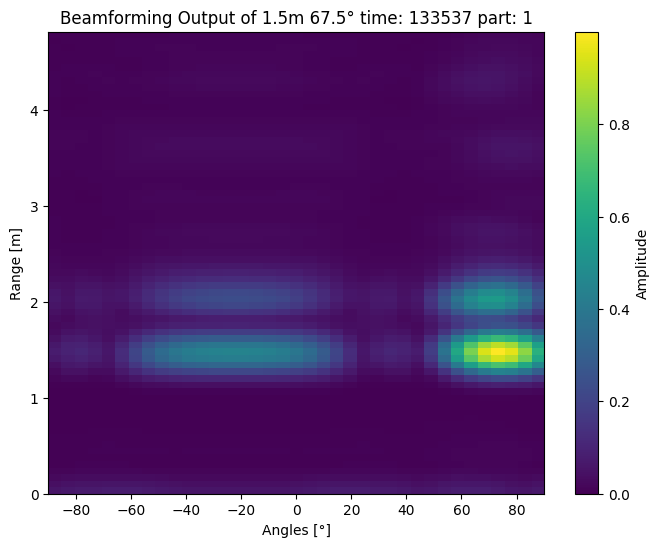

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133537split2.png


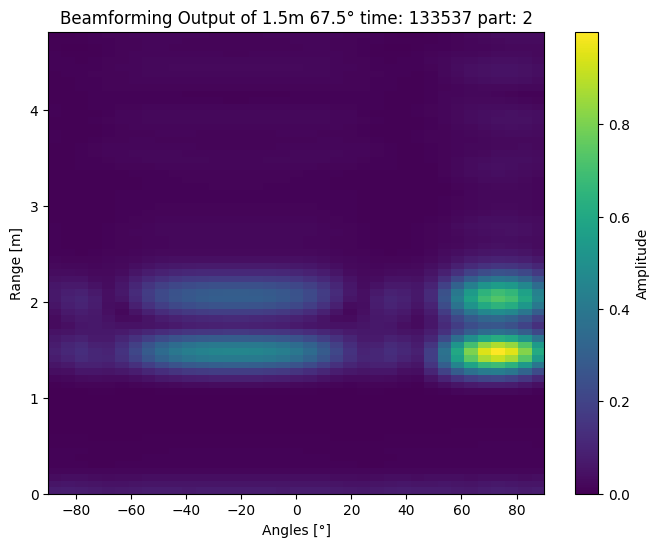

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133537split3.png


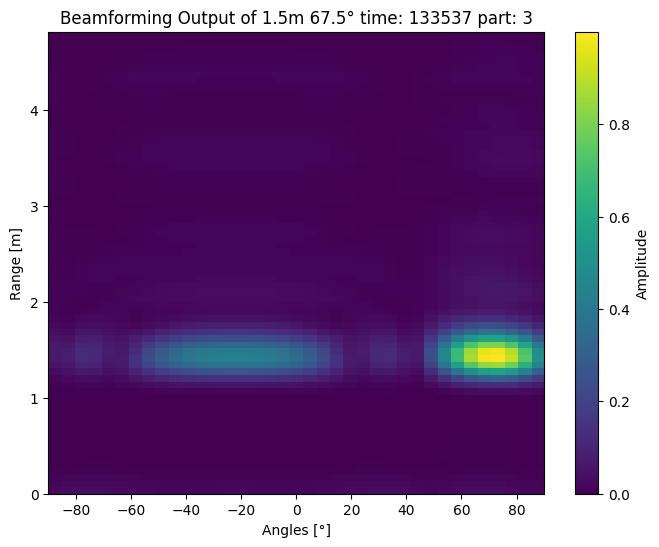

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133537split4.png


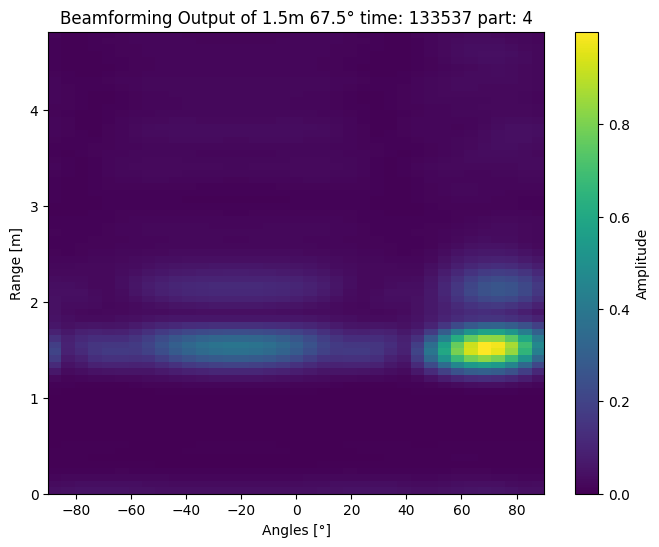

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133537split5.png


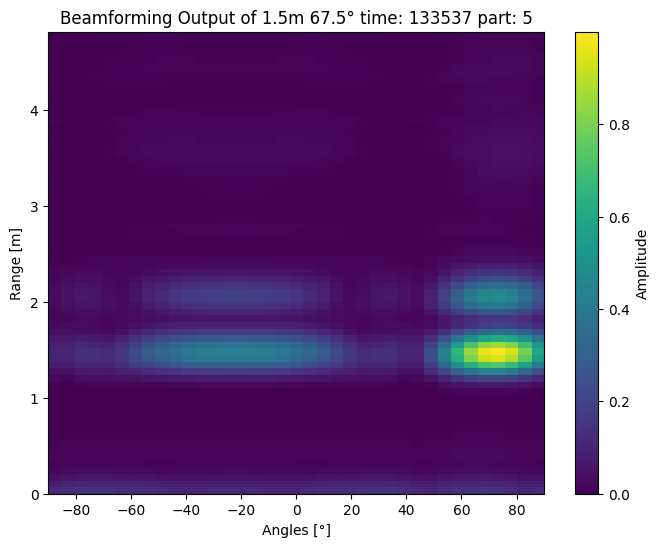

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133644split1.png


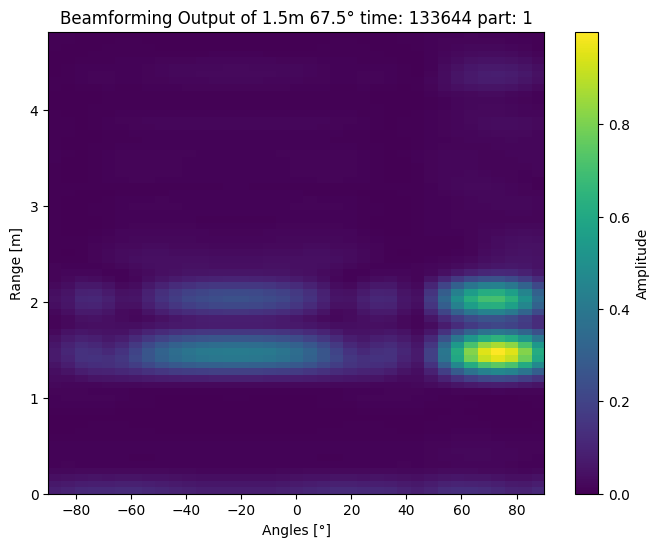

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133644split2.png


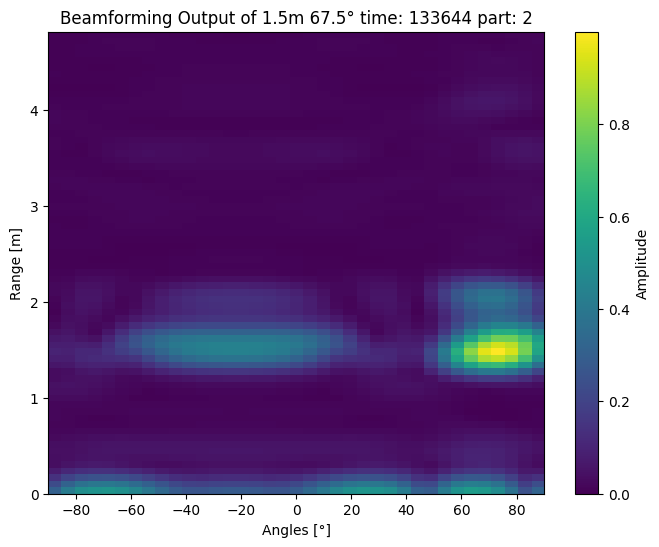

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133644split3.png


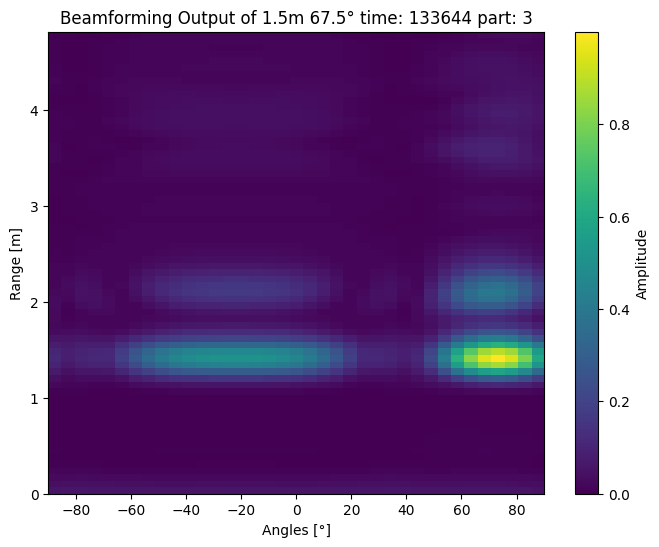

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133644split4.png


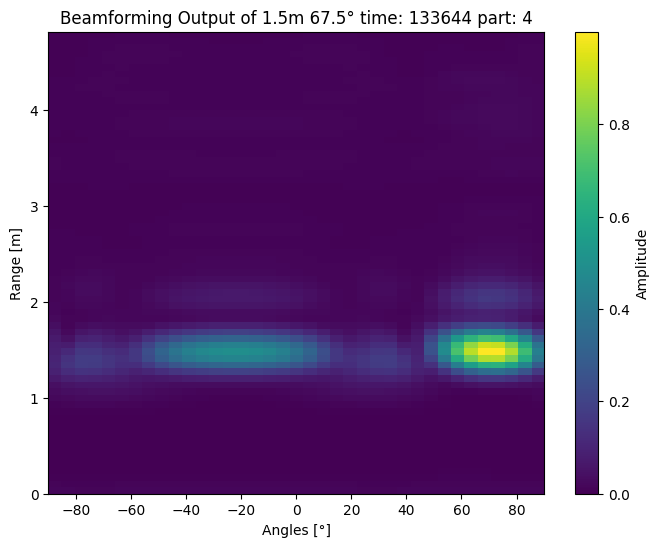

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133644split5.png


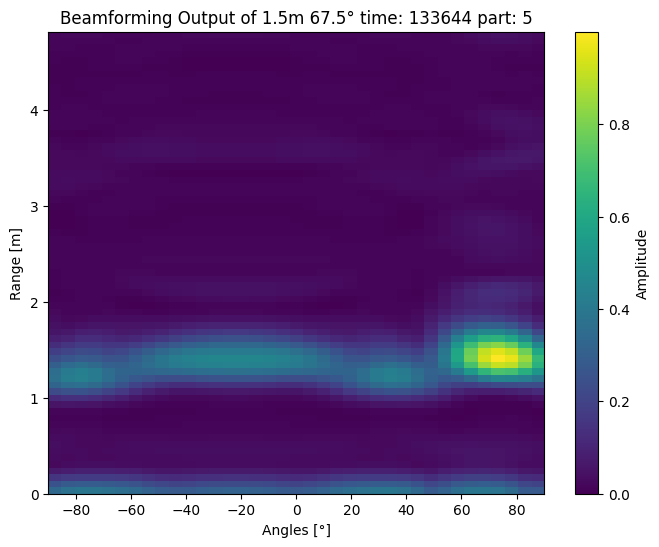

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133429split1.png


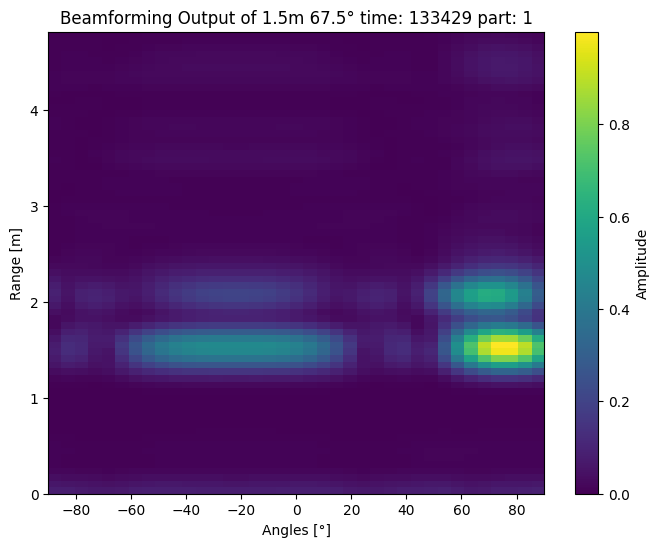

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133429split2.png


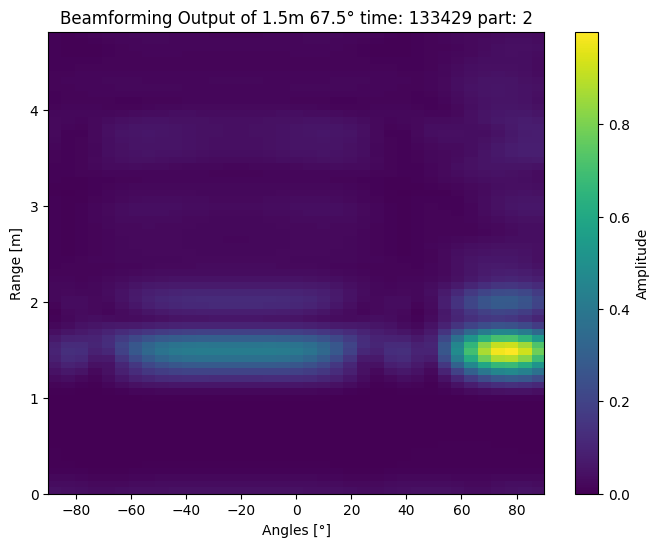

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133429split3.png


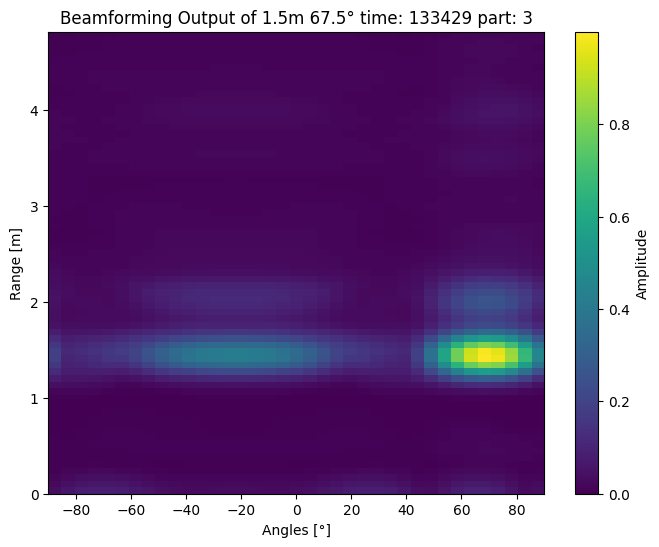

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133429split4.png


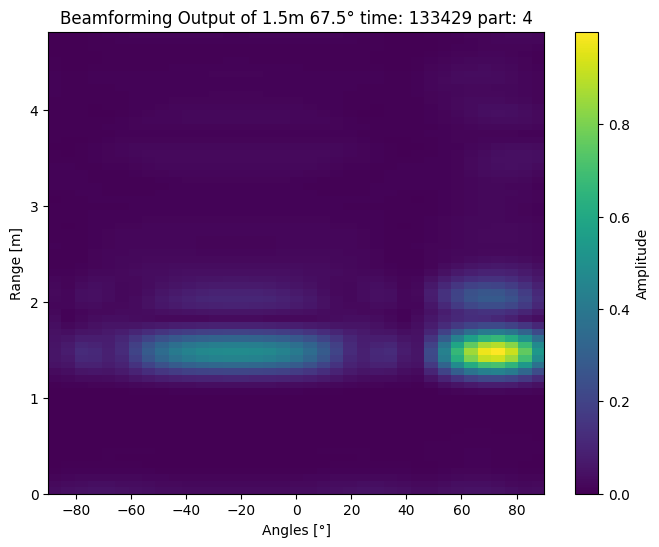

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133429split5.png


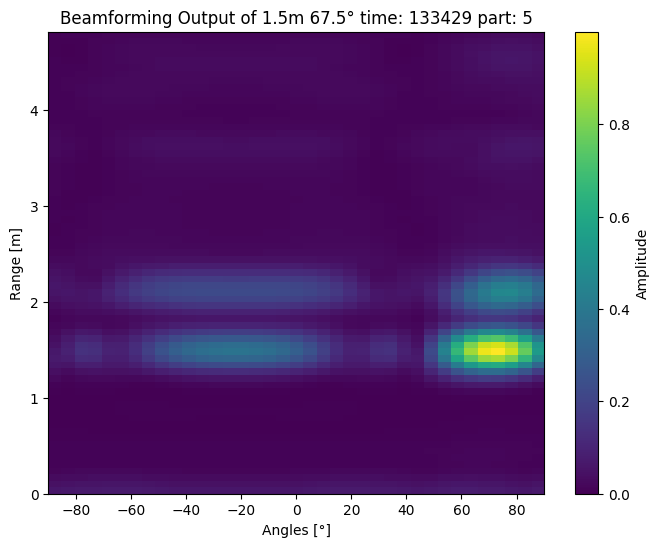

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133322split1.png


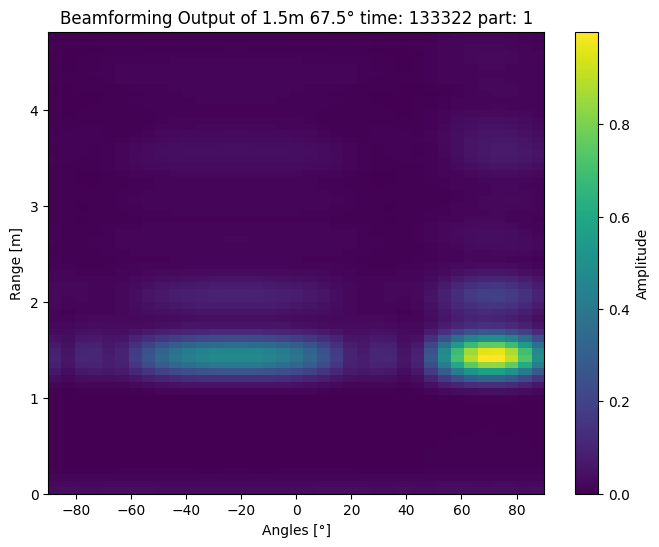

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133322split2.png


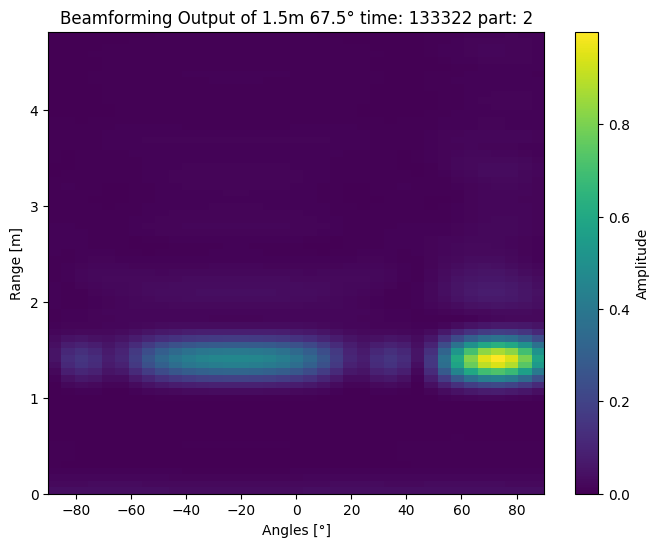

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133322split3.png


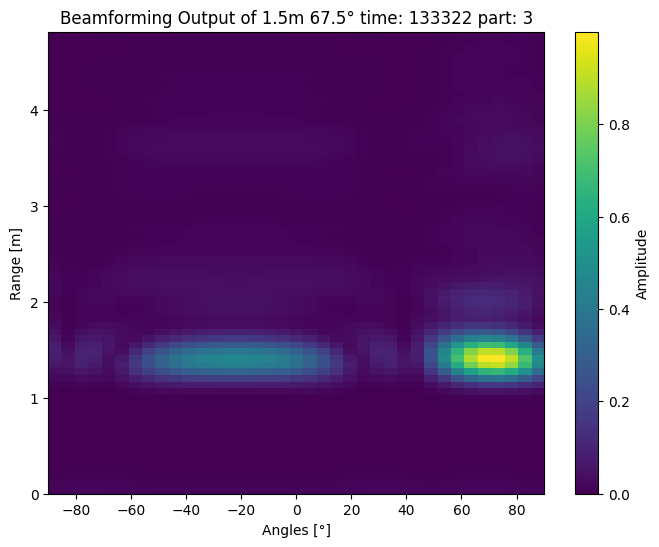

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133322split4.png


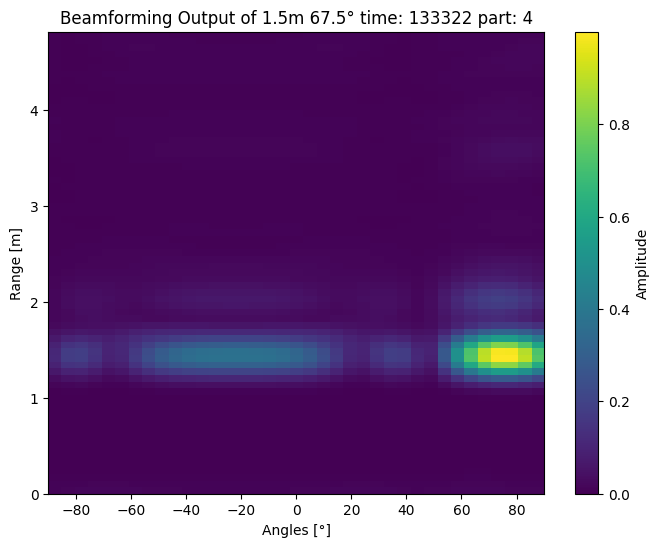

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133322split5.png


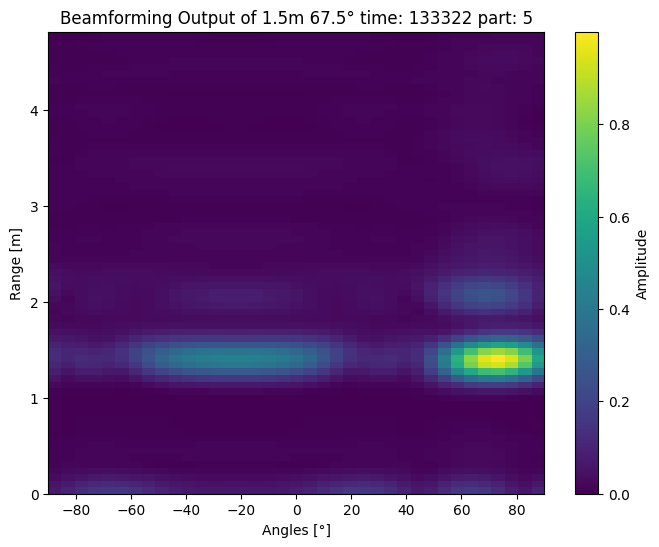

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133214split1.png


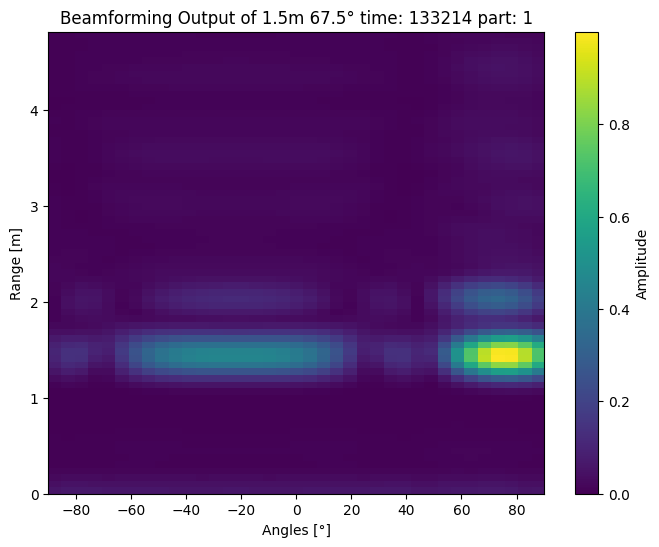

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133214split2.png


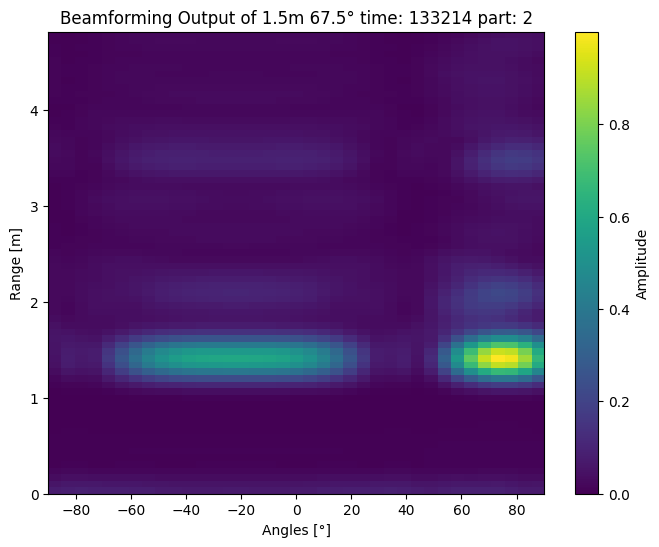

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133214split3.png


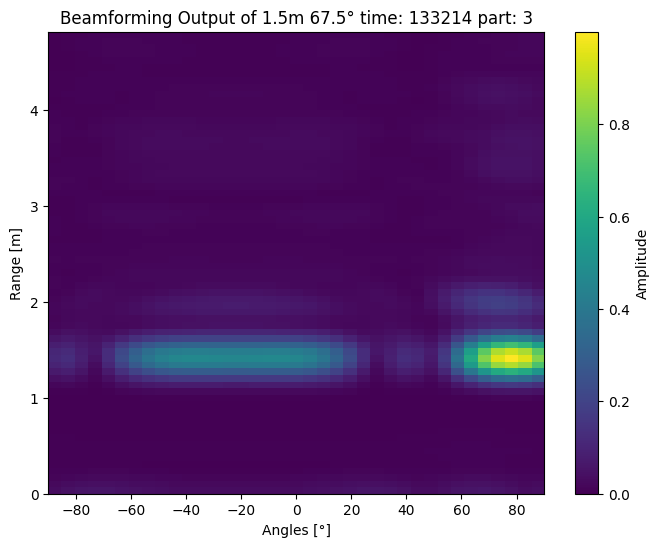

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133214split4.png


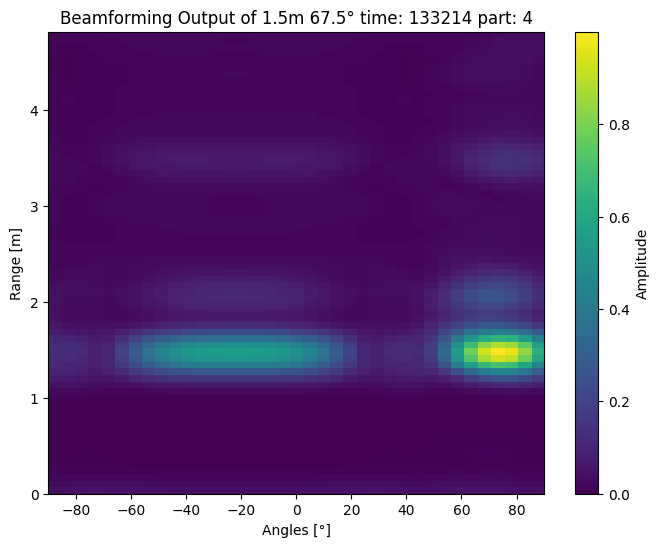

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_67.5deg_133214split5.png


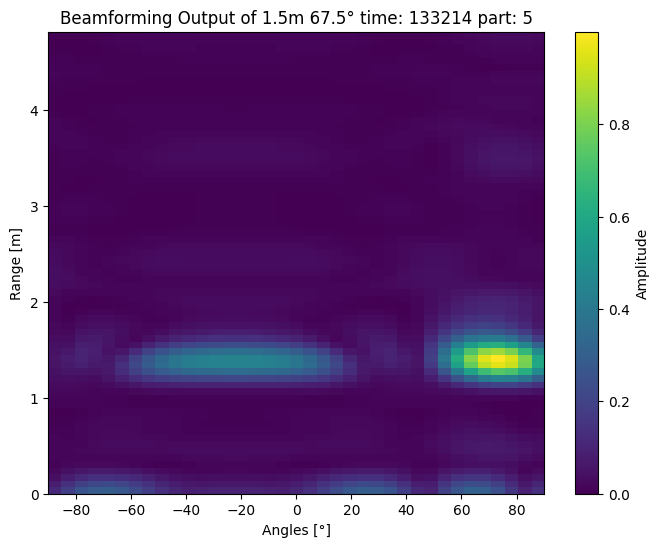

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132927split1.png


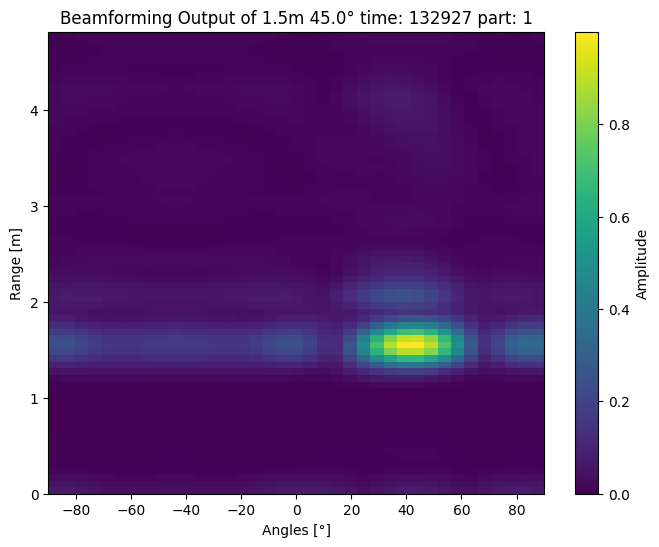

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132927split2.png


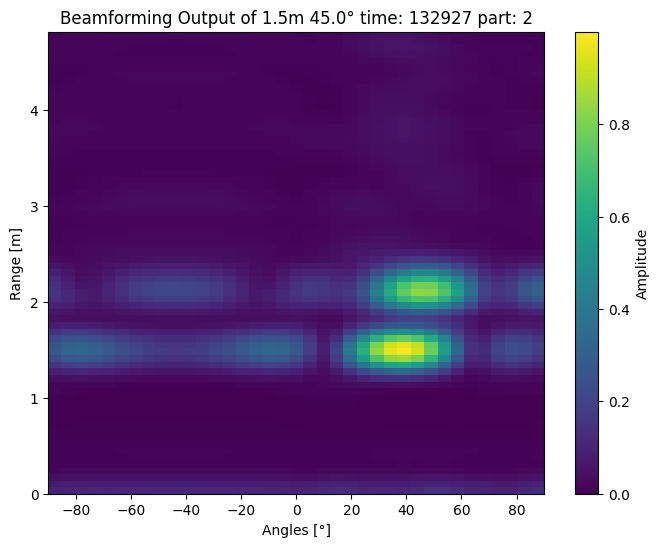

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132927split3.png


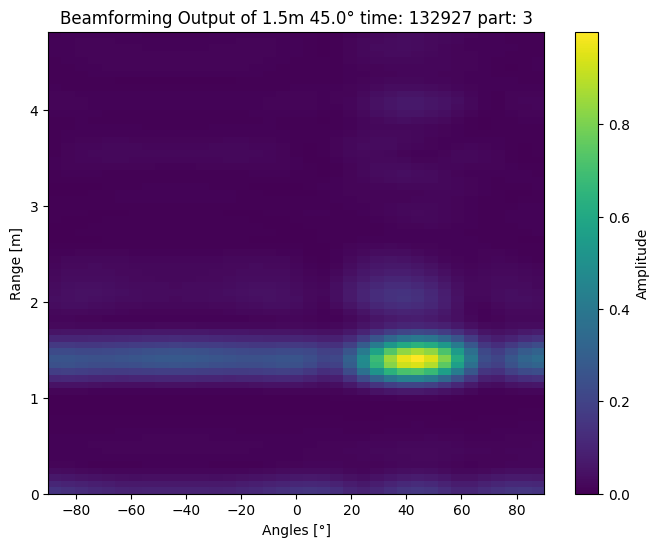

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132927split4.png


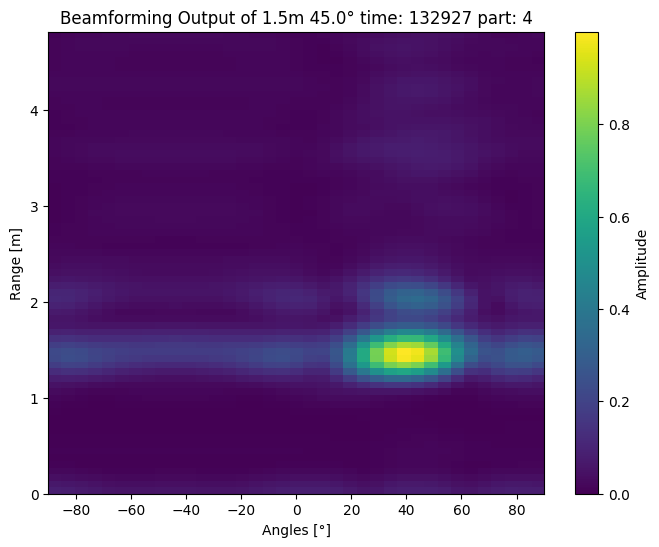

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132927split5.png


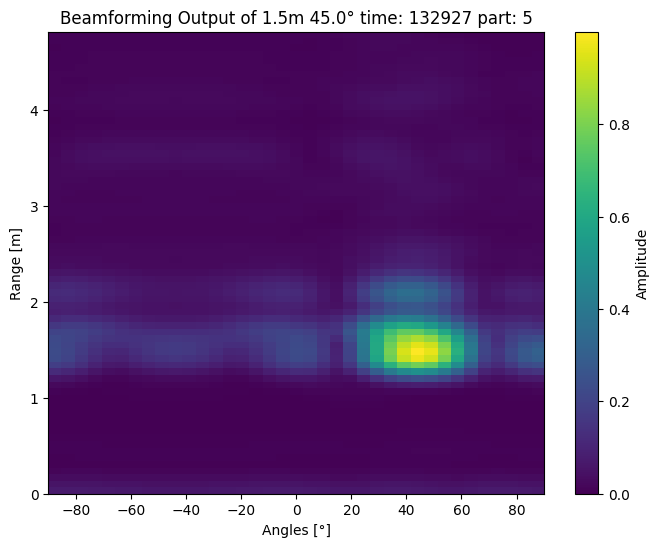

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132558split1.png


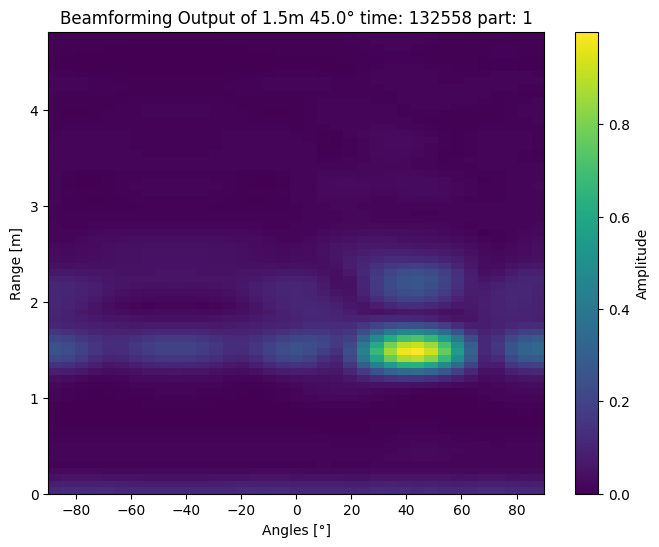

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132558split2.png


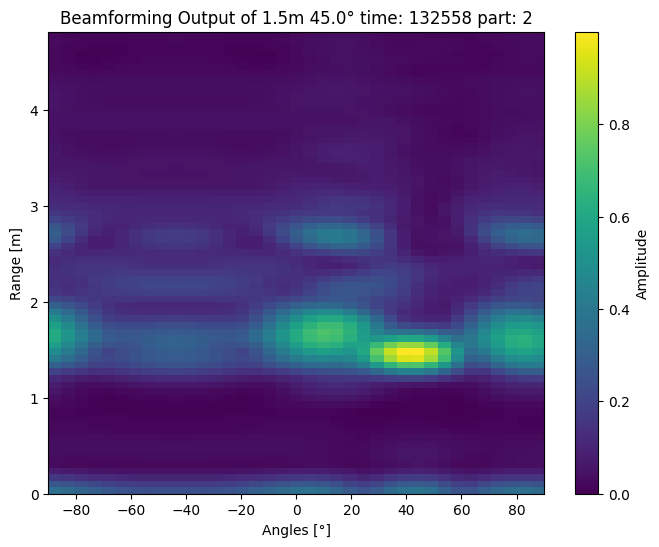

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132558split3.png


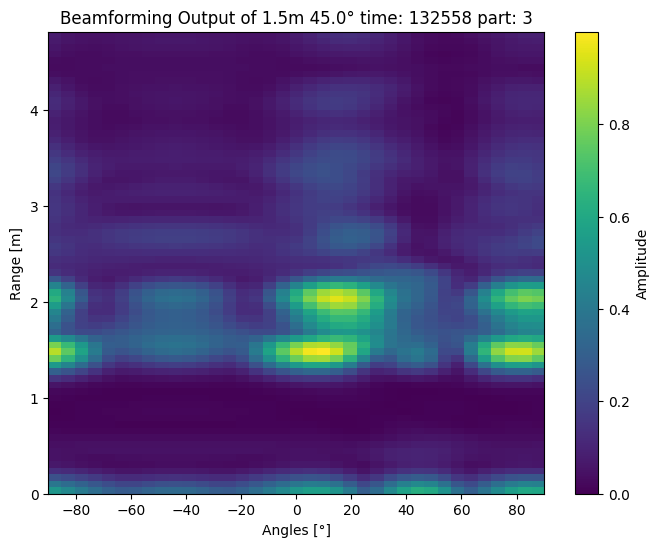

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132558split4.png


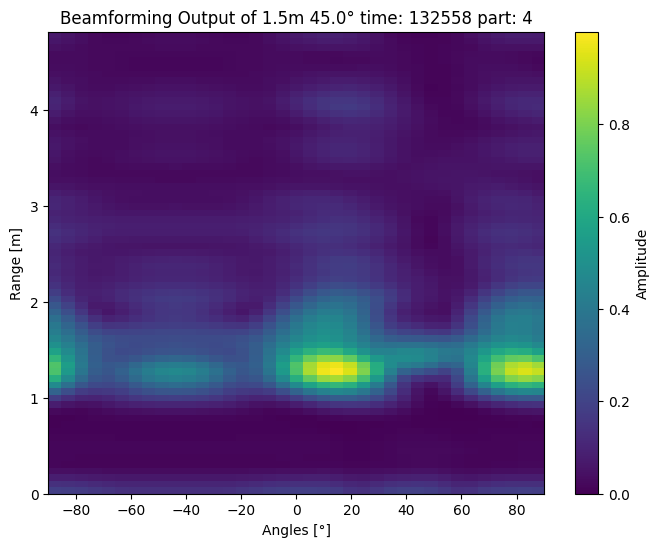

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132558split5.png


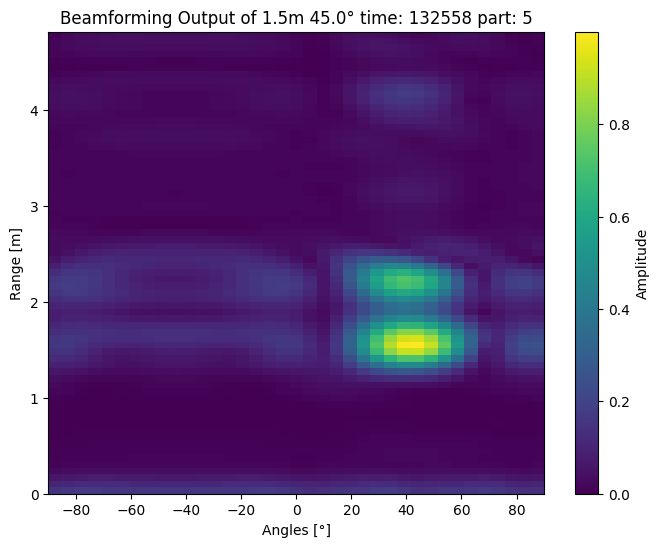

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132706split1.png


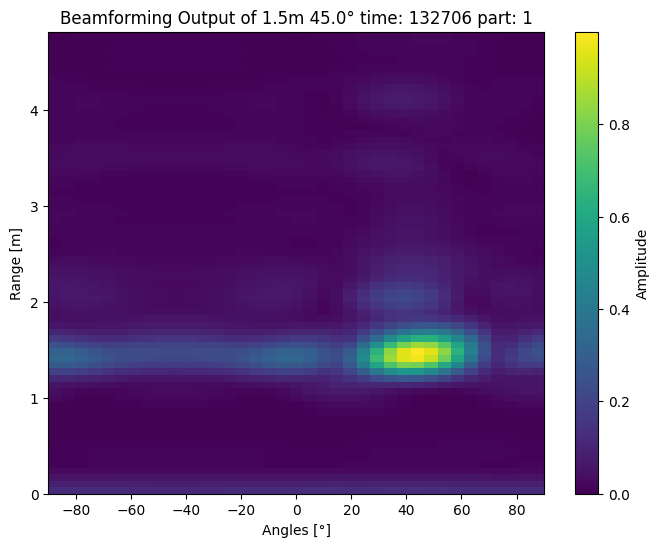

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132706split2.png


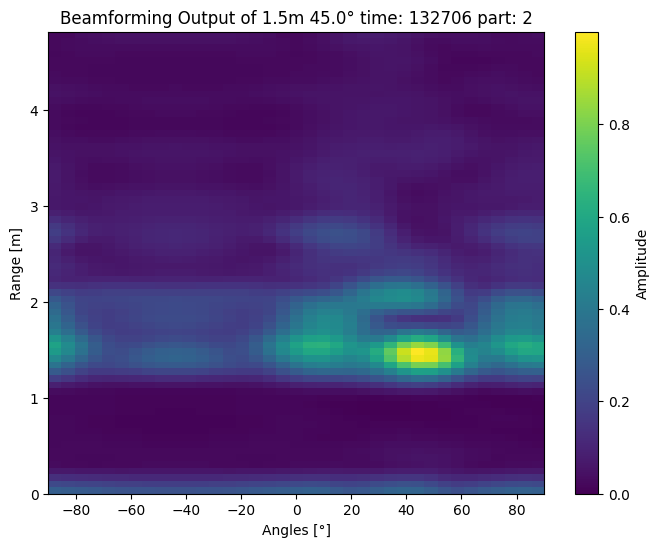

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132706split3.png


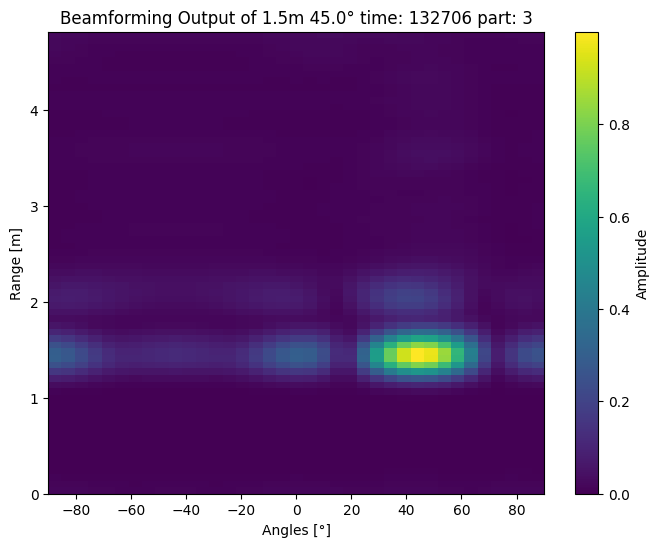

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132706split4.png


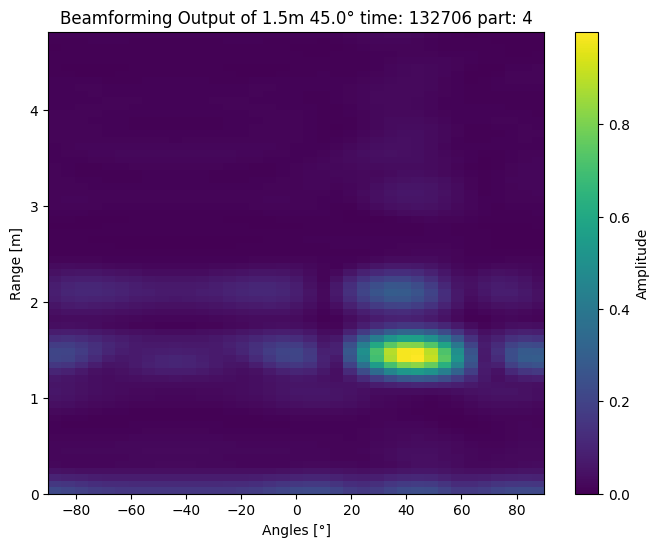

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132706split5.png


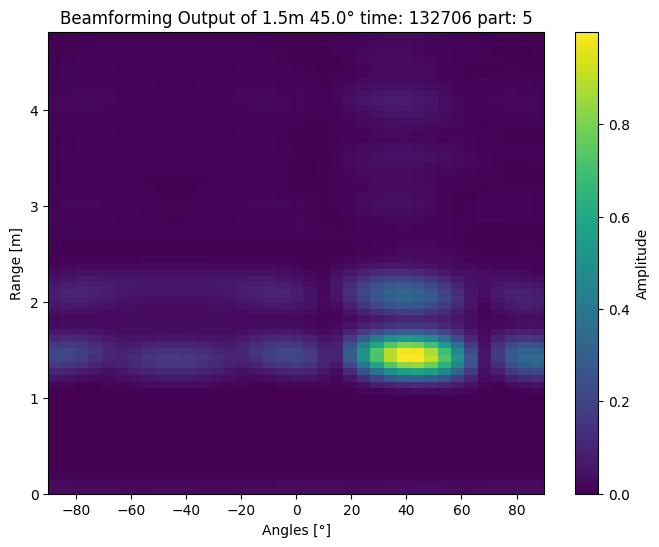

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_133033split1.png


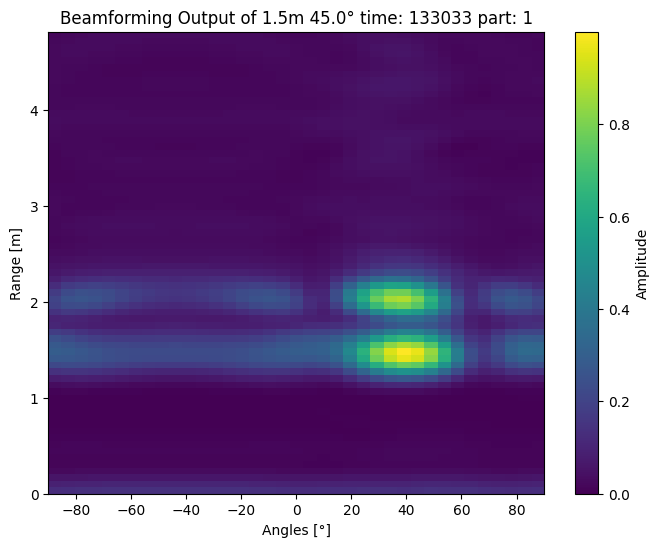

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_133033split2.png


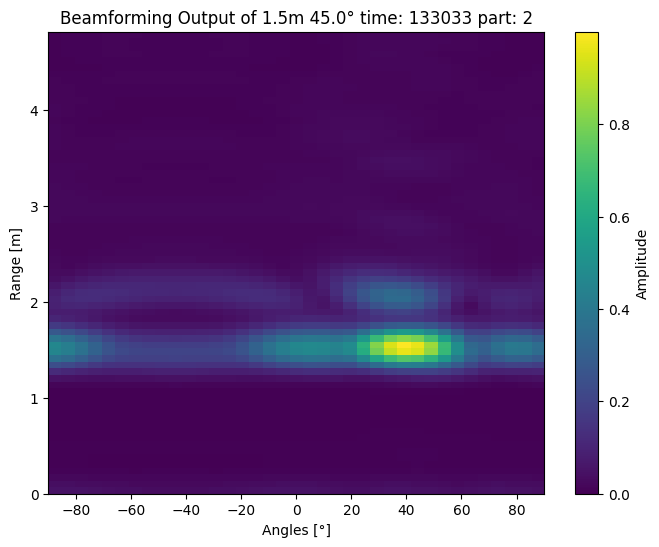

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_133033split3.png


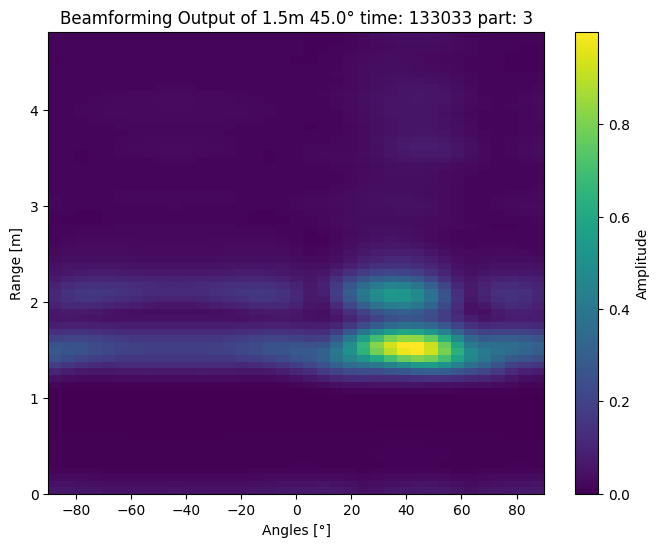

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_133033split4.png


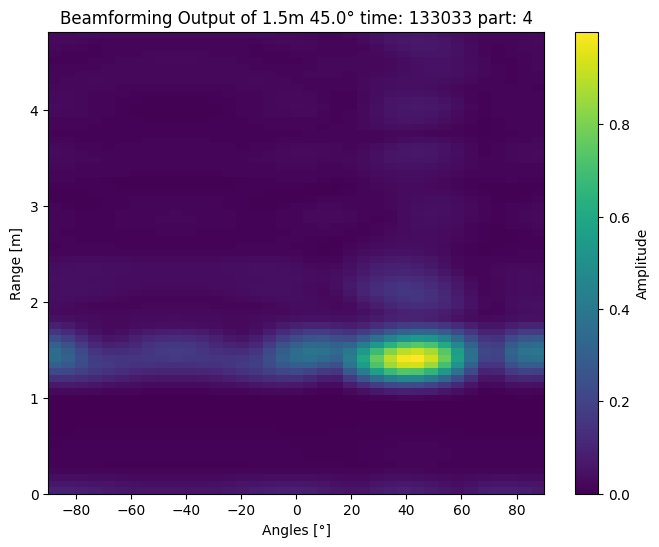

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_133033split5.png


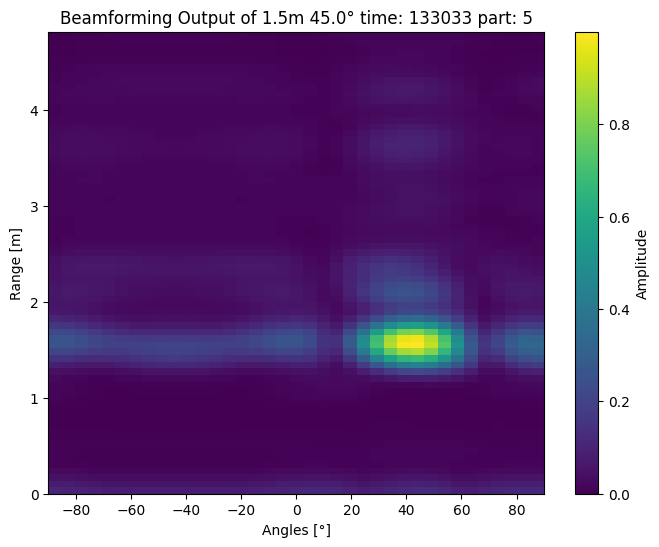

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132819split1.png


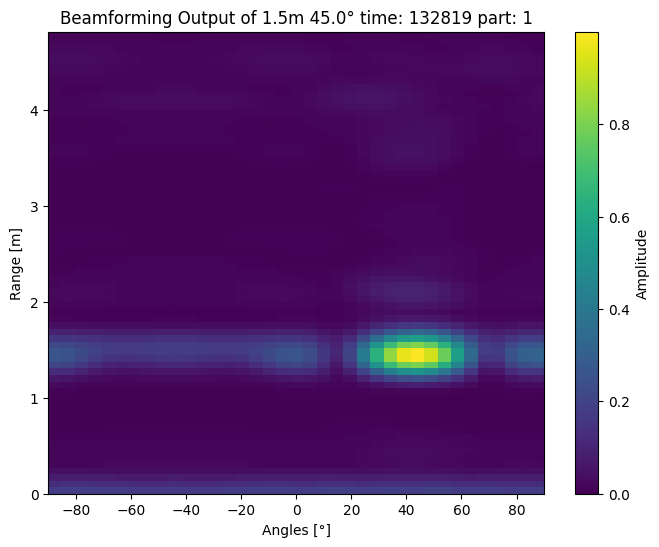

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132819split2.png


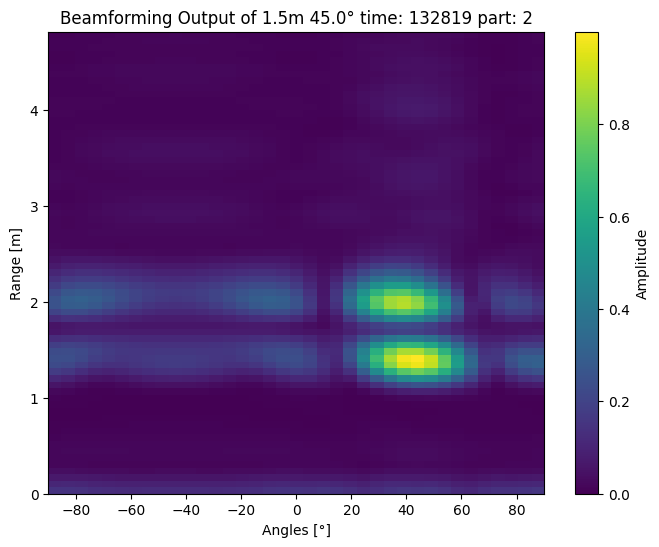

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132819split3.png


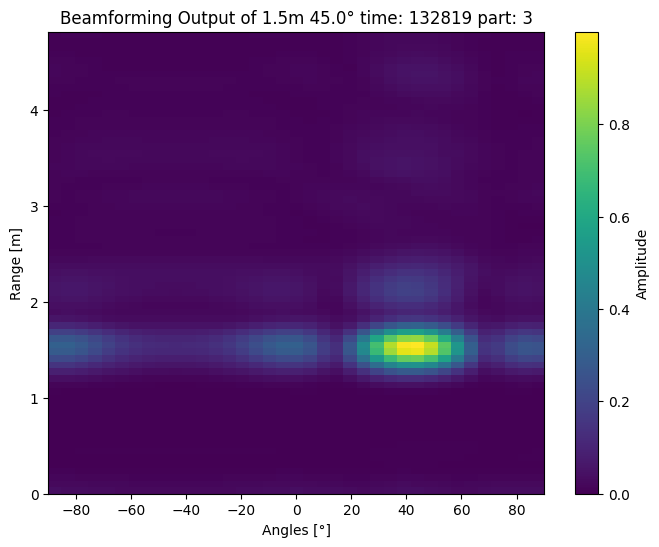

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132819split4.png


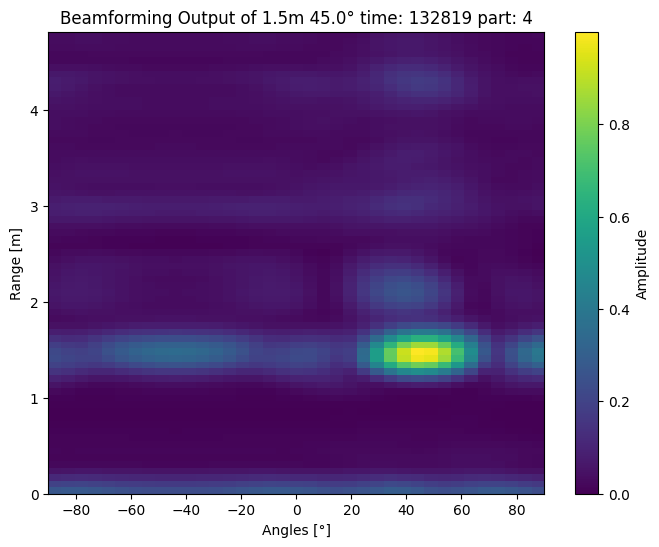

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_45.0deg_132819split5.png


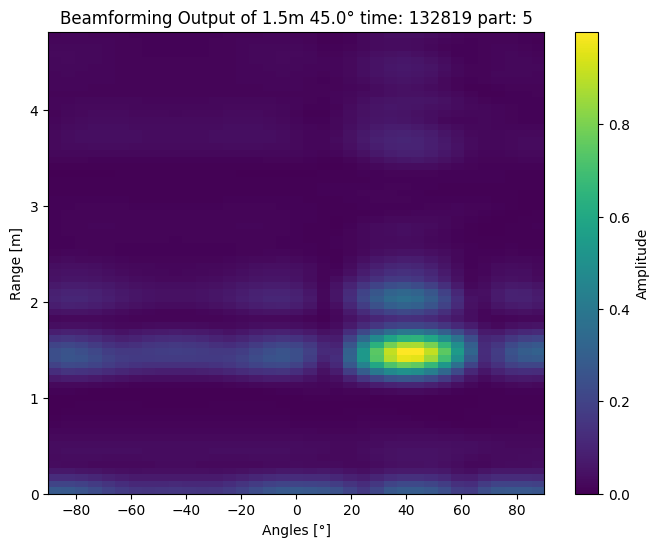

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131826split1.png


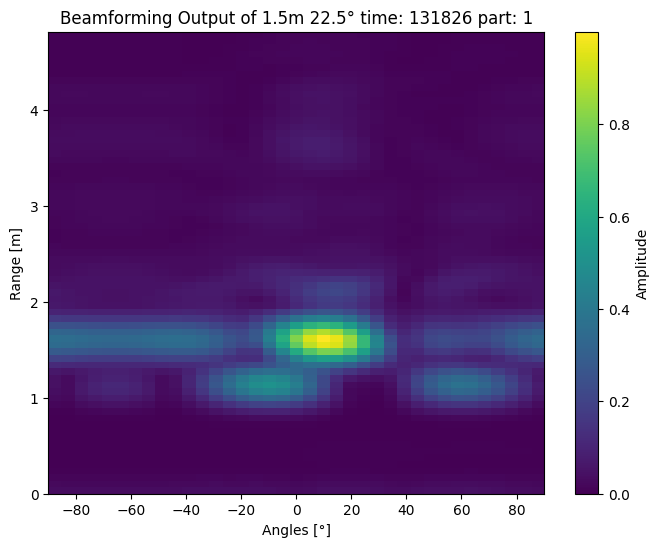

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131826split2.png


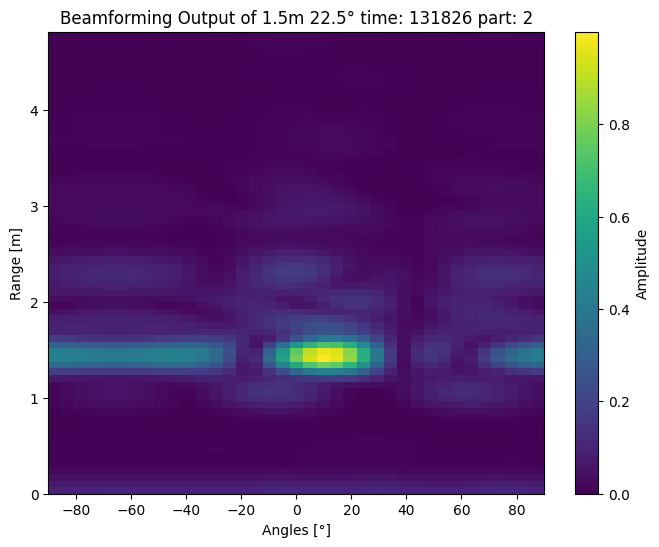

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131826split3.png


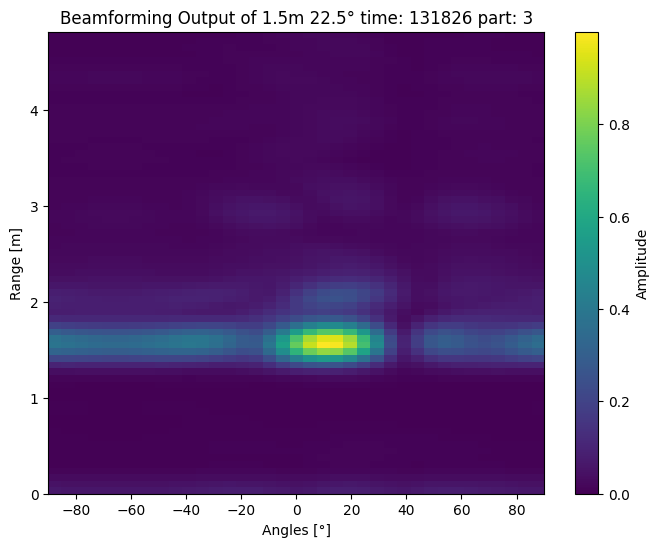

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131826split4.png


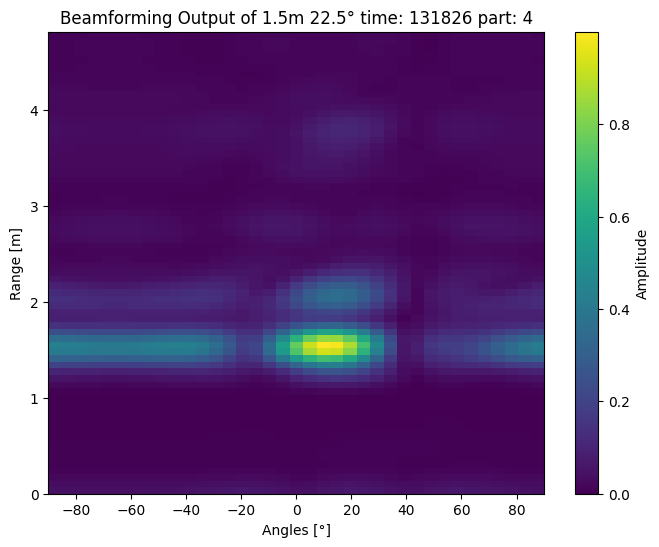

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131826split5.png


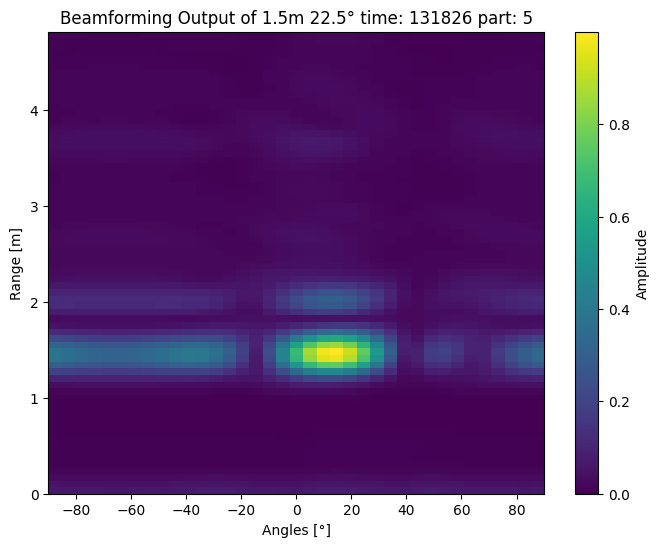

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131934split1.png


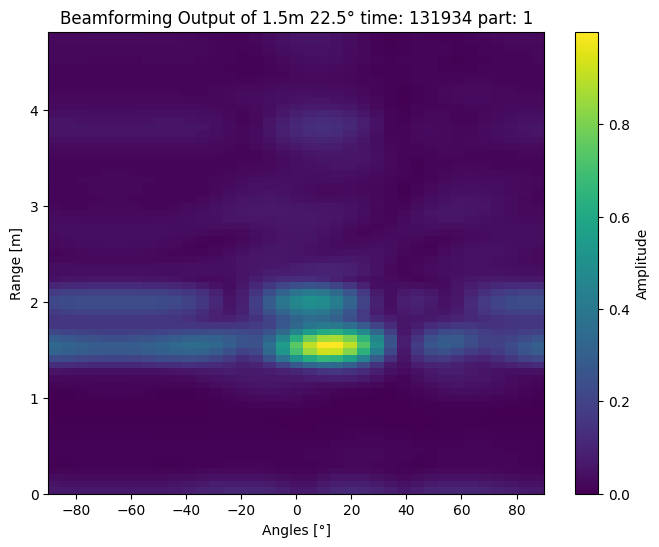

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131934split2.png


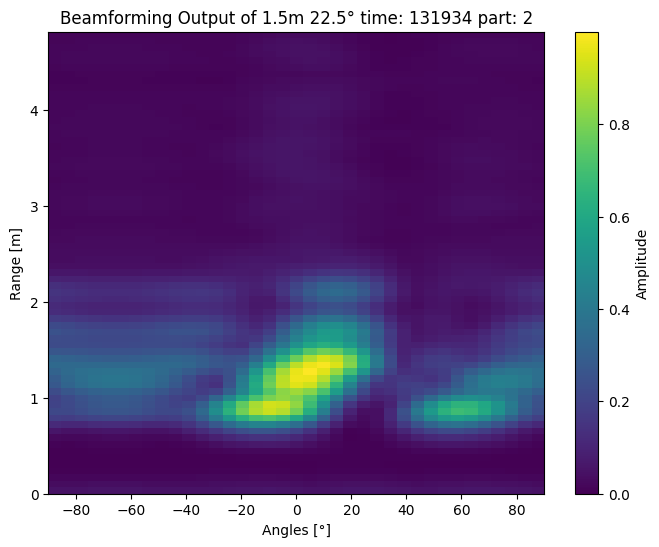

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131934split3.png


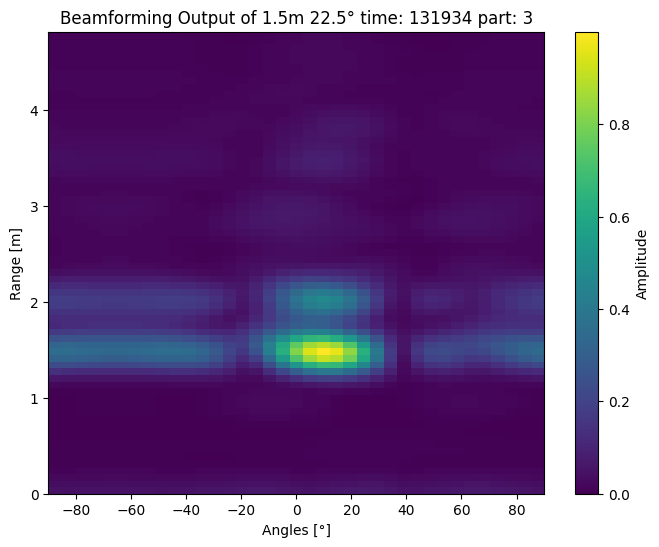

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131934split4.png


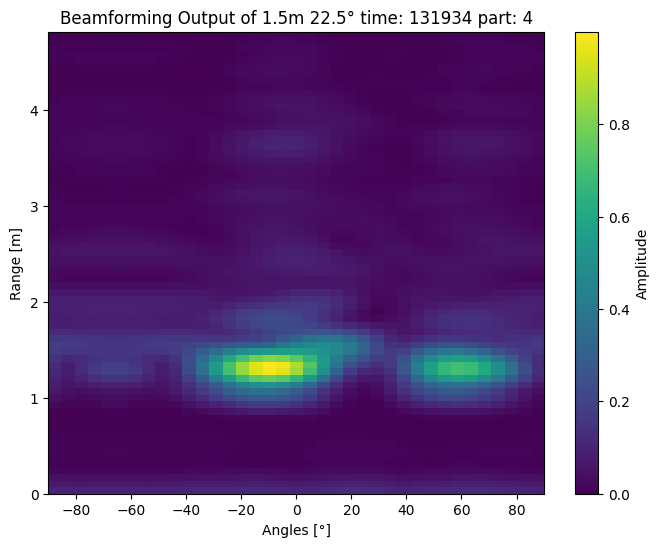

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131934split5.png


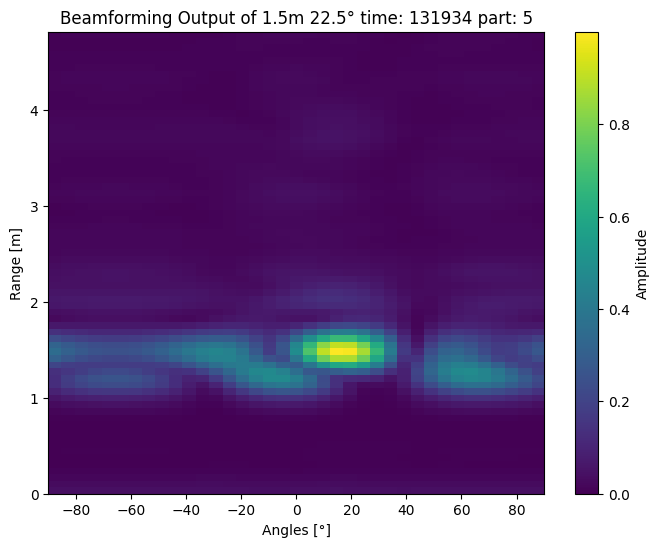

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132105split1.png


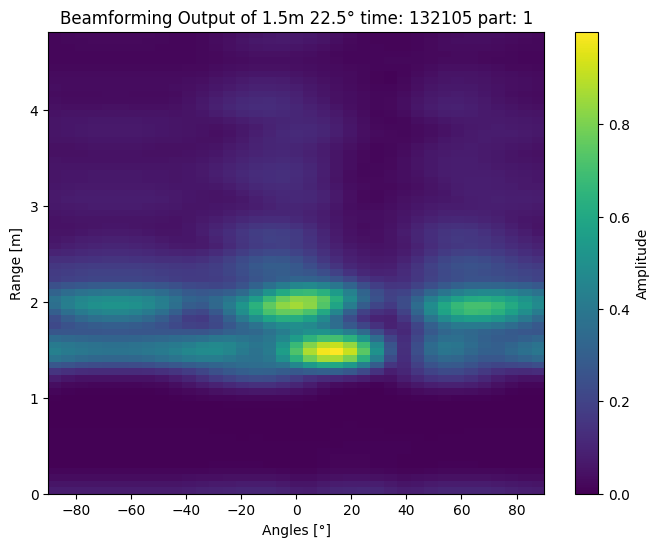

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132105split2.png


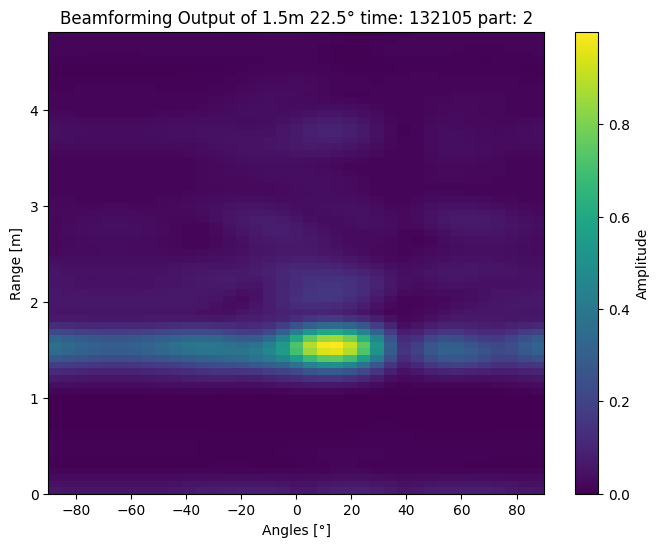

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132105split3.png


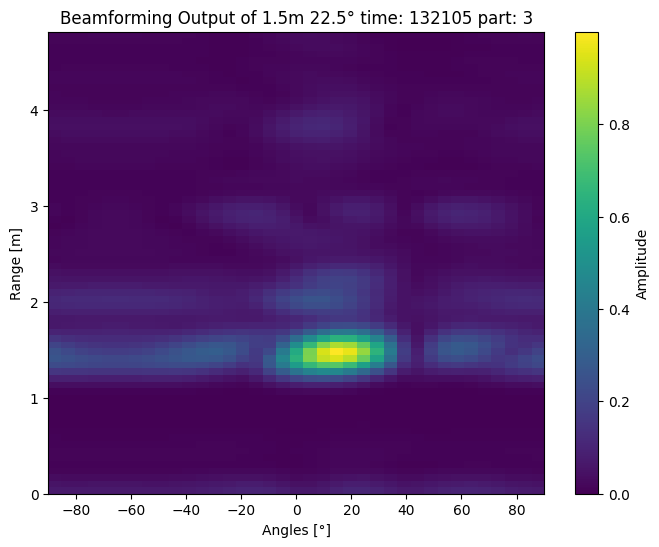

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132105split4.png


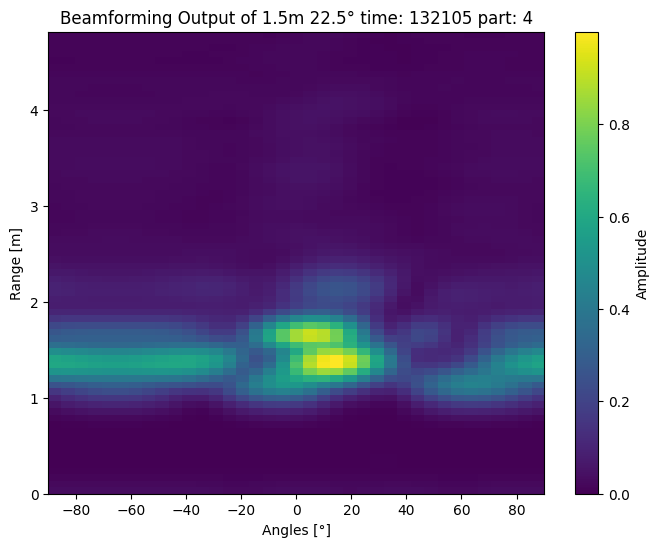

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132105split5.png


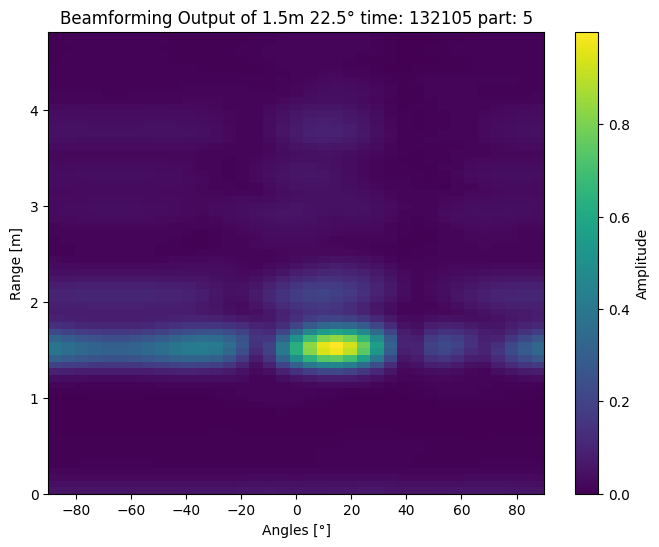

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132333split1.png


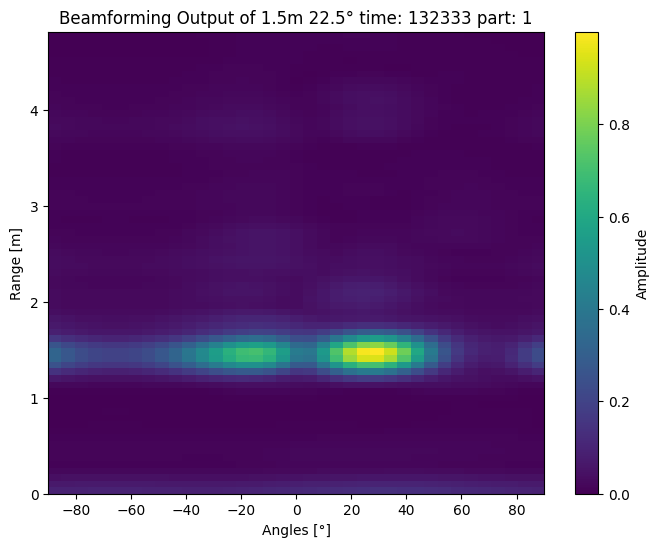

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132333split2.png


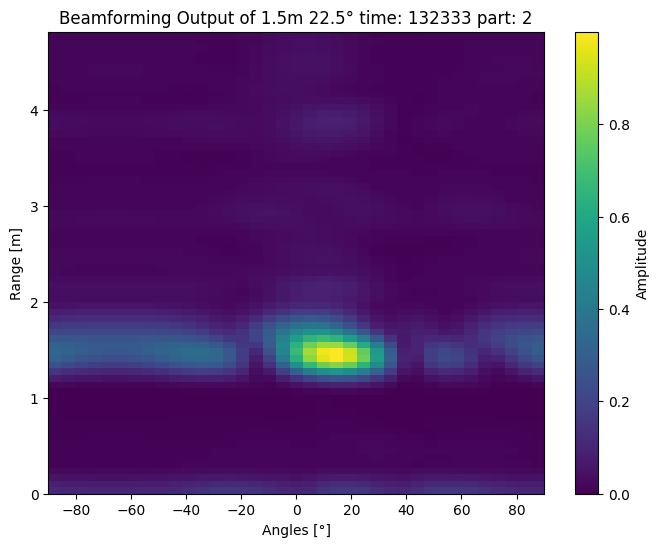

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132333split3.png


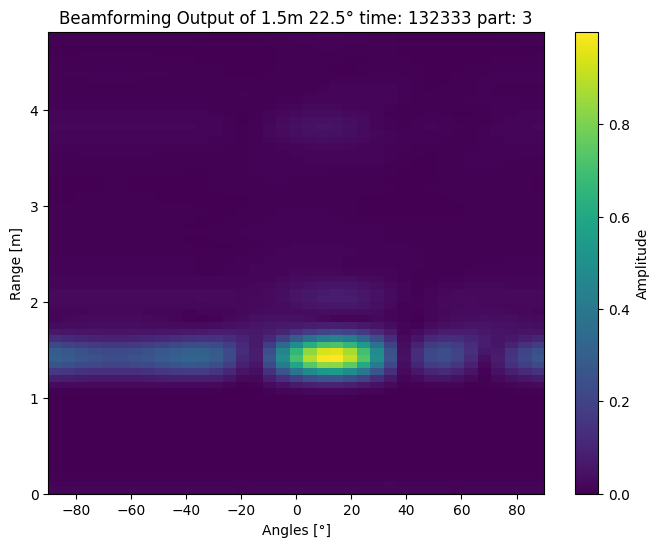

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132333split4.png


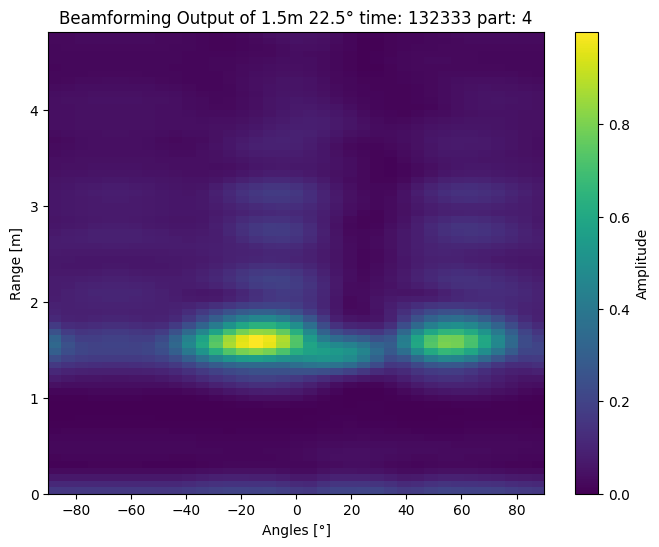

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_132333split5.png


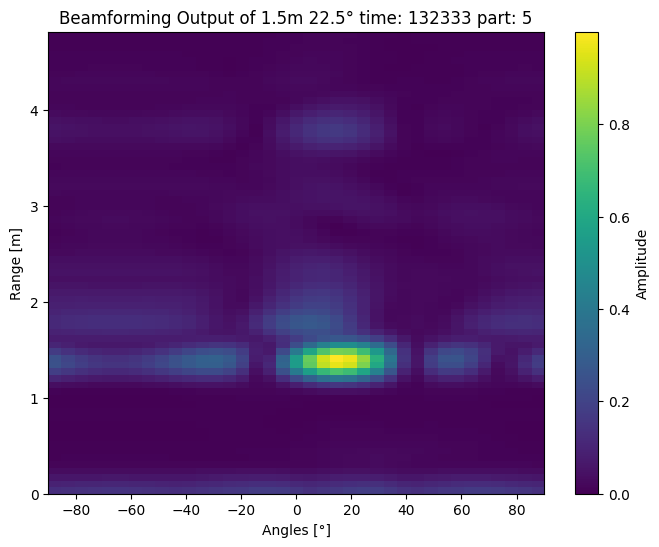

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131716split1.png


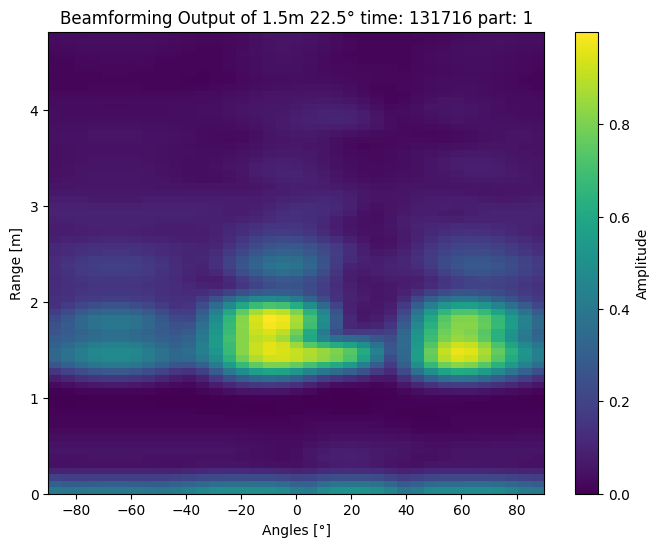

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131716split2.png


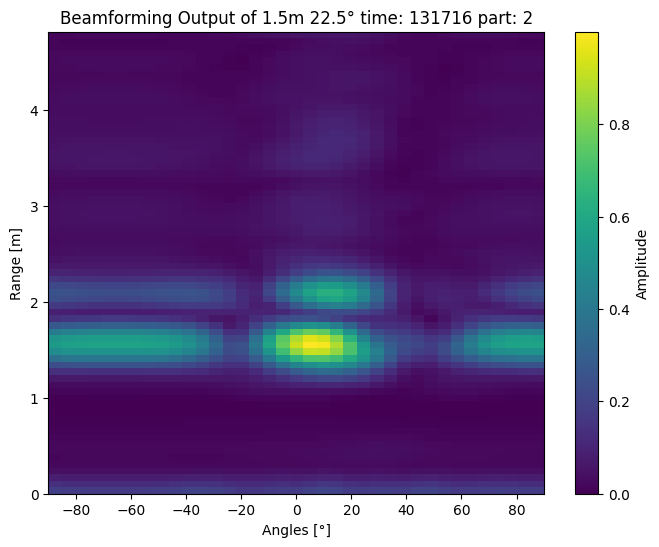

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131716split3.png


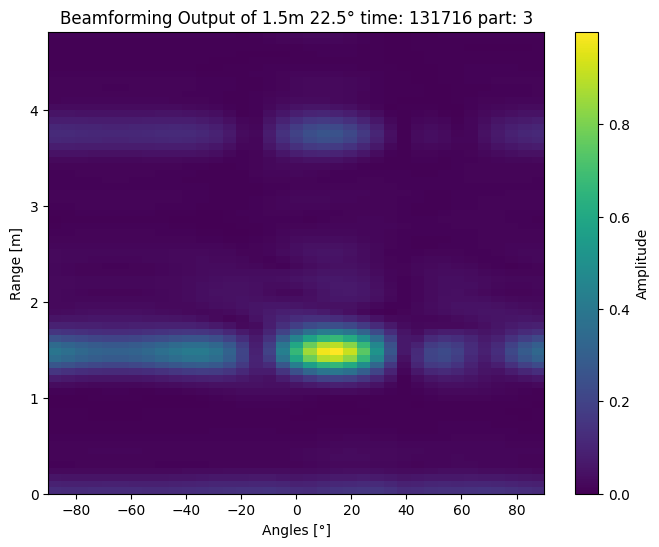

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131716split4.png


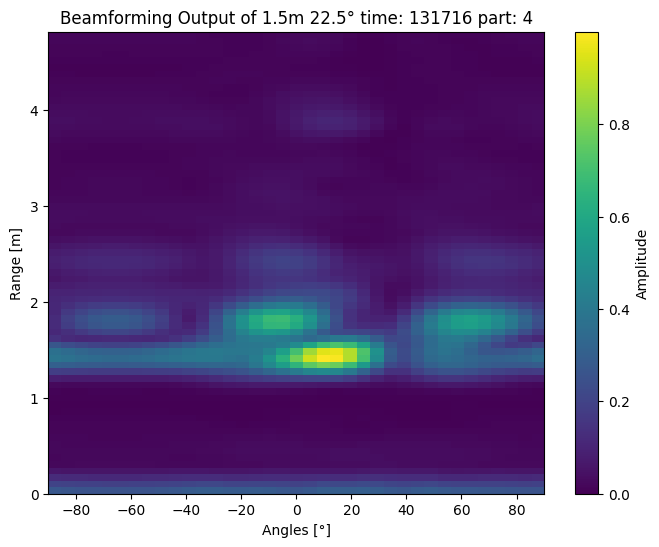

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131716split5.png


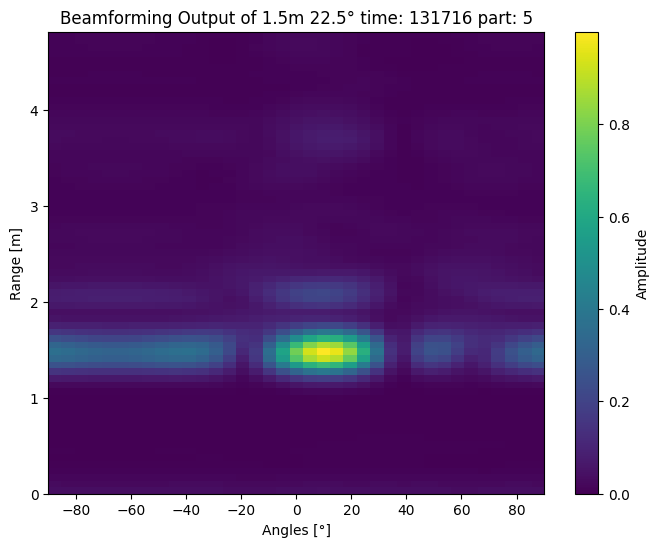

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131559split1.png


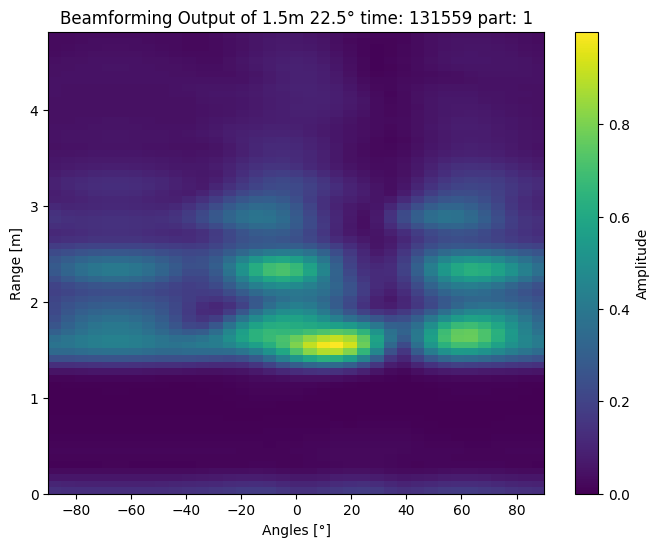

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131559split2.png


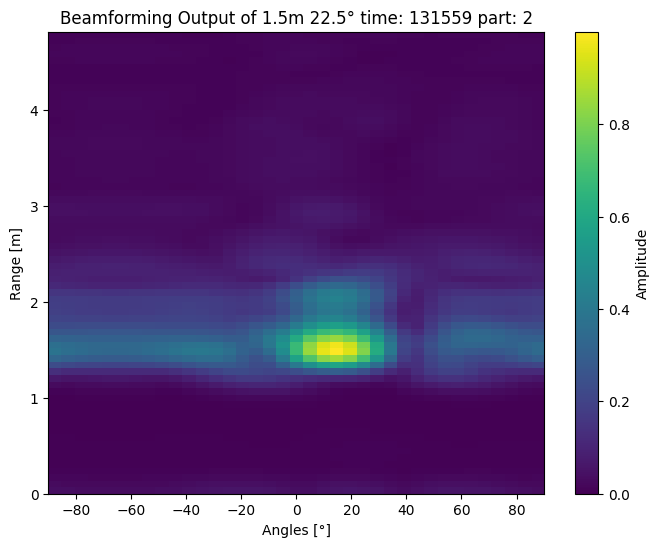

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131559split3.png


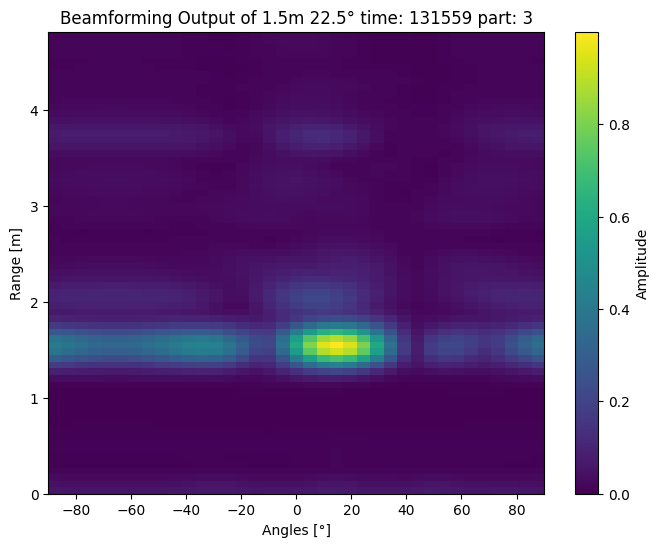

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131559split4.png


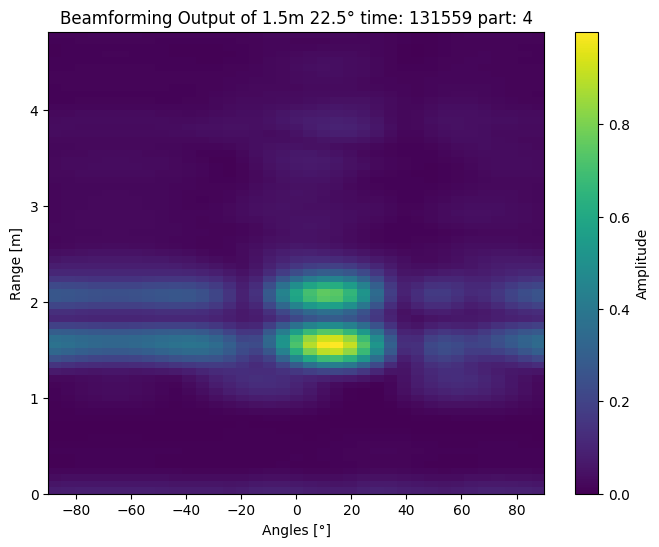

Grayscale image saved: /content/drive/MyDrive/Colab Notebooks/HAEEAI/project/DatasetPlotBean3/beam_150cm_22.5deg_131559split5.png


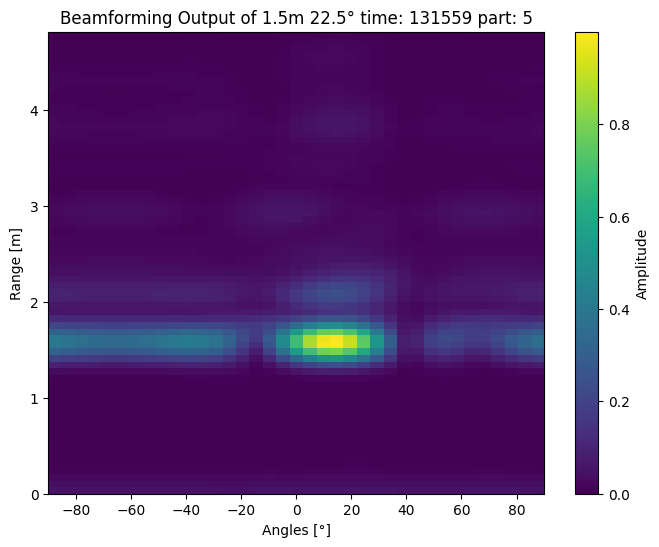

In [32]:
# 1) PARAMETRI (adatta se cambiano)
num_tx = 2
num_rx = 2
num_virtual_rx = num_tx * num_rx   # = 4
bins = slow_time = 1500    # deve corrispondere alla prima dimensione dei tuoi .npy
fast_time = 70    # ... e alla seconda

beam_steering_angles = np.deg2rad(np.linspace(-90, 90, 37))
d = 20e-3
f = 7.875e9
c = 299792458
l = c/f
k_const = 2 * np.pi / l

#even if you pass a single one, it's going to take the 4 of them
#beam_plot('Utente1_Generica statica (in piedi)_POLI_(350, 67.5)_20250130-135625_x7_tx0rx1')
beam_plot_all(files)